## Load libraries and files

In [1]:
!pyenv local 3.6.15
# Install any of the following packages with pip if you don't
# have them installed already
# Install stmpy package with the command "pip3 install getstmpy"
import stmpy
import stmpy.driftcorr as dfc
import h5py
import scipy as sp
%pylab inline
from decimal import Decimal, getcontext

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pre-define functions to do data recovery

from pylbfgs import owlqn

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T
#     print(shape(x2))
#     x2 = x2 * np.hanning(nx)[:, None] * np.hanning(nx)[None, :]
    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx


def dct2(x):
#     x, y = np.shape(x)
#     w = np.hanning(x)[:, None] * np.hanning(x)[None, :]
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
#     return stmpy.tools.ifft(x)
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

## The 40 nm topo

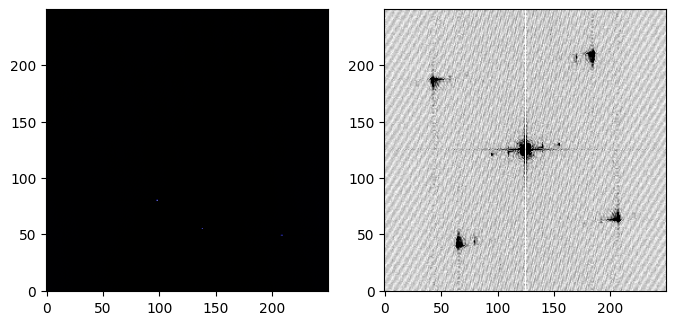

In [3]:
t = stmpy.load("2022-09-05_BSCCO_SparseSamplingTopo001.sxm", biasOffset=False)
t.z = stmpy.tools.lineSubtract(t.Z, 1)
dfc.display(t.z)

# part 1
## (drift correct then reconstruction)

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

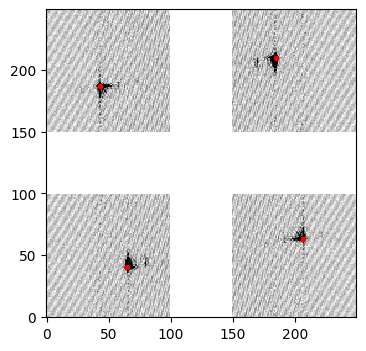

In [4]:
# Find parameters to find Bragg peaks
dfc.findBraggs(t.z, w=0.1, show=True)

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


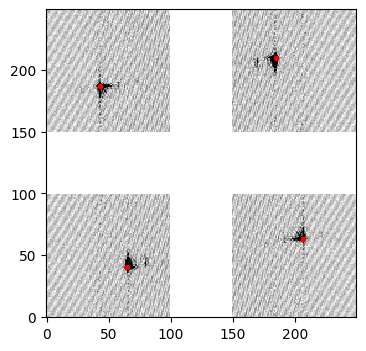

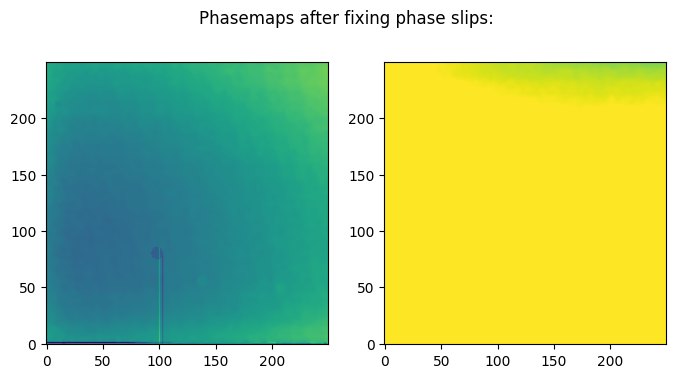

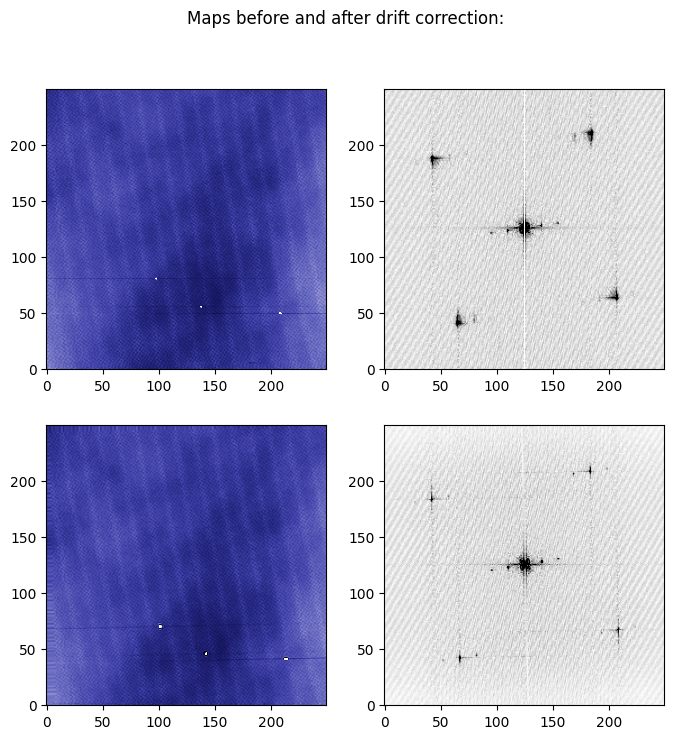

In [5]:
# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(t.z, w=0.1, sigma=20, show=True, method='lockin')

In [6]:
def standardize(data):
    data1 = (data / mean(data))
    #data1 = data1 * 3146.2264115727844
    return data1

In [7]:
original_mean = mean(t.z_c)
test = standardize(t.z_c)
nx, ny = shape(t.z_c)
# extract small sample of signal
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri]

In [8]:
testsparse = zeros_like(t.z_c)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

Iteration 1:
  fx = 311229968.284731, xnorm = 249.978404, gnorm = 35283.582679, step = 0.000028, k = 1, ls = 1

Iteration 2:
  fx = 159087950.836163, xnorm = 11217.919545, gnorm = 25208.081962, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 918879.582153, xnorm = 18802.797595, gnorm = 1652.611796, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 236206.758788, xnorm = 18720.304997, gnorm = 51.458838, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 235514.492585, xnorm = 18718.135633, gnorm = 10.528759, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 235454.256256, xnorm = 18717.049489, gnorm = 10.585978, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 233641.556969, xnorm = 18647.406652, gnorm = 94.570255, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 232175.629112, xnorm = 18630.531255, gnorm = 68.225899, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 231119.618373, xnorm = 18632.023950, gnorm = 45.381886, step = 0.125000, k = 9, ls = 4

Iteration 10:
  

Iteration 79:
  fx = 214565.471483, xnorm = 18419.931862, gnorm = 23.859977, step = 0.500000, k = 79, ls = 2

Iteration 80:
  fx = 214396.393619, xnorm = 18417.578169, gnorm = 26.573234, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 214165.053637, xnorm = 18416.862260, gnorm = 23.748921, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 213998.264441, xnorm = 18414.526456, gnorm = 26.587913, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 213766.612941, xnorm = 18413.883805, gnorm = 23.622229, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 213602.023032, xnorm = 18411.588714, gnorm = 26.549035, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 213371.185195, xnorm = 18411.026721, gnorm = 23.526840, step = 0.500000, k = 85, ls = 2

Iteration 86:
  fx = 213207.531790, xnorm = 18408.791771, gnorm = 26.486078, step = 0.500000, k = 86, ls = 2

Iteration 87:
  fx = 212977.732700, xnorm = 18408.278793, gnorm = 23.462409, step = 0.500000, k = 87, ls = 2

Iteration 

Iteration 159:
  fx = 200276.698899, xnorm = 18379.707683, gnorm = 17.752121, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 200209.030239, xnorm = 18378.692608, gnorm = 27.553894, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 199958.385498, xnorm = 18380.540853, gnorm = 17.707771, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 199893.265938, xnorm = 18379.568891, gnorm = 27.735763, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 199639.829911, xnorm = 18381.479686, gnorm = 17.594070, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 199575.759761, xnorm = 18380.539082, gnorm = 27.809268, step = 0.500000, k = 164, ls = 2

Iteration 165:
  fx = 199321.625736, xnorm = 18382.499309, gnorm = 17.444783, step = 0.500000, k = 165, ls = 2

Iteration 166:
  fx = 199259.341049, xnorm = 18381.602549, gnorm = 27.847264, step = 0.500000, k = 166, ls = 2

Iteration 167:
  fx = 199004.745464, xnorm = 18383.589780, gnorm = 17.301088, step = 0.500000, k = 167, 

Iteration 237:
  fx = 188922.858799, xnorm = 18463.523772, gnorm = 14.670505, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 188892.646010, xnorm = 18464.514984, gnorm = 26.653830, step = 0.500000, k = 238, ls = 2

Iteration 239:
  fx = 188665.254793, xnorm = 18466.897357, gnorm = 14.552076, step = 0.500000, k = 239, ls = 2

Iteration 240:
  fx = 188636.101664, xnorm = 18467.918946, gnorm = 26.642330, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 188409.382406, xnorm = 18470.261846, gnorm = 14.447871, step = 0.500000, k = 241, ls = 2

Iteration 242:
  fx = 188379.512714, xnorm = 18471.363324, gnorm = 26.474066, step = 0.500000, k = 242, ls = 2

Iteration 243:
  fx = 188156.259178, xnorm = 18473.668198, gnorm = 14.401750, step = 0.500000, k = 243, ls = 2

Iteration 244:
  fx = 188126.120187, xnorm = 18474.859473, gnorm = 26.340271, step = 0.500000, k = 244, ls = 2

Iteration 245:
  fx = 187905.358763, xnorm = 18477.156080, gnorm = 14.380679, step = 0.500000, k = 245, 

Iteration 314:
  fx = 180354.402100, xnorm = 18619.224912, gnorm = 22.985156, step = 0.500000, k = 314, ls = 2

Iteration 315:
  fx = 180184.373881, xnorm = 18621.613706, gnorm = 12.826540, step = 0.500000, k = 315, ls = 2

Iteration 316:
  fx = 180158.410003, xnorm = 18623.788550, gnorm = 22.817520, step = 0.500000, k = 316, ls = 2

Iteration 317:
  fx = 179991.323507, xnorm = 18626.233896, gnorm = 12.799842, step = 0.500000, k = 317, ls = 2

Iteration 318:
  fx = 179966.187711, xnorm = 18628.414147, gnorm = 22.806292, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 179799.333755, xnorm = 18630.853048, gnorm = 12.748372, step = 0.500000, k = 319, ls = 2

Iteration 320:
  fx = 179774.003318, xnorm = 18633.121739, gnorm = 22.698577, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 179608.626110, xnorm = 18635.473668, gnorm = 12.706802, step = 0.500000, k = 321, ls = 2

Iteration 322:
  fx = 179583.198537, xnorm = 18637.783277, gnorm = 22.592772, step = 0.500000, k = 322, 

Iteration 390:
  fx = 173780.980312, xnorm = 18805.726338, gnorm = 20.311651, step = 0.500000, k = 390, ls = 2

Iteration 391:
  fx = 173647.691978, xnorm = 18808.285790, gnorm = 11.336952, step = 0.500000, k = 391, ls = 2

Iteration 392:
  fx = 173628.244550, xnorm = 18810.892953, gnorm = 20.263926, step = 0.500000, k = 392, ls = 2

Iteration 393:
  fx = 173495.577038, xnorm = 18813.482805, gnorm = 11.313011, step = 0.500000, k = 393, ls = 2

Iteration 394:
  fx = 173476.657173, xnorm = 18816.078017, gnorm = 20.248226, step = 0.500000, k = 394, ls = 2

Iteration 395:
  fx = 173343.880218, xnorm = 18818.685949, gnorm = 11.236036, step = 0.500000, k = 395, ls = 2

Iteration 396:
  fx = 173325.894080, xnorm = 18821.252251, gnorm = 20.228685, step = 0.500000, k = 396, ls = 2

Iteration 397:
  fx = 173193.139153, xnorm = 18823.875957, gnorm = 11.068855, step = 0.500000, k = 397, ls = 2

Iteration 398:
  fx = 173174.759417, xnorm = 18826.376733, gnorm = 20.025455, step = 0.500000, k = 398, 

Iteration 465:
  fx = 168602.808405, xnorm = 19003.332208, gnorm = 10.211191, step = 0.500000, k = 465, ls = 2

Iteration 466:
  fx = 168585.303328, xnorm = 19005.885234, gnorm = 17.822710, step = 0.500000, k = 466, ls = 2

Iteration 467:
  fx = 168481.945243, xnorm = 19008.641655, gnorm = 10.220178, step = 0.500000, k = 467, ls = 2

Iteration 468:
  fx = 168464.858217, xnorm = 19011.199465, gnorm = 17.852874, step = 0.500000, k = 468, ls = 2

Iteration 469:
  fx = 168360.884754, xnorm = 19013.960298, gnorm = 10.141897, step = 0.500000, k = 469, ls = 2

Iteration 470:
  fx = 168344.641905, xnorm = 19016.518579, gnorm = 17.873081, step = 0.500000, k = 470, ls = 2

Iteration 471:
  fx = 168240.297887, xnorm = 19019.286223, gnorm = 10.056904, step = 0.500000, k = 471, ls = 2

Iteration 472:
  fx = 168224.283687, xnorm = 19021.821920, gnorm = 17.808329, step = 0.500000, k = 472, ls = 2

Iteration 473:
  fx = 168120.683249, xnorm = 19024.611823, gnorm = 10.023576, step = 0.500000, k = 473, 

Iteration 540:
  fx = 164515.609291, xnorm = 19203.746161, gnorm = 16.076823, step = 0.500000, k = 540, ls = 2

Iteration 541:
  fx = 164430.714224, xnorm = 19206.648112, gnorm = 9.054241, step = 0.500000, k = 541, ls = 2

Iteration 542:
  fx = 164417.422713, xnorm = 19209.061850, gnorm = 15.983983, step = 0.500000, k = 542, ls = 2

Iteration 543:
  fx = 164333.555457, xnorm = 19211.987185, gnorm = 9.069638, step = 0.500000, k = 543, ls = 2

Iteration 544:
  fx = 164320.138508, xnorm = 19214.399278, gnorm = 15.952957, step = 0.500000, k = 544, ls = 2

Iteration 545:
  fx = 164236.625599, xnorm = 19217.328611, gnorm = 9.097819, step = 0.500000, k = 545, ls = 2

Iteration 546:
  fx = 164223.165183, xnorm = 19219.768139, gnorm = 15.939036, step = 0.500000, k = 546, ls = 2

Iteration 547:
  fx = 164139.738023, xnorm = 19222.698031, gnorm = 9.086930, step = 0.500000, k = 547, ls = 2

Iteration 548:
  fx = 164126.539403, xnorm = 19225.145391, gnorm = 15.945356, step = 0.500000, k = 548, ls =

Iteration 615:
  fx = 161149.141530, xnorm = 19401.937546, gnorm = 8.252597, step = 0.500000, k = 615, ls = 2

Iteration 616:
  fx = 161137.096517, xnorm = 19404.236056, gnorm = 14.296259, step = 0.500000, k = 616, ls = 2

Iteration 617:
  fx = 161069.933019, xnorm = 19407.110262, gnorm = 8.324978, step = 0.500000, k = 617, ls = 2

Iteration 618:
  fx = 161057.553849, xnorm = 19409.423156, gnorm = 14.285509, step = 0.500000, k = 618, ls = 2

Iteration 619:
  fx = 160990.648022, xnorm = 19412.314022, gnorm = 8.361547, step = 0.500000, k = 619, ls = 2

Iteration 620:
  fx = 160978.327522, xnorm = 19414.644956, gnorm = 14.298834, step = 0.500000, k = 620, ls = 2

Iteration 621:
  fx = 160911.127261, xnorm = 19417.496989, gnorm = 8.249354, step = 0.500000, k = 621, ls = 2

Iteration 622:
  fx = 160899.630181, xnorm = 19419.841778, gnorm = 14.239241, step = 0.500000, k = 622, ls = 2

Iteration 623:
  fx = 160832.706997, xnorm = 19422.650955, gnorm = 8.141157, step = 0.500000, k = 623, ls = 

Iteration 690:
  fx = 158448.405420, xnorm = 19592.498430, gnorm = 12.963934, step = 0.500000, k = 690, ls = 2

Iteration 691:
  fx = 158393.069649, xnorm = 19595.292299, gnorm = 7.598833, step = 0.500000, k = 691, ls = 2

Iteration 692:
  fx = 158382.509915, xnorm = 19597.478704, gnorm = 12.895282, step = 0.500000, k = 692, ls = 2

Iteration 693:
  fx = 158327.588836, xnorm = 19600.230753, gnorm = 7.537779, step = 0.500000, k = 693, ls = 2

Iteration 694:
  fx = 158317.517059, xnorm = 19602.416130, gnorm = 12.879892, step = 0.500000, k = 694, ls = 2

Iteration 695:
  fx = 158262.644395, xnorm = 19605.182656, gnorm = 7.483778, step = 0.500000, k = 695, ls = 2

Iteration 696:
  fx = 158252.566776, xnorm = 19607.343825, gnorm = 12.822891, step = 0.500000, k = 696, ls = 2

Iteration 697:
  fx = 158198.283717, xnorm = 19610.114253, gnorm = 7.530139, step = 0.500000, k = 697, ls = 2

Iteration 698:
  fx = 158187.835101, xnorm = 19612.263142, gnorm = 12.764347, step = 0.500000, k = 698, ls =

Iteration 765:
  fx = 156200.081749, xnorm = 19772.425770, gnorm = 6.884835, step = 0.500000, k = 765, ls = 2

Iteration 766:
  fx = 156191.388089, xnorm = 19774.385535, gnorm = 11.638266, step = 0.500000, k = 766, ls = 2

Iteration 767:
  fx = 156146.190035, xnorm = 19777.052782, gnorm = 6.890874, step = 0.500000, k = 767, ls = 2

Iteration 768:
  fx = 156137.454250, xnorm = 19779.026978, gnorm = 11.628154, step = 0.500000, k = 768, ls = 2

Iteration 769:
  fx = 156092.340455, xnorm = 19781.690720, gnorm = 6.881008, step = 0.500000, k = 769, ls = 2

Iteration 770:
  fx = 156083.660899, xnorm = 19783.655782, gnorm = 11.612665, step = 0.500000, k = 770, ls = 2

Iteration 771:
  fx = 156038.731946, xnorm = 19786.330891, gnorm = 6.874013, step = 0.500000, k = 771, ls = 2

Iteration 772:
  fx = 156029.727690, xnorm = 19788.280402, gnorm = 11.546396, step = 0.500000, k = 772, ls = 2

Iteration 773:
  fx = 155985.370502, xnorm = 19790.947992, gnorm = 6.892113, step = 0.500000, k = 773, ls = 

Iteration 840:
  fx = 154349.040119, xnorm = 19941.976821, gnorm = 10.744253, step = 0.500000, k = 840, ls = 2

Iteration 841:
  fx = 154310.481692, xnorm = 19944.540297, gnorm = 6.353488, step = 0.500000, k = 841, ls = 2

Iteration 842:
  fx = 154302.904870, xnorm = 19946.391287, gnorm = 10.689470, step = 0.500000, k = 842, ls = 2

Iteration 843:
  fx = 154264.694474, xnorm = 19948.952816, gnorm = 6.312220, step = 0.500000, k = 843, ls = 2

Iteration 844:
  fx = 154257.314151, xnorm = 19950.797502, gnorm = 10.675992, step = 0.500000, k = 844, ls = 2

Iteration 845:
  fx = 154219.280346, xnorm = 19953.385121, gnorm = 6.305447, step = 0.500000, k = 845, ls = 2

Iteration 846:
  fx = 154211.691019, xnorm = 19955.210969, gnorm = 10.624588, step = 0.500000, k = 846, ls = 2

Iteration 847:
  fx = 154174.144457, xnorm = 19957.799482, gnorm = 6.333756, step = 0.500000, k = 847, ls = 2

Iteration 848:
  fx = 154166.554944, xnorm = 19959.613925, gnorm = 10.625570, step = 0.500000, k = 848, ls =

Iteration 914:
  fx = 152782.463155, xnorm = 20101.548524, gnorm = 9.788986, step = 0.500000, k = 914, ls = 2

Iteration 915:
  fx = 152750.418638, xnorm = 20104.039311, gnorm = 5.921628, step = 0.500000, k = 915, ls = 2

Iteration 916:
  fx = 152743.713133, xnorm = 20105.707704, gnorm = 9.795211, step = 0.500000, k = 916, ls = 2

Iteration 917:
  fx = 152711.553051, xnorm = 20108.195717, gnorm = 5.868990, step = 0.500000, k = 917, ls = 2

Iteration 918:
  fx = 152704.950844, xnorm = 20109.866840, gnorm = 9.755375, step = 0.500000, k = 918, ls = 2

Iteration 919:
  fx = 152673.036390, xnorm = 20112.348308, gnorm = 5.860478, step = 0.500000, k = 919, ls = 2

Iteration 920:
  fx = 152666.466942, xnorm = 20114.037504, gnorm = 9.745753, step = 0.500000, k = 920, ls = 2

Iteration 921:
  fx = 152634.610736, xnorm = 20116.506095, gnorm = 5.835746, step = 0.500000, k = 921, ls = 2

Iteration 922:
  fx = 152627.920747, xnorm = 20118.178214, gnorm = 9.680163, step = 0.500000, k = 922, ls = 2

I

Iteration 988:
  fx = 151453.317520, xnorm = 20251.036162, gnorm = 8.943065, step = 0.500000, k = 988, ls = 2

Iteration 989:
  fx = 151426.473992, xnorm = 20253.387461, gnorm = 5.509346, step = 0.500000, k = 989, ls = 2

Iteration 990:
  fx = 151420.282865, xnorm = 20254.953579, gnorm = 8.965860, step = 0.500000, k = 990, ls = 2

Iteration 991:
  fx = 151393.251933, xnorm = 20257.318848, gnorm = 5.492994, step = 0.500000, k = 991, ls = 2

Iteration 992:
  fx = 151387.102827, xnorm = 20258.871499, gnorm = 8.961255, step = 0.500000, k = 992, ls = 2

Iteration 993:
  fx = 151360.060103, xnorm = 20261.240540, gnorm = 5.452069, step = 0.500000, k = 993, ls = 2

Iteration 994:
  fx = 151353.964438, xnorm = 20262.782369, gnorm = 8.935725, step = 0.500000, k = 994, ls = 2

Iteration 995:
  fx = 151327.117276, xnorm = 20265.136748, gnorm = 5.425986, step = 0.500000, k = 995, ls = 2

Iteration 996:
  fx = 151321.053040, xnorm = 20266.679386, gnorm = 8.886978, step = 0.500000, k = 996, ls = 2

I

Iteration 1062:
  fx = 150309.024565, xnorm = 20392.406741, gnorm = 8.314781, step = 0.500000, k = 1062, ls = 2

Iteration 1063:
  fx = 150285.842024, xnorm = 20394.662401, gnorm = 5.154953, step = 0.500000, k = 1063, ls = 2

Iteration 1064:
  fx = 150280.286880, xnorm = 20396.131331, gnorm = 8.285515, step = 0.500000, k = 1064, ls = 2

Iteration 1065:
  fx = 150257.269750, xnorm = 20398.370942, gnorm = 5.128789, step = 0.500000, k = 1065, ls = 2

Iteration 1066:
  fx = 150251.824536, xnorm = 20399.858922, gnorm = 8.265627, step = 0.500000, k = 1066, ls = 2

Iteration 1067:
  fx = 150228.849122, xnorm = 20402.063646, gnorm = 5.066837, step = 0.500000, k = 1067, ls = 2

Iteration 1068:
  fx = 150223.621164, xnorm = 20403.541057, gnorm = 8.250551, step = 0.500000, k = 1068, ls = 2

Iteration 1069:
  fx = 150200.685387, xnorm = 20405.755056, gnorm = 5.047019, step = 0.500000, k = 1069, ls = 2

Iteration 1070:
  fx = 150195.565477, xnorm = 20407.227905, gnorm = 8.256037, step = 0.500000, k

Iteration 1136:
  fx = 149328.915361, xnorm = 20525.068433, gnorm = 7.604691, step = 0.500000, k = 1136, ls = 2

Iteration 1137:
  fx = 149309.499767, xnorm = 20527.199048, gnorm = 4.781032, step = 0.500000, k = 1137, ls = 2

Iteration 1138:
  fx = 149304.585927, xnorm = 20528.524956, gnorm = 7.602362, step = 0.500000, k = 1138, ls = 2

Iteration 1139:
  fx = 149285.169907, xnorm = 20530.647145, gnorm = 4.758471, step = 0.500000, k = 1139, ls = 2

Iteration 1140:
  fx = 149280.344111, xnorm = 20531.966683, gnorm = 7.589452, step = 0.500000, k = 1140, ls = 2

Iteration 1141:
  fx = 149260.917828, xnorm = 20534.079628, gnorm = 4.722880, step = 0.500000, k = 1141, ls = 2

Iteration 1142:
  fx = 149256.179685, xnorm = 20535.397323, gnorm = 7.556295, step = 0.500000, k = 1142, ls = 2

Iteration 1143:
  fx = 149236.925783, xnorm = 20537.494602, gnorm = 4.710154, step = 0.500000, k = 1143, ls = 2

Iteration 1144:
  fx = 149232.068523, xnorm = 20538.804127, gnorm = 7.501886, step = 0.500000, k

Iteration 1209:
  fx = 148490.938897, xnorm = 20647.270682, gnorm = 4.421207, step = 0.500000, k = 1209, ls = 2

Iteration 1210:
  fx = 148486.897020, xnorm = 20648.540917, gnorm = 7.177122, step = 0.500000, k = 1210, ls = 2

Iteration 1211:
  fx = 148469.523686, xnorm = 20650.511307, gnorm = 4.376938, step = 0.500000, k = 1211, ls = 2

Iteration 1212:
  fx = 148465.627686, xnorm = 20651.785772, gnorm = 7.167286, step = 0.500000, k = 1212, ls = 2

Iteration 1213:
  fx = 148448.264041, xnorm = 20653.742113, gnorm = 4.322687, step = 0.500000, k = 1213, ls = 2

Iteration 1214:
  fx = 148444.442503, xnorm = 20654.996179, gnorm = 7.132870, step = 0.500000, k = 1214, ls = 2

Iteration 1215:
  fx = 148427.236604, xnorm = 20656.956485, gnorm = 4.338117, step = 0.500000, k = 1215, ls = 2

Iteration 1216:
  fx = 148423.379606, xnorm = 20658.207939, gnorm = 7.135527, step = 0.500000, k = 1216, ls = 2

Iteration 1217:
  fx = 148406.201475, xnorm = 20660.175664, gnorm = 4.359176, step = 0.500000, k

Iteration 1282:
  fx = 147772.611513, xnorm = 20761.471814, gnorm = 6.653385, step = 0.500000, k = 1282, ls = 2

Iteration 1283:
  fx = 147757.667328, xnorm = 20763.333120, gnorm = 4.107042, step = 0.500000, k = 1283, ls = 2

Iteration 1284:
  fx = 147754.025271, xnorm = 20764.492537, gnorm = 6.612637, step = 0.500000, k = 1284, ls = 2

Iteration 1285:
  fx = 147739.276364, xnorm = 20766.351663, gnorm = 4.116339, step = 0.500000, k = 1285, ls = 2

Iteration 1286:
  fx = 147735.615741, xnorm = 20767.517703, gnorm = 6.586461, step = 0.500000, k = 1286, ls = 2

Iteration 1287:
  fx = 147720.968095, xnorm = 20769.376480, gnorm = 4.123853, step = 0.500000, k = 1287, ls = 2

Iteration 1288:
  fx = 147717.347029, xnorm = 20770.529210, gnorm = 6.586091, step = 0.500000, k = 1288, ls = 2

Iteration 1289:
  fx = 147702.714653, xnorm = 20772.384082, gnorm = 4.113931, step = 0.500000, k = 1289, ls = 2

Iteration 1290:
  fx = 147699.088022, xnorm = 20773.539175, gnorm = 6.569596, step = 0.500000, k

Iteration 1356:
  fx = 147127.457365, xnorm = 20870.280331, gnorm = 6.259857, step = 0.500000, k = 1356, ls = 2

Iteration 1357:
  fx = 147114.337315, xnorm = 20872.019479, gnorm = 3.890410, step = 0.500000, k = 1357, ls = 2

Iteration 1358:
  fx = 147111.085273, xnorm = 20873.141812, gnorm = 6.281124, step = 0.500000, k = 1358, ls = 2

Iteration 1359:
  fx = 147097.855270, xnorm = 20874.889595, gnorm = 3.878524, step = 0.500000, k = 1359, ls = 2

Iteration 1360:
  fx = 147094.713631, xnorm = 20876.023514, gnorm = 6.307023, step = 0.500000, k = 1360, ls = 2

Iteration 1361:
  fx = 147081.323965, xnorm = 20877.765904, gnorm = 3.816018, step = 0.500000, k = 1361, ls = 2

Iteration 1362:
  fx = 147078.288202, xnorm = 20878.870089, gnorm = 6.292572, step = 0.500000, k = 1362, ls = 2

Iteration 1363:
  fx = 147064.988757, xnorm = 20880.606354, gnorm = 3.806118, step = 0.500000, k = 1363, ls = 2

Iteration 1364:
  fx = 147061.869483, xnorm = 20881.719150, gnorm = 6.232572, step = 0.500000, k

Iteration 1429:
  fx = 146560.539162, xnorm = 20971.672366, gnorm = 3.691749, step = 0.500000, k = 1429, ls = 2

Iteration 1430:
  fx = 146557.491695, xnorm = 20972.701047, gnorm = 5.812743, step = 0.500000, k = 1430, ls = 2

Iteration 1431:
  fx = 146546.105253, xnorm = 20974.362101, gnorm = 3.672706, step = 0.500000, k = 1431, ls = 2

Iteration 1432:
  fx = 146543.098405, xnorm = 20975.385078, gnorm = 5.804071, step = 0.500000, k = 1432, ls = 2

Iteration 1433:
  fx = 146531.745885, xnorm = 20977.051108, gnorm = 3.664730, step = 0.500000, k = 1433, ls = 2

Iteration 1434:
  fx = 146528.728661, xnorm = 20978.065243, gnorm = 5.802204, step = 0.500000, k = 1434, ls = 2

Iteration 1435:
  fx = 146517.359396, xnorm = 20979.730532, gnorm = 3.620745, step = 0.500000, k = 1435, ls = 2

Iteration 1436:
  fx = 146514.469280, xnorm = 20980.736100, gnorm = 5.805648, step = 0.500000, k = 1436, ls = 2

Iteration 1437:
  fx = 146503.107802, xnorm = 20982.401670, gnorm = 3.612021, step = 0.500000, k

Iteration 1502:
  fx = 146071.810640, xnorm = 21066.046344, gnorm = 5.461207, step = 0.500000, k = 1502, ls = 2

Iteration 1503:
  fx = 146061.714031, xnorm = 21067.638793, gnorm = 3.407505, step = 0.500000, k = 1503, ls = 2

Iteration 1504:
  fx = 146059.149697, xnorm = 21068.554299, gnorm = 5.448688, step = 0.500000, k = 1504, ls = 2

Iteration 1505:
  fx = 146049.110600, xnorm = 21070.144487, gnorm = 3.397273, step = 0.500000, k = 1505, ls = 2

Iteration 1506:
  fx = 146046.543997, xnorm = 21071.052878, gnorm = 5.430557, step = 0.500000, k = 1506, ls = 2

Iteration 1507:
  fx = 146036.565691, xnorm = 21072.645233, gnorm = 3.406075, step = 0.500000, k = 1507, ls = 2

Iteration 1508:
  fx = 146033.972249, xnorm = 21073.553175, gnorm = 5.426276, step = 0.500000, k = 1508, ls = 2

Iteration 1509:
  fx = 146024.033895, xnorm = 21075.150392, gnorm = 3.416373, step = 0.500000, k = 1509, ls = 2

Iteration 1510:
  fx = 146021.431172, xnorm = 21076.061357, gnorm = 5.418851, step = 0.500000, k

Iteration 1611:
  fx = 145433.625901, xnorm = 21198.084378, gnorm = 3.106808, step = 0.500000, k = 1611, ls = 2

Iteration 1612:
  fx = 145431.570662, xnorm = 21198.952820, gnorm = 5.055236, step = 0.500000, k = 1612, ls = 2

Iteration 1613:
  fx = 145422.916116, xnorm = 21200.413114, gnorm = 3.087934, step = 0.500000, k = 1613, ls = 2

Iteration 1614:
  fx = 145420.907256, xnorm = 21201.284376, gnorm = 5.058892, step = 0.500000, k = 1614, ls = 2

Iteration 1615:
  fx = 145412.248848, xnorm = 21202.741046, gnorm = 3.080937, step = 0.500000, k = 1615, ls = 2

Iteration 1616:
  fx = 145410.212094, xnorm = 21203.619926, gnorm = 5.040551, step = 0.500000, k = 1616, ls = 2

Iteration 1617:
  fx = 145401.614022, xnorm = 21205.066670, gnorm = 3.086236, step = 0.500000, k = 1617, ls = 2

Iteration 1618:
  fx = 145399.559442, xnorm = 21205.947310, gnorm = 5.029657, step = 0.500000, k = 1618, ls = 2

Iteration 1619:
  fx = 145391.013606, xnorm = 21207.390350, gnorm = 3.092205, step = 0.500000, k

Iteration 1719:
  fx = 144906.634101, xnorm = 21317.775342, gnorm = 2.861480, step = 0.500000, k = 1719, ls = 2

Iteration 1720:
  fx = 144904.814554, xnorm = 21318.554776, gnorm = 4.569627, step = 0.500000, k = 1720, ls = 2

Iteration 1721:
  fx = 144897.736813, xnorm = 21319.883750, gnorm = 2.852648, step = 0.500000, k = 1721, ls = 2

Iteration 1722:
  fx = 144895.912299, xnorm = 21320.653787, gnorm = 4.550607, step = 0.500000, k = 1722, ls = 2

Iteration 1723:
  fx = 144888.897894, xnorm = 21321.985695, gnorm = 2.855862, step = 0.500000, k = 1723, ls = 2

Iteration 1724:
  fx = 144887.078192, xnorm = 21322.742965, gnorm = 4.541893, step = 0.500000, k = 1724, ls = 2

Iteration 1725:
  fx = 144880.094472, xnorm = 21324.078466, gnorm = 2.855388, step = 0.500000, k = 1725, ls = 2

Iteration 1726:
  fx = 144878.269573, xnorm = 21324.838446, gnorm = 4.528187, step = 0.500000, k = 1726, ls = 2

Iteration 1727:
  fx = 144871.319519, xnorm = 21326.172240, gnorm = 2.848547, step = 0.500000, k

Iteration 1792:
  fx = 144602.710133, xnorm = 21392.089324, gnorm = 4.246987, step = 0.500000, k = 1792, ls = 2

Iteration 1793:
  fx = 144596.601468, xnorm = 21393.339289, gnorm = 2.751112, step = 0.500000, k = 1793, ls = 2

Iteration 1794:
  fx = 144594.819671, xnorm = 21394.065652, gnorm = 4.249571, step = 0.500000, k = 1794, ls = 2

Iteration 1795:
  fx = 144588.712430, xnorm = 21395.321796, gnorm = 2.755778, step = 0.500000, k = 1795, ls = 2

Iteration 1796:
  fx = 144586.936700, xnorm = 21396.046899, gnorm = 4.256222, step = 0.500000, k = 1796, ls = 2

Iteration 1797:
  fx = 144580.795279, xnorm = 21397.301177, gnorm = 2.727575, step = 0.500000, k = 1797, ls = 2

Iteration 1798:
  fx = 144579.069655, xnorm = 21398.023070, gnorm = 4.251038, step = 0.500000, k = 1798, ls = 2

Iteration 1799:
  fx = 144572.941960, xnorm = 21399.263393, gnorm = 2.708789, step = 0.500000, k = 1799, ls = 2

Iteration 1800:
  fx = 144571.217910, xnorm = 21399.990090, gnorm = 4.234153, step = 0.500000, k

Iteration 1900:
  fx = 144206.801619, xnorm = 21494.798220, gnorm = 4.041940, step = 0.500000, k = 1900, ls = 2

Iteration 1901:
  fx = 144201.270935, xnorm = 21495.946836, gnorm = 2.463660, step = 0.500000, k = 1901, ls = 2

Iteration 1902:
  fx = 144199.983678, xnorm = 21496.642557, gnorm = 4.041409, step = 0.500000, k = 1902, ls = 2

Iteration 1903:
  fx = 144194.460114, xnorm = 21497.785327, gnorm = 2.461382, step = 0.500000, k = 1903, ls = 2

Iteration 1904:
  fx = 144193.134437, xnorm = 21498.484738, gnorm = 4.014431, step = 0.500000, k = 1904, ls = 2

Iteration 1905:
  fx = 144187.687591, xnorm = 21499.617068, gnorm = 2.466238, step = 0.500000, k = 1905, ls = 2

Iteration 1906:
  fx = 144186.378104, xnorm = 21500.317219, gnorm = 4.010909, step = 0.500000, k = 1906, ls = 2

Iteration 1907:
  fx = 144180.935170, xnorm = 21501.446828, gnorm = 2.460867, step = 0.500000, k = 1907, ls = 2

Iteration 1908:
  fx = 144179.608447, xnorm = 21502.150048, gnorm = 3.997841, step = 0.500000, k

Iteration 2008:
  fx = 143869.181280, xnorm = 21588.796105, gnorm = 3.665630, step = 0.500000, k = 2008, ls = 2

Iteration 2009:
  fx = 143864.629007, xnorm = 21589.823395, gnorm = 2.299297, step = 0.500000, k = 2009, ls = 2

Iteration 2010:
  fx = 143863.455740, xnorm = 21590.451438, gnorm = 3.664166, step = 0.500000, k = 2010, ls = 2

Iteration 2011:
  fx = 143858.892839, xnorm = 21591.481023, gnorm = 2.281832, step = 0.500000, k = 2011, ls = 2

Iteration 2012:
  fx = 143857.719360, xnorm = 21592.102204, gnorm = 3.647706, step = 0.500000, k = 2012, ls = 2

Iteration 2013:
  fx = 143853.202079, xnorm = 21593.128857, gnorm = 2.285332, step = 0.500000, k = 2013, ls = 2

Iteration 2014:
  fx = 143851.996940, xnorm = 21593.750165, gnorm = 3.631892, step = 0.500000, k = 2014, ls = 2

Iteration 2015:
  fx = 143847.539270, xnorm = 21594.777650, gnorm = 2.304729, step = 0.500000, k = 2015, ls = 2

Iteration 2016:
  fx = 143846.315130, xnorm = 21595.398397, gnorm = 3.622842, step = 0.500000, k

Iteration 2081:
  fx = 143669.336857, xnorm = 21647.608539, gnorm = 2.150731, step = 0.500000, k = 2081, ls = 2

Iteration 2082:
  fx = 143668.324405, xnorm = 21648.180008, gnorm = 3.513957, step = 0.500000, k = 2082, ls = 2

Iteration 2083:
  fx = 143664.142881, xnorm = 21649.181828, gnorm = 2.153192, step = 0.500000, k = 2083, ls = 2

Iteration 2084:
  fx = 143663.117228, xnorm = 21649.747065, gnorm = 3.499675, step = 0.500000, k = 2084, ls = 2

Iteration 2085:
  fx = 143658.968349, xnorm = 21650.744095, gnorm = 2.155308, step = 0.500000, k = 2085, ls = 2

Iteration 2086:
  fx = 143657.945794, xnorm = 21651.316678, gnorm = 3.496830, step = 0.500000, k = 2086, ls = 2

Iteration 2087:
  fx = 143653.806297, xnorm = 21652.306825, gnorm = 2.156675, step = 0.500000, k = 2087, ls = 2

Iteration 2088:
  fx = 143652.806304, xnorm = 21652.876452, gnorm = 3.501530, step = 0.500000, k = 2088, ls = 2

Iteration 2089:
  fx = 143648.647837, xnorm = 21653.864914, gnorm = 2.143867, step = 0.500000, k

Iteration 2154:
  fx = 143489.967515, xnorm = 21703.354517, gnorm = 3.336929, step = 0.500000, k = 2154, ls = 2

Iteration 2155:
  fx = 143486.214218, xnorm = 21704.290909, gnorm = 2.064438, step = 0.500000, k = 2155, ls = 2

Iteration 2156:
  fx = 143485.254706, xnorm = 21704.836174, gnorm = 3.327327, step = 0.500000, k = 2156, ls = 2

Iteration 2157:
  fx = 143481.513392, xnorm = 21705.771336, gnorm = 2.063345, step = 0.500000, k = 2157, ls = 2

Iteration 2158:
  fx = 143480.561584, xnorm = 21706.317475, gnorm = 3.328639, step = 0.500000, k = 2158, ls = 2

Iteration 2159:
  fx = 143476.812375, xnorm = 21707.256202, gnorm = 2.060400, step = 0.500000, k = 2159, ls = 2

Iteration 2160:
  fx = 143475.870451, xnorm = 21707.798453, gnorm = 3.326625, step = 0.500000, k = 2160, ls = 2

Iteration 2161:
  fx = 143472.128412, xnorm = 21708.735629, gnorm = 2.048097, step = 0.500000, k = 2161, ls = 2

Iteration 2162:
  fx = 143471.202406, xnorm = 21709.277211, gnorm = 3.318185, step = 0.500000, k

Iteration 2228:
  fx = 143325.009329, xnorm = 21756.335870, gnorm = 3.161730, step = 0.500000, k = 2228, ls = 2

Iteration 2229:
  fx = 143321.621481, xnorm = 21757.210324, gnorm = 1.952453, step = 0.500000, k = 2229, ls = 2

Iteration 2230:
  fx = 143320.771914, xnorm = 21757.734899, gnorm = 3.160732, step = 0.500000, k = 2230, ls = 2

Iteration 2231:
  fx = 143317.399883, xnorm = 21758.612542, gnorm = 1.959013, step = 0.500000, k = 2231, ls = 2

Iteration 2232:
  fx = 143316.536587, xnorm = 21759.124484, gnorm = 3.147141, step = 0.500000, k = 2232, ls = 2

Iteration 2233:
  fx = 143313.192102, xnorm = 21760.004597, gnorm = 1.952804, step = 0.500000, k = 2233, ls = 2

Iteration 2234:
  fx = 143312.322335, xnorm = 21760.514958, gnorm = 3.133496, step = 0.500000, k = 2234, ls = 2

Iteration 2235:
  fx = 143309.010635, xnorm = 21761.390876, gnorm = 1.951209, step = 0.500000, k = 2235, ls = 2

Iteration 2236:
  fx = 143308.144994, xnorm = 21761.902240, gnorm = 3.127867, step = 0.500000, k

Iteration 2301:
  fx = 143176.027415, xnorm = 21806.329142, gnorm = 1.862894, step = 0.500000, k = 2301, ls = 2

Iteration 2302:
  fx = 143175.253538, xnorm = 21806.804900, gnorm = 3.044101, step = 0.500000, k = 2302, ls = 2

Iteration 2303:
  fx = 143172.127544, xnorm = 21807.660676, gnorm = 1.856982, step = 0.500000, k = 2303, ls = 2

Iteration 2304:
  fx = 143171.361603, xnorm = 21808.135837, gnorm = 3.031184, step = 0.500000, k = 2304, ls = 2

Iteration 2305:
  fx = 143168.259770, xnorm = 21808.989509, gnorm = 1.863307, step = 0.500000, k = 2305, ls = 2

Iteration 2306:
  fx = 143167.474748, xnorm = 21809.473949, gnorm = 3.025924, step = 0.500000, k = 2306, ls = 2

Iteration 2307:
  fx = 143164.396572, xnorm = 21810.324827, gnorm = 1.880450, step = 0.500000, k = 2307, ls = 2

Iteration 2308:
  fx = 143163.597866, xnorm = 21810.804233, gnorm = 3.024006, step = 0.500000, k = 2308, ls = 2

Iteration 2309:
  fx = 143160.516191, xnorm = 21811.655531, gnorm = 1.870428, step = 0.500000, k

Iteration 2410:
  fx = 142976.977269, xnorm = 21877.011058, gnorm = 2.915727, step = 0.500000, k = 2410, ls = 2

Iteration 2411:
  fx = 142974.119908, xnorm = 21877.809147, gnorm = 1.726335, step = 0.500000, k = 2411, ls = 2

Iteration 2412:
  fx = 142973.498696, xnorm = 21878.286187, gnorm = 2.914500, step = 0.500000, k = 2412, ls = 2

Iteration 2413:
  fx = 142970.643323, xnorm = 21879.083213, gnorm = 1.736010, step = 0.500000, k = 2413, ls = 2

Iteration 2414:
  fx = 142970.030774, xnorm = 21879.556193, gnorm = 2.923591, step = 0.500000, k = 2414, ls = 2

Iteration 2415:
  fx = 142967.146427, xnorm = 21880.357258, gnorm = 1.724164, step = 0.500000, k = 2415, ls = 2

Iteration 2416:
  fx = 142966.563984, xnorm = 21880.828907, gnorm = 2.929399, step = 0.500000, k = 2416, ls = 2

Iteration 2417:
  fx = 142963.657215, xnorm = 21881.626714, gnorm = 1.707652, step = 0.500000, k = 2417, ls = 2

Iteration 2418:
  fx = 142963.100666, xnorm = 21882.100788, gnorm = 2.929827, step = 0.500000, k

Iteration 2519:
  fx = 142798.724813, xnorm = 21943.653871, gnorm = 1.646875, step = 0.500000, k = 2519, ls = 2

Iteration 2520:
  fx = 142798.120847, xnorm = 21944.086872, gnorm = 2.684074, step = 0.500000, k = 2520, ls = 2

Iteration 2521:
  fx = 142795.700308, xnorm = 21944.821630, gnorm = 1.658527, step = 0.500000, k = 2521, ls = 2

Iteration 2522:
  fx = 142795.082288, xnorm = 21945.250837, gnorm = 2.679622, step = 0.500000, k = 2522, ls = 2

Iteration 2523:
  fx = 142792.668373, xnorm = 21945.987170, gnorm = 1.657162, step = 0.500000, k = 2523, ls = 2

Iteration 2524:
  fx = 142792.077953, xnorm = 21946.417781, gnorm = 2.689883, step = 0.500000, k = 2524, ls = 2

Iteration 2525:
  fx = 142789.630429, xnorm = 21947.149983, gnorm = 1.629522, step = 0.500000, k = 2525, ls = 2

Iteration 2526:
  fx = 142789.049088, xnorm = 21947.578429, gnorm = 2.678289, step = 0.500000, k = 2526, ls = 2

Iteration 2527:
  fx = 142786.628837, xnorm = 21948.308047, gnorm = 1.631976, step = 0.500000, k

Iteration 2592:
  fx = 142693.175452, xnorm = 21985.126602, gnorm = 2.573463, step = 0.500000, k = 2592, ls = 2

Iteration 2593:
  fx = 142690.946125, xnorm = 21985.823769, gnorm = 1.586698, step = 0.500000, k = 2593, ls = 2

Iteration 2594:
  fx = 142690.386657, xnorm = 21986.243108, gnorm = 2.571109, step = 0.500000, k = 2594, ls = 2

Iteration 2595:
  fx = 142688.156557, xnorm = 21986.934574, gnorm = 1.584550, step = 0.500000, k = 2595, ls = 2

Iteration 2596:
  fx = 142687.595605, xnorm = 21987.355405, gnorm = 2.566254, step = 0.500000, k = 2596, ls = 2

Iteration 2597:
  fx = 142685.378560, xnorm = 21988.044299, gnorm = 1.583448, step = 0.500000, k = 2597, ls = 2

Iteration 2598:
  fx = 142684.816382, xnorm = 21988.469946, gnorm = 2.556391, step = 0.500000, k = 2598, ls = 2

Iteration 2599:
  fx = 142682.612670, xnorm = 21989.149434, gnorm = 1.573493, step = 0.500000, k = 2599, ls = 2

Iteration 2600:
  fx = 142682.059394, xnorm = 21989.575852, gnorm = 2.548736, step = 0.500000, k

Iteration 2700:
  fx = 142551.794475, xnorm = 22042.952162, gnorm = 2.419196, step = 0.500000, k = 2700, ls = 2

Iteration 2701:
  fx = 142549.824966, xnorm = 22043.587699, gnorm = 1.482933, step = 0.500000, k = 2701, ls = 2

Iteration 2702:
  fx = 142549.345317, xnorm = 22043.987410, gnorm = 2.424062, step = 0.500000, k = 2702, ls = 2

Iteration 2703:
  fx = 142547.361369, xnorm = 22044.627921, gnorm = 1.477031, step = 0.500000, k = 2703, ls = 2

Iteration 2704:
  fx = 142546.882474, xnorm = 22045.022952, gnorm = 2.425929, step = 0.500000, k = 2704, ls = 2

Iteration 2705:
  fx = 142544.897593, xnorm = 22045.666096, gnorm = 1.475600, step = 0.500000, k = 2705, ls = 2

Iteration 2706:
  fx = 142544.418729, xnorm = 22046.066731, gnorm = 2.426125, step = 0.500000, k = 2706, ls = 2

Iteration 2707:
  fx = 142542.432579, xnorm = 22046.708178, gnorm = 1.475876, step = 0.500000, k = 2707, ls = 2

Iteration 2708:
  fx = 142541.950931, xnorm = 22047.105721, gnorm = 2.421022, step = 0.500000, k

Iteration 2808:
  fx = 142424.769138, xnorm = 22097.659583, gnorm = 2.369214, step = 0.500000, k = 2808, ls = 2

Iteration 2809:
  fx = 142422.876246, xnorm = 22098.273391, gnorm = 1.374099, step = 0.500000, k = 2809, ls = 2

Iteration 2810:
  fx = 142422.498510, xnorm = 22098.664143, gnorm = 2.363262, step = 0.500000, k = 2810, ls = 2

Iteration 2811:
  fx = 142420.615412, xnorm = 22099.274864, gnorm = 1.378161, step = 0.500000, k = 2811, ls = 2

Iteration 2812:
  fx = 142420.235166, xnorm = 22099.663664, gnorm = 2.362961, step = 0.500000, k = 2812, ls = 2

Iteration 2813:
  fx = 142418.356106, xnorm = 22100.276468, gnorm = 1.375168, step = 0.500000, k = 2813, ls = 2

Iteration 2814:
  fx = 142417.984376, xnorm = 22100.665823, gnorm = 2.363662, step = 0.500000, k = 2814, ls = 2

Iteration 2815:
  fx = 142416.100934, xnorm = 22101.272809, gnorm = 1.360681, step = 0.500000, k = 2815, ls = 2

Iteration 2816:
  fx = 142415.726983, xnorm = 22101.661137, gnorm = 2.351014, step = 0.500000, k

Iteration 2914:
  fx = 142311.588935, xnorm = 22148.812054, gnorm = 2.182161, step = 0.500000, k = 2914, ls = 2

Iteration 2915:
  fx = 142309.984038, xnorm = 22149.378029, gnorm = 1.329598, step = 0.500000, k = 2915, ls = 2

Iteration 2916:
  fx = 142309.588931, xnorm = 22149.734277, gnorm = 2.177418, step = 0.500000, k = 2916, ls = 2

Iteration 2917:
  fx = 142307.993922, xnorm = 22150.300162, gnorm = 1.332326, step = 0.500000, k = 2917, ls = 2

Iteration 2918:
  fx = 142307.593923, xnorm = 22150.658314, gnorm = 2.167775, step = 0.500000, k = 2918, ls = 2

Iteration 2919:
  fx = 142306.014519, xnorm = 22151.220848, gnorm = 1.337896, step = 0.500000, k = 2919, ls = 2

Iteration 2920:
  fx = 142305.616339, xnorm = 22151.577676, gnorm = 2.165011, step = 0.500000, k = 2920, ls = 2

Iteration 2921:
  fx = 142304.036938, xnorm = 22152.137341, gnorm = 1.327640, step = 0.500000, k = 2921, ls = 2

Iteration 2922:
  fx = 142303.644468, xnorm = 22152.494005, gnorm = 2.161363, step = 0.500000, k

Iteration 3022:
  fx = 142210.322747, xnorm = 22196.907357, gnorm = 2.066802, step = 0.500000, k = 3022, ls = 2

Iteration 3023:
  fx = 142208.874718, xnorm = 22197.437742, gnorm = 1.217148, step = 0.500000, k = 3023, ls = 2

Iteration 3024:
  fx = 142208.565469, xnorm = 22197.758168, gnorm = 2.063258, step = 0.500000, k = 3024, ls = 2

Iteration 3025:
  fx = 142207.121312, xnorm = 22198.285402, gnorm = 1.217591, step = 0.500000, k = 3025, ls = 2

Iteration 3026:
  fx = 142206.808684, xnorm = 22198.606857, gnorm = 2.060427, step = 0.500000, k = 3026, ls = 2

Iteration 3027:
  fx = 142205.374045, xnorm = 22199.133739, gnorm = 1.224281, step = 0.500000, k = 3027, ls = 2

Iteration 3028:
  fx = 142205.057155, xnorm = 22199.453024, gnorm = 2.058068, step = 0.500000, k = 3028, ls = 2

Iteration 3029:
  fx = 142203.623815, xnorm = 22199.979682, gnorm = 1.223954, step = 0.500000, k = 3029, ls = 2

Iteration 3030:
  fx = 142203.303276, xnorm = 22200.302691, gnorm = 2.053082, step = 0.500000, k

Iteration 3131:
  fx = 142118.832822, xnorm = 22242.164705, gnorm = 1.142532, step = 0.500000, k = 3131, ls = 2

Iteration 3132:
  fx = 142118.579005, xnorm = 22242.479800, gnorm = 1.982428, step = 0.500000, k = 3132, ls = 2

Iteration 3133:
  fx = 142117.246142, xnorm = 22242.970093, gnorm = 1.144931, step = 0.500000, k = 3133, ls = 2

Iteration 3134:
  fx = 142116.993462, xnorm = 22243.285041, gnorm = 1.987242, step = 0.500000, k = 3134, ls = 2

Iteration 3135:
  fx = 142115.654197, xnorm = 22243.775297, gnorm = 1.140239, step = 0.500000, k = 3135, ls = 2

Iteration 3136:
  fx = 142115.404183, xnorm = 22244.089684, gnorm = 1.990034, step = 0.500000, k = 3136, ls = 2

Iteration 3137:
  fx = 142114.060966, xnorm = 22244.581446, gnorm = 1.135971, step = 0.500000, k = 3137, ls = 2

Iteration 3138:
  fx = 142113.819752, xnorm = 22244.892471, gnorm = 1.996135, step = 0.500000, k = 3138, ls = 2

Iteration 3139:
  fx = 142112.466966, xnorm = 22245.388036, gnorm = 1.131518, step = 0.500000, k

Iteration 3240:
  fx = 142035.943368, xnorm = 22285.208262, gnorm = 1.891950, step = 0.500000, k = 3240, ls = 2

Iteration 3241:
  fx = 142034.735749, xnorm = 22285.677468, gnorm = 1.102856, step = 0.500000, k = 3241, ls = 2

Iteration 3242:
  fx = 142034.493760, xnorm = 22285.982023, gnorm = 1.895466, step = 0.500000, k = 3242, ls = 2

Iteration 3243:
  fx = 142033.276517, xnorm = 22286.447699, gnorm = 1.085596, step = 0.500000, k = 3243, ls = 2

Iteration 3244:
  fx = 142033.047489, xnorm = 22286.746956, gnorm = 1.895805, step = 0.500000, k = 3244, ls = 2

Iteration 3245:
  fx = 142031.831880, xnorm = 22287.215587, gnorm = 1.079701, step = 0.500000, k = 3245, ls = 2

Iteration 3246:
  fx = 142031.599002, xnorm = 22287.514591, gnorm = 1.888030, step = 0.500000, k = 3246, ls = 2

Iteration 3247:
  fx = 142030.397676, xnorm = 22287.981701, gnorm = 1.089547, step = 0.500000, k = 3247, ls = 2

Iteration 3248:
  fx = 142030.160616, xnorm = 22288.281316, gnorm = 1.886769, step = 0.500000, k

Iteration 3347:
  fx = 141961.971479, xnorm = 22324.904868, gnorm = 1.046089, step = 0.500000, k = 3347, ls = 2

Iteration 3348:
  fx = 141961.750277, xnorm = 22325.179796, gnorm = 1.794437, step = 0.500000, k = 3348, ls = 2

Iteration 3349:
  fx = 141960.664477, xnorm = 22325.620744, gnorm = 1.043418, step = 0.500000, k = 3349, ls = 2

Iteration 3350:
  fx = 141960.444374, xnorm = 22325.897806, gnorm = 1.788172, step = 0.500000, k = 3350, ls = 2

Iteration 3351:
  fx = 141959.365828, xnorm = 22326.335401, gnorm = 1.043549, step = 0.500000, k = 3351, ls = 2

Iteration 3352:
  fx = 141959.143804, xnorm = 22326.609627, gnorm = 1.781999, step = 0.500000, k = 3352, ls = 2

Iteration 3353:
  fx = 141958.072776, xnorm = 22327.047265, gnorm = 1.042457, step = 0.500000, k = 3353, ls = 2

Iteration 3354:
  fx = 141957.851335, xnorm = 22327.319601, gnorm = 1.780465, step = 0.500000, k = 3354, ls = 2

Iteration 3355:
  fx = 141956.783304, xnorm = 22327.757595, gnorm = 1.043398, step = 0.500000, k

Iteration 3455:
  fx = 141894.353724, xnorm = 22362.785211, gnorm = 0.997213, step = 0.500000, k = 3455, ls = 2

Iteration 3456:
  fx = 141894.142546, xnorm = 22363.048085, gnorm = 1.699626, step = 0.500000, k = 3456, ls = 2

Iteration 3457:
  fx = 141893.171732, xnorm = 22363.464785, gnorm = 1.000376, step = 0.500000, k = 3457, ls = 2

Iteration 3458:
  fx = 141892.959323, xnorm = 22363.727667, gnorm = 1.701039, step = 0.500000, k = 3458, ls = 2

Iteration 3459:
  fx = 141891.989067, xnorm = 22364.143954, gnorm = 1.004596, step = 0.500000, k = 3459, ls = 2

Iteration 3460:
  fx = 141891.777453, xnorm = 22364.405534, gnorm = 1.702640, step = 0.500000, k = 3460, ls = 2

Iteration 3461:
  fx = 141890.802043, xnorm = 22364.821415, gnorm = 1.000316, step = 0.500000, k = 3461, ls = 2

Iteration 3462:
  fx = 141890.596162, xnorm = 22365.086021, gnorm = 1.703290, step = 0.500000, k = 3462, ls = 2

Iteration 3463:
  fx = 141889.618738, xnorm = 22365.498088, gnorm = 0.995990, step = 0.500000, k

Iteration 3564:
  fx = 141832.701332, xnorm = 22398.988541, gnorm = 1.643940, step = 0.500000, k = 3564, ls = 2

Iteration 3565:
  fx = 141831.792352, xnorm = 22399.385246, gnorm = 0.951689, step = 0.500000, k = 3565, ls = 2

Iteration 3566:
  fx = 141831.612493, xnorm = 22399.637978, gnorm = 1.645204, step = 0.500000, k = 3566, ls = 2

Iteration 3567:
  fx = 141830.701319, xnorm = 22400.035243, gnorm = 0.947028, step = 0.500000, k = 3567, ls = 2

Iteration 3568:
  fx = 141830.524572, xnorm = 22400.286340, gnorm = 1.641355, step = 0.500000, k = 3568, ls = 2

Iteration 3569:
  fx = 141829.614582, xnorm = 22400.686113, gnorm = 0.942523, step = 0.500000, k = 3569, ls = 2

Iteration 3570:
  fx = 141829.438137, xnorm = 22400.933267, gnorm = 1.638383, step = 0.500000, k = 3570, ls = 2

Iteration 3571:
  fx = 141828.532947, xnorm = 22401.333164, gnorm = 0.943301, step = 0.500000, k = 3571, ls = 2

Iteration 3572:
  fx = 141828.353941, xnorm = 22401.580242, gnorm = 1.635584, step = 0.500000, k

Iteration 3672:
  fx = 141776.623638, xnorm = 22433.098511, gnorm = 1.553142, step = 0.500000, k = 3672, ls = 2

Iteration 3673:
  fx = 141775.807430, xnorm = 22433.478243, gnorm = 0.897523, step = 0.500000, k = 3673, ls = 2

Iteration 3674:
  fx = 141775.643692, xnorm = 22433.710808, gnorm = 1.553781, step = 0.500000, k = 3674, ls = 2

Iteration 3675:
  fx = 141774.829867, xnorm = 22434.087703, gnorm = 0.904987, step = 0.500000, k = 3675, ls = 2

Iteration 3676:
  fx = 141774.662979, xnorm = 22434.321998, gnorm = 1.553220, step = 0.500000, k = 3676, ls = 2

Iteration 3677:
  fx = 141773.847253, xnorm = 22434.699557, gnorm = 0.901712, step = 0.500000, k = 3677, ls = 2

Iteration 3678:
  fx = 141773.684148, xnorm = 22434.930526, gnorm = 1.555906, step = 0.500000, k = 3678, ls = 2

Iteration 3679:
  fx = 141772.866070, xnorm = 22435.311456, gnorm = 0.899740, step = 0.500000, k = 3679, ls = 2

Iteration 3680:
  fx = 141772.704452, xnorm = 22435.542809, gnorm = 1.557656, step = 0.500000, k

Iteration 3745:
  fx = 141741.671892, xnorm = 22454.996811, gnorm = 0.872918, step = 0.500000, k = 3745, ls = 2

Iteration 3746:
  fx = 141741.520061, xnorm = 22455.212529, gnorm = 1.500075, step = 0.500000, k = 3746, ls = 2

Iteration 3747:
  fx = 141740.756900, xnorm = 22455.580394, gnorm = 0.870014, step = 0.500000, k = 3747, ls = 2

Iteration 3748:
  fx = 141740.604718, xnorm = 22455.795320, gnorm = 1.497795, step = 0.500000, k = 3748, ls = 2

Iteration 3749:
  fx = 141739.845291, xnorm = 22456.164759, gnorm = 0.871810, step = 0.500000, k = 3749, ls = 2

Iteration 3750:
  fx = 141739.694461, xnorm = 22456.378033, gnorm = 1.497908, step = 0.500000, k = 3750, ls = 2

Iteration 3751:
  fx = 141738.934019, xnorm = 22456.745605, gnorm = 0.867817, step = 0.500000, k = 3751, ls = 2

Iteration 3752:
  fx = 141738.784898, xnorm = 22456.960049, gnorm = 1.498394, step = 0.500000, k = 3752, ls = 2

Iteration 3753:
  fx = 141738.025303, xnorm = 22457.324608, gnorm = 0.868342, step = 0.500000, k

Iteration 3854:
  fx = 141694.579590, xnorm = 22485.707899, gnorm = 1.440667, step = 0.500000, k = 3854, ls = 2

Iteration 3855:
  fx = 141693.879009, xnorm = 22486.058909, gnorm = 0.824649, step = 0.500000, k = 3855, ls = 2

Iteration 3856:
  fx = 141693.748854, xnorm = 22486.261610, gnorm = 1.443479, step = 0.500000, k = 3856, ls = 2

Iteration 3857:
  fx = 141693.043523, xnorm = 22486.611621, gnorm = 0.820409, step = 0.500000, k = 3857, ls = 2

Iteration 3858:
  fx = 141692.911248, xnorm = 22486.814998, gnorm = 1.439619, step = 0.500000, k = 3858, ls = 2

Iteration 3859:
  fx = 141692.211301, xnorm = 22487.166384, gnorm = 0.826743, step = 0.500000, k = 3859, ls = 2

Iteration 3860:
  fx = 141692.081781, xnorm = 22487.370316, gnorm = 1.444590, step = 0.500000, k = 3860, ls = 2

Iteration 3861:
  fx = 141691.373289, xnorm = 22487.721846, gnorm = 0.814890, step = 0.500000, k = 3861, ls = 2

Iteration 3862:
  fx = 141691.250137, xnorm = 22487.923116, gnorm = 1.445609, step = 0.500000, k

Iteration 3962:
  fx = 141651.324721, xnorm = 22514.821360, gnorm = 1.379383, step = 0.500000, k = 3962, ls = 2

Iteration 3963:
  fx = 141650.685519, xnorm = 22515.147771, gnorm = 0.794833, step = 0.500000, k = 3963, ls = 2

Iteration 3964:
  fx = 141650.554248, xnorm = 22515.346563, gnorm = 1.374875, step = 0.500000, k = 3964, ls = 2

Iteration 3965:
  fx = 141649.919514, xnorm = 22515.670884, gnorm = 0.797226, step = 0.500000, k = 3965, ls = 2

Iteration 3966:
  fx = 141649.789390, xnorm = 22515.868827, gnorm = 1.377673, step = 0.500000, k = 3966, ls = 2

Iteration 3967:
  fx = 141649.151492, xnorm = 22516.194643, gnorm = 0.794987, step = 0.500000, k = 3967, ls = 2

Iteration 3968:
  fx = 141649.025392, xnorm = 22516.391218, gnorm = 1.379653, step = 0.500000, k = 3968, ls = 2

Iteration 3969:
  fx = 141648.384510, xnorm = 22516.717228, gnorm = 0.791130, step = 0.500000, k = 3969, ls = 2

Iteration 3970:
  fx = 141648.258899, xnorm = 22516.915563, gnorm = 1.373261, step = 0.500000, k

Iteration 4070:
  fx = 141611.423783, xnorm = 22542.491531, gnorm = 1.323876, step = 0.500000, k = 4070, ls = 2

Iteration 4071:
  fx = 141610.831616, xnorm = 22542.804022, gnorm = 0.759753, step = 0.500000, k = 4071, ls = 2

Iteration 4072:
  fx = 141610.716994, xnorm = 22542.990444, gnorm = 1.322151, step = 0.500000, k = 4072, ls = 2

Iteration 4073:
  fx = 141610.126476, xnorm = 22543.302039, gnorm = 0.755148, step = 0.500000, k = 4073, ls = 2

Iteration 4074:
  fx = 141610.012774, xnorm = 22543.488946, gnorm = 1.319016, step = 0.500000, k = 4074, ls = 2

Iteration 4075:
  fx = 141609.425636, xnorm = 22543.798474, gnorm = 0.753759, step = 0.500000, k = 4075, ls = 2

Iteration 4076:
  fx = 141609.309298, xnorm = 22543.984371, gnorm = 1.312340, step = 0.500000, k = 4076, ls = 2

Iteration 4077:
  fx = 141608.728158, xnorm = 22544.293766, gnorm = 0.760153, step = 0.500000, k = 4077, ls = 2

Iteration 4078:
  fx = 141608.608826, xnorm = 22544.481886, gnorm = 1.310006, step = 0.500000, k

Iteration 4178:
  fx = 141575.018846, xnorm = 22568.540867, gnorm = 1.291879, step = 0.500000, k = 4178, ls = 2

Iteration 4179:
  fx = 141574.455614, xnorm = 22568.836690, gnorm = 0.720174, step = 0.500000, k = 4179, ls = 2

Iteration 4180:
  fx = 141574.362692, xnorm = 22569.016122, gnorm = 1.292657, step = 0.500000, k = 4180, ls = 2

Iteration 4181:
  fx = 141573.798211, xnorm = 22569.311373, gnorm = 0.714090, step = 0.500000, k = 4181, ls = 2

Iteration 4182:
  fx = 141573.708192, xnorm = 22569.491394, gnorm = 1.293430, step = 0.500000, k = 4182, ls = 2

Iteration 4183:
  fx = 141573.143114, xnorm = 22569.787750, gnorm = 0.713974, step = 0.500000, k = 4183, ls = 2

Iteration 4184:
  fx = 141573.050588, xnorm = 22569.968452, gnorm = 1.291330, step = 0.500000, k = 4184, ls = 2

Iteration 4185:
  fx = 141572.488243, xnorm = 22570.264290, gnorm = 0.714173, step = 0.500000, k = 4185, ls = 2

Iteration 4186:
  fx = 141572.395856, xnorm = 22570.445449, gnorm = 1.291029, step = 0.500000, k

Iteration 4286:
  fx = 141541.024547, xnorm = 22593.551356, gnorm = 1.222579, step = 0.500000, k = 4286, ls = 2

Iteration 4287:
  fx = 141540.523560, xnorm = 22593.823240, gnorm = 0.705388, step = 0.500000, k = 4287, ls = 2

Iteration 4288:
  fx = 141540.420410, xnorm = 22594.000322, gnorm = 1.217514, step = 0.500000, k = 4288, ls = 2

Iteration 4289:
  fx = 141539.924779, xnorm = 22594.272856, gnorm = 0.707702, step = 0.500000, k = 4289, ls = 2

Iteration 4290:
  fx = 141539.820420, xnorm = 22594.451259, gnorm = 1.213406, step = 0.500000, k = 4290, ls = 2

Iteration 4291:
  fx = 141539.326790, xnorm = 22594.721216, gnorm = 0.705564, step = 0.500000, k = 4291, ls = 2

Iteration 4292:
  fx = 141539.223126, xnorm = 22594.897621, gnorm = 1.212545, step = 0.500000, k = 4292, ls = 2

Iteration 4293:
  fx = 141538.730511, xnorm = 22595.169857, gnorm = 0.706735, step = 0.500000, k = 4293, ls = 2

Iteration 4294:
  fx = 141538.624509, xnorm = 22595.345701, gnorm = 1.208773, step = 0.500000, k

Iteration 4393:
  fx = 141509.994174, xnorm = 22617.016880, gnorm = 0.682931, step = 0.500000, k = 4393, ls = 2

Iteration 4394:
  fx = 141509.894528, xnorm = 22617.186258, gnorm = 1.161045, step = 0.500000, k = 4394, ls = 2

Iteration 4395:
  fx = 141509.440949, xnorm = 22617.443568, gnorm = 0.684283, step = 0.500000, k = 4395, ls = 2

Iteration 4396:
  fx = 141509.341348, xnorm = 22617.610456, gnorm = 1.161644, step = 0.500000, k = 4396, ls = 2

Iteration 4397:
  fx = 141508.889570, xnorm = 22617.869918, gnorm = 0.689537, step = 0.500000, k = 4397, ls = 2

Iteration 4398:
  fx = 141508.788049, xnorm = 22618.037940, gnorm = 1.161581, step = 0.500000, k = 4398, ls = 2

Iteration 4399:
  fx = 141508.335917, xnorm = 22618.296943, gnorm = 0.688404, step = 0.500000, k = 4399, ls = 2

Iteration 4400:
  fx = 141508.231609, xnorm = 22618.462111, gnorm = 1.157645, step = 0.500000, k = 4400, ls = 2

Iteration 4401:
  fx = 141507.782872, xnorm = 22618.721217, gnorm = 0.688272, step = 0.500000, k

Iteration 4501:
  fx = 141481.292397, xnorm = 22639.420712, gnorm = 0.655742, step = 0.500000, k = 4501, ls = 2

Iteration 4502:
  fx = 141481.200280, xnorm = 22639.572963, gnorm = 1.110154, step = 0.500000, k = 4502, ls = 2

Iteration 4503:
  fx = 141480.785592, xnorm = 22639.818676, gnorm = 0.651189, step = 0.500000, k = 4503, ls = 2

Iteration 4504:
  fx = 141480.697374, xnorm = 22639.971682, gnorm = 1.112496, step = 0.500000, k = 4504, ls = 2

Iteration 4505:
  fx = 141480.279440, xnorm = 22640.215320, gnorm = 0.645601, step = 0.500000, k = 4505, ls = 2

Iteration 4506:
  fx = 141480.196002, xnorm = 22640.369633, gnorm = 1.116359, step = 0.500000, k = 4506, ls = 2

Iteration 4507:
  fx = 141479.774249, xnorm = 22640.612688, gnorm = 0.637319, step = 0.500000, k = 4507, ls = 2

Iteration 4508:
  fx = 141479.693444, xnorm = 22640.765044, gnorm = 1.115731, step = 0.500000, k = 4508, ls = 2

Iteration 4509:
  fx = 141479.272937, xnorm = 22641.007815, gnorm = 0.637625, step = 0.500000, k

Iteration 4610:
  fx = 141454.939243, xnorm = 22660.601615, gnorm = 1.080835, step = 0.500000, k = 4610, ls = 2

Iteration 4611:
  fx = 141454.549415, xnorm = 22660.831254, gnorm = 0.621894, step = 0.500000, k = 4611, ls = 2

Iteration 4612:
  fx = 141454.468002, xnorm = 22660.984141, gnorm = 1.076617, step = 0.500000, k = 4612, ls = 2

Iteration 4613:
  fx = 141454.081718, xnorm = 22661.213501, gnorm = 0.627082, step = 0.500000, k = 4613, ls = 2

Iteration 4614:
  fx = 141453.997706, xnorm = 22661.365869, gnorm = 1.074385, step = 0.500000, k = 4614, ls = 2

Iteration 4615:
  fx = 141453.612583, xnorm = 22661.594559, gnorm = 0.626866, step = 0.500000, k = 4615, ls = 2

Iteration 4616:
  fx = 141453.530979, xnorm = 22661.747883, gnorm = 1.074638, step = 0.500000, k = 4616, ls = 2

Iteration 4617:
  fx = 141453.144928, xnorm = 22661.976896, gnorm = 0.624444, step = 0.500000, k = 4617, ls = 2

Iteration 4618:
  fx = 141453.063592, xnorm = 22662.129027, gnorm = 1.069933, step = 0.500000, k

Iteration 4718:
  fx = 141430.762176, xnorm = 22680.635094, gnorm = 1.036143, step = 0.500000, k = 4718, ls = 2

Iteration 4719:
  fx = 141430.403537, xnorm = 22680.862738, gnorm = 0.593650, step = 0.500000, k = 4719, ls = 2

Iteration 4720:
  fx = 141430.331311, xnorm = 22681.001437, gnorm = 1.034815, step = 0.500000, k = 4720, ls = 2

Iteration 4721:
  fx = 141429.973191, xnorm = 22681.228880, gnorm = 0.593906, step = 0.500000, k = 4721, ls = 2

Iteration 4722:
  fx = 141429.900637, xnorm = 22681.366854, gnorm = 1.034550, step = 0.500000, k = 4722, ls = 2

Iteration 4723:
  fx = 141429.543100, xnorm = 22681.594547, gnorm = 0.598577, step = 0.500000, k = 4723, ls = 2

Iteration 4724:
  fx = 141429.467458, xnorm = 22681.732500, gnorm = 1.030486, step = 0.500000, k = 4724, ls = 2

Iteration 4725:
  fx = 141429.111576, xnorm = 22681.958505, gnorm = 0.595010, step = 0.500000, k = 4725, ls = 2

Iteration 4726:
  fx = 141429.037311, xnorm = 22682.096046, gnorm = 1.028454, step = 0.500000, k

Iteration 4826:
  fx = 141408.550078, xnorm = 22699.766874, gnorm = 0.987566, step = 0.500000, k = 4826, ls = 2

Iteration 4827:
  fx = 141408.223968, xnorm = 22699.980766, gnorm = 0.579439, step = 0.500000, k = 4827, ls = 2

Iteration 4828:
  fx = 141408.151097, xnorm = 22700.115124, gnorm = 0.985480, step = 0.500000, k = 4828, ls = 2

Iteration 4829:
  fx = 141407.826721, xnorm = 22700.326439, gnorm = 0.580050, step = 0.500000, k = 4829, ls = 2

Iteration 4830:
  fx = 141407.754723, xnorm = 22700.461234, gnorm = 0.985159, step = 0.500000, k = 4830, ls = 2

Iteration 4831:
  fx = 141407.429637, xnorm = 22700.672002, gnorm = 0.576722, step = 0.500000, k = 4831, ls = 2

Iteration 4832:
  fx = 141407.360175, xnorm = 22700.806389, gnorm = 0.985871, step = 0.500000, k = 4832, ls = 2

Iteration 4833:
  fx = 141407.033625, xnorm = 22701.017182, gnorm = 0.573271, step = 0.500000, k = 4833, ls = 2

Iteration 4834:
  fx = 141406.965772, xnorm = 22701.151345, gnorm = 0.985615, step = 0.500000, k

Iteration 4900:
  fx = 141394.095318, xnorm = 22712.508309, gnorm = 0.981991, step = 0.500000, k = 4900, ls = 2

Iteration 4901:
  fx = 141393.771196, xnorm = 22712.714319, gnorm = 0.550329, step = 0.500000, k = 4901, ls = 2

Iteration 4902:
  fx = 141393.711762, xnorm = 22712.848715, gnorm = 0.979203, step = 0.500000, k = 4902, ls = 2

Iteration 4903:
  fx = 141393.390104, xnorm = 22713.054800, gnorm = 0.550669, step = 0.500000, k = 4903, ls = 2

Iteration 4904:
  fx = 141393.328683, xnorm = 22713.188537, gnorm = 0.976434, step = 0.500000, k = 4904, ls = 2

Iteration 4905:
  fx = 141393.009779, xnorm = 22713.395190, gnorm = 0.553489, step = 0.500000, k = 4905, ls = 2

Iteration 4906:
  fx = 141392.947838, xnorm = 22713.528072, gnorm = 0.975974, step = 0.500000, k = 4906, ls = 2

Iteration 4907:
  fx = 141392.629909, xnorm = 22713.733950, gnorm = 0.557010, step = 0.500000, k = 4907, ls = 2

Iteration 4908:
  fx = 141392.566289, xnorm = 22713.870549, gnorm = 0.973049, step = 0.500000, k

Iteration 5008:
  fx = 141374.388372, xnorm = 22730.378630, gnorm = 0.932432, step = 0.500000, k = 5008, ls = 2

Iteration 5009:
  fx = 141374.096426, xnorm = 22730.576506, gnorm = 0.532622, step = 0.500000, k = 5009, ls = 2

Iteration 5010:
  fx = 141374.038500, xnorm = 22730.701687, gnorm = 0.929436, step = 0.500000, k = 5010, ls = 2

Iteration 5011:
  fx = 141373.747669, xnorm = 22730.898597, gnorm = 0.531018, step = 0.500000, k = 5011, ls = 2

Iteration 5012:
  fx = 141373.689430, xnorm = 22731.023922, gnorm = 0.927267, step = 0.500000, k = 5012, ls = 2

Iteration 5013:
  fx = 141373.401035, xnorm = 22731.220802, gnorm = 0.534935, step = 0.500000, k = 5013, ls = 2

Iteration 5014:
  fx = 141373.340894, xnorm = 22731.344126, gnorm = 0.926360, step = 0.500000, k = 5014, ls = 2

Iteration 5015:
  fx = 141373.053645, xnorm = 22731.541980, gnorm = 0.539166, step = 0.500000, k = 5015, ls = 2

Iteration 5016:
  fx = 141372.992773, xnorm = 22731.666039, gnorm = 0.927679, step = 0.500000, k

Iteration 5116:
  fx = 141356.057637, xnorm = 22747.552598, gnorm = 0.903230, step = 0.500000, k = 5116, ls = 2

Iteration 5117:
  fx = 141355.785073, xnorm = 22747.744655, gnorm = 0.519667, step = 0.500000, k = 5117, ls = 2

Iteration 5118:
  fx = 141355.729885, xnorm = 22747.863507, gnorm = 0.903749, step = 0.500000, k = 5118, ls = 2

Iteration 5119:
  fx = 141355.456406, xnorm = 22748.055787, gnorm = 0.516789, step = 0.500000, k = 5119, ls = 2

Iteration 5120:
  fx = 141355.402779, xnorm = 22748.175921, gnorm = 0.904283, step = 0.500000, k = 5120, ls = 2

Iteration 5121:
  fx = 141355.128050, xnorm = 22748.366765, gnorm = 0.513153, step = 0.500000, k = 5121, ls = 2

Iteration 5122:
  fx = 141355.076610, xnorm = 22748.485482, gnorm = 0.904465, step = 0.500000, k = 5122, ls = 2

Iteration 5123:
  fx = 141354.801558, xnorm = 22748.676415, gnorm = 0.510865, step = 0.500000, k = 5123, ls = 2

Iteration 5124:
  fx = 141354.750412, xnorm = 22748.794936, gnorm = 0.903027, step = 0.500000, k

Iteration 5224:
  fx = 141339.043883, xnorm = 22764.009395, gnorm = 0.871818, step = 0.500000, k = 5224, ls = 2

Iteration 5225:
  fx = 141338.787639, xnorm = 22764.190130, gnorm = 0.486180, step = 0.500000, k = 5225, ls = 2

Iteration 5226:
  fx = 141338.740574, xnorm = 22764.303357, gnorm = 0.867948, step = 0.500000, k = 5226, ls = 2

Iteration 5227:
  fx = 141338.488388, xnorm = 22764.484836, gnorm = 0.493975, step = 0.500000, k = 5227, ls = 2

Iteration 5228:
  fx = 141338.437607, xnorm = 22764.599902, gnorm = 0.865132, step = 0.500000, k = 5228, ls = 2

Iteration 5229:
  fx = 141338.187990, xnorm = 22764.781192, gnorm = 0.499821, step = 0.500000, k = 5229, ls = 2

Iteration 5230:
  fx = 141338.136416, xnorm = 22764.896011, gnorm = 0.865220, step = 0.500000, k = 5230, ls = 2

Iteration 5231:
  fx = 141337.886535, xnorm = 22765.076887, gnorm = 0.499954, step = 0.500000, k = 5231, ls = 2

Iteration 5232:
  fx = 141337.834537, xnorm = 22765.194427, gnorm = 0.863325, step = 0.500000, k

Iteration 5333:
  fx = 141323.054207, xnorm = 22779.837124, gnorm = 0.483470, step = 0.500000, k = 5333, ls = 2

Iteration 5334:
  fx = 141323.006697, xnorm = 22779.951102, gnorm = 0.838348, step = 0.500000, k = 5334, ls = 2

Iteration 5335:
  fx = 141322.771297, xnorm = 22780.120068, gnorm = 0.477709, step = 0.500000, k = 5335, ls = 2

Iteration 5336:
  fx = 141322.725269, xnorm = 22780.232291, gnorm = 0.837862, step = 0.500000, k = 5336, ls = 2

Iteration 5337:
  fx = 141322.490428, xnorm = 22780.402623, gnorm = 0.477820, step = 0.500000, k = 5337, ls = 2

Iteration 5338:
  fx = 141322.442809, xnorm = 22780.515205, gnorm = 0.834985, step = 0.500000, k = 5338, ls = 2

Iteration 5339:
  fx = 141322.210091, xnorm = 22780.685169, gnorm = 0.481448, step = 0.500000, k = 5339, ls = 2

Iteration 5340:
  fx = 141322.162236, xnorm = 22780.797880, gnorm = 0.836454, step = 0.500000, k = 5340, ls = 2

Iteration 5341:
  fx = 141321.928867, xnorm = 22780.967000, gnorm = 0.479937, step = 0.500000, k

Iteration 5406:
  fx = 141313.019675, xnorm = 22790.069687, gnorm = 0.838008, step = 0.500000, k = 5406, ls = 2

Iteration 5407:
  fx = 141312.782441, xnorm = 22790.235025, gnorm = 0.451086, step = 0.500000, k = 5407, ls = 2

Iteration 5408:
  fx = 141312.747673, xnorm = 22790.346283, gnorm = 0.836640, step = 0.500000, k = 5408, ls = 2

Iteration 5409:
  fx = 141312.512368, xnorm = 22790.511266, gnorm = 0.454555, step = 0.500000, k = 5409, ls = 2

Iteration 5410:
  fx = 141312.476119, xnorm = 22790.622215, gnorm = 0.836434, step = 0.500000, k = 5410, ls = 2

Iteration 5411:
  fx = 141312.241620, xnorm = 22790.787851, gnorm = 0.456633, step = 0.500000, k = 5411, ls = 2

Iteration 5412:
  fx = 141312.204000, xnorm = 22790.898254, gnorm = 0.835340, step = 0.500000, k = 5412, ls = 2

Iteration 5413:
  fx = 141311.970186, xnorm = 22791.065431, gnorm = 0.459215, step = 0.500000, k = 5413, ls = 2

Iteration 5414:
  fx = 141311.930497, xnorm = 22791.175225, gnorm = 0.834147, step = 0.500000, k

Iteration 5480:
  fx = 141303.158527, xnorm = 22800.172709, gnorm = 0.804705, step = 0.500000, k = 5480, ls = 2

Iteration 5481:
  fx = 141302.941426, xnorm = 22800.329582, gnorm = 0.455753, step = 0.500000, k = 5481, ls = 2

Iteration 5482:
  fx = 141302.901017, xnorm = 22800.439655, gnorm = 0.804774, step = 0.500000, k = 5482, ls = 2

Iteration 5483:
  fx = 141302.683249, xnorm = 22800.596727, gnorm = 0.451407, step = 0.500000, k = 5483, ls = 2

Iteration 5484:
  fx = 141302.643156, xnorm = 22800.707281, gnorm = 0.803413, step = 0.500000, k = 5484, ls = 2

Iteration 5485:
  fx = 141302.426251, xnorm = 22800.863357, gnorm = 0.451790, step = 0.500000, k = 5485, ls = 2

Iteration 5486:
  fx = 141302.386118, xnorm = 22800.973863, gnorm = 0.802833, step = 0.500000, k = 5486, ls = 2

Iteration 5487:
  fx = 141302.169587, xnorm = 22801.130295, gnorm = 0.453046, step = 0.500000, k = 5487, ls = 2

Iteration 5488:
  fx = 141302.128261, xnorm = 22801.243246, gnorm = 0.801588, step = 0.500000, k

Iteration 5587:
  fx = 141289.540279, xnorm = 22814.353335, gnorm = 0.441770, step = 0.500000, k = 5587, ls = 2

Iteration 5588:
  fx = 141289.501336, xnorm = 22814.462143, gnorm = 0.786686, step = 0.500000, k = 5588, ls = 2

Iteration 5589:
  fx = 141289.294983, xnorm = 22814.613756, gnorm = 0.443818, step = 0.500000, k = 5589, ls = 2

Iteration 5590:
  fx = 141289.254642, xnorm = 22814.723016, gnorm = 0.785340, step = 0.500000, k = 5590, ls = 2

Iteration 5591:
  fx = 141289.049695, xnorm = 22814.874214, gnorm = 0.448608, step = 0.500000, k = 5591, ls = 2

Iteration 5592:
  fx = 141289.007528, xnorm = 22814.982660, gnorm = 0.783632, step = 0.500000, k = 5592, ls = 2

Iteration 5593:
  fx = 141288.803820, xnorm = 22815.134164, gnorm = 0.450220, step = 0.500000, k = 5593, ls = 2

Iteration 5594:
  fx = 141288.760395, xnorm = 22815.242389, gnorm = 0.781428, step = 0.500000, k = 5594, ls = 2

Iteration 5595:
  fx = 141288.558027, xnorm = 22815.393498, gnorm = 0.451334, step = 0.500000, k

Iteration 5695:
  fx = 141276.735488, xnorm = 22827.934967, gnorm = 0.432770, step = 0.500000, k = 5695, ls = 2

Iteration 5696:
  fx = 141276.697591, xnorm = 22828.030631, gnorm = 0.754617, step = 0.500000, k = 5696, ls = 2

Iteration 5697:
  fx = 141276.507316, xnorm = 22828.178915, gnorm = 0.430394, step = 0.500000, k = 5697, ls = 2

Iteration 5698:
  fx = 141276.470053, xnorm = 22828.273932, gnorm = 0.753877, step = 0.500000, k = 5698, ls = 2

Iteration 5699:
  fx = 141276.279685, xnorm = 22828.422100, gnorm = 0.427138, step = 0.500000, k = 5699, ls = 2

Iteration 5700:
  fx = 141276.242551, xnorm = 22828.516133, gnorm = 0.751269, step = 0.500000, k = 5700, ls = 2

Iteration 5701:
  fx = 141276.053836, xnorm = 22828.664382, gnorm = 0.427079, step = 0.500000, k = 5701, ls = 2

Iteration 5702:
  fx = 141276.017098, xnorm = 22828.759228, gnorm = 0.750373, step = 0.500000, k = 5702, ls = 2

Iteration 5703:
  fx = 141275.828666, xnorm = 22828.905920, gnorm = 0.426645, step = 0.500000, k

Iteration 5803:
  fx = 141264.877432, xnorm = 22840.806281, gnorm = 0.412280, step = 0.500000, k = 5803, ls = 2

Iteration 5804:
  fx = 141264.842555, xnorm = 22840.897703, gnorm = 0.728332, step = 0.500000, k = 5804, ls = 2

Iteration 5805:
  fx = 141264.665679, xnorm = 22841.039555, gnorm = 0.417613, step = 0.500000, k = 5805, ls = 2

Iteration 5806:
  fx = 141264.629230, xnorm = 22841.131109, gnorm = 0.726541, step = 0.500000, k = 5806, ls = 2

Iteration 5807:
  fx = 141264.453279, xnorm = 22841.274188, gnorm = 0.418163, step = 0.500000, k = 5807, ls = 2

Iteration 5808:
  fx = 141264.416624, xnorm = 22841.364196, gnorm = 0.726068, step = 0.500000, k = 5808, ls = 2

Iteration 5809:
  fx = 141264.240696, xnorm = 22841.507057, gnorm = 0.417480, step = 0.500000, k = 5809, ls = 2

Iteration 5810:
  fx = 141264.204905, xnorm = 22841.597134, gnorm = 0.726891, step = 0.500000, k = 5810, ls = 2

Iteration 5811:
  fx = 141264.028581, xnorm = 22841.739540, gnorm = 0.416101, step = 0.500000, k

Iteration 5876:
  fx = 141257.375364, xnorm = 22849.156915, gnorm = 0.711957, step = 0.500000, k = 5876, ls = 2

Iteration 5877:
  fx = 141257.206061, xnorm = 22849.295474, gnorm = 0.404345, step = 0.500000, k = 5877, ls = 2

Iteration 5878:
  fx = 141257.173935, xnorm = 22849.382252, gnorm = 0.713558, step = 0.500000, k = 5878, ls = 2

Iteration 5879:
  fx = 141257.003240, xnorm = 22849.520135, gnorm = 0.399318, step = 0.500000, k = 5879, ls = 2

Iteration 5880:
  fx = 141256.973516, xnorm = 22849.607223, gnorm = 0.714834, step = 0.500000, k = 5880, ls = 2

Iteration 5881:
  fx = 141256.801320, xnorm = 22849.744278, gnorm = 0.393826, step = 0.500000, k = 5881, ls = 2

Iteration 5882:
  fx = 141256.771200, xnorm = 22849.829917, gnorm = 0.710309, step = 0.500000, k = 5882, ls = 2

Iteration 5883:
  fx = 141256.601679, xnorm = 22849.966550, gnorm = 0.397226, step = 0.500000, k = 5883, ls = 2

Iteration 5884:
  fx = 141256.571021, xnorm = 22850.053438, gnorm = 0.709061, step = 0.500000, k

Iteration 5949:
  fx = 141250.085266, xnorm = 22857.303715, gnorm = 0.388406, step = 0.500000, k = 5949, ls = 2

Iteration 5950:
  fx = 141250.057395, xnorm = 22857.390789, gnorm = 0.705635, step = 0.500000, k = 5950, ls = 2

Iteration 5951:
  fx = 141249.890383, xnorm = 22857.523271, gnorm = 0.386730, step = 0.500000, k = 5951, ls = 2

Iteration 5952:
  fx = 141249.862381, xnorm = 22857.610565, gnorm = 0.704385, step = 0.500000, k = 5952, ls = 2

Iteration 5953:
  fx = 141249.696294, xnorm = 22857.742006, gnorm = 0.387678, step = 0.500000, k = 5953, ls = 2

Iteration 5954:
  fx = 141249.668242, xnorm = 22857.831393, gnorm = 0.704525, step = 0.500000, k = 5954, ls = 2

Iteration 5955:
  fx = 141249.502144, xnorm = 22857.962966, gnorm = 0.388541, step = 0.500000, k = 5955, ls = 2

Iteration 5956:
  fx = 141249.473355, xnorm = 22858.051432, gnorm = 0.704836, step = 0.500000, k = 5956, ls = 2

Iteration 5957:
  fx = 141249.307498, xnorm = 22858.182913, gnorm = 0.391005, step = 0.500000, k

Iteration 6022:
  fx = 141243.141035, xnorm = 22865.284823, gnorm = 0.687641, step = 0.500000, k = 6022, ls = 2

Iteration 6023:
  fx = 141242.983193, xnorm = 22865.412606, gnorm = 0.386917, step = 0.500000, k = 6023, ls = 2

Iteration 6024:
  fx = 141242.952416, xnorm = 22865.500529, gnorm = 0.686418, step = 0.500000, k = 6024, ls = 2

Iteration 6025:
  fx = 141242.795634, xnorm = 22865.628314, gnorm = 0.389762, step = 0.500000, k = 6025, ls = 2

Iteration 6026:
  fx = 141242.765133, xnorm = 22865.717244, gnorm = 0.688025, step = 0.500000, k = 6026, ls = 2

Iteration 6027:
  fx = 141242.607236, xnorm = 22865.844109, gnorm = 0.387493, step = 0.500000, k = 6027, ls = 2

Iteration 6028:
  fx = 141242.577662, xnorm = 22865.933975, gnorm = 0.688943, step = 0.500000, k = 6028, ls = 2

Iteration 6029:
  fx = 141242.419006, xnorm = 22866.060699, gnorm = 0.385231, step = 0.500000, k = 6029, ls = 2

Iteration 6030:
  fx = 141242.390971, xnorm = 22866.148413, gnorm = 0.691031, step = 0.500000, k

Iteration 6131:
  fx = 141233.078679, xnorm = 22876.958063, gnorm = 0.375671, step = 0.500000, k = 6131, ls = 2

Iteration 6132:
  fx = 141233.051103, xnorm = 22877.043285, gnorm = 0.671666, step = 0.500000, k = 6132, ls = 2

Iteration 6133:
  fx = 141232.900349, xnorm = 22877.167524, gnorm = 0.373723, step = 0.500000, k = 6133, ls = 2

Iteration 6134:
  fx = 141232.873013, xnorm = 22877.253045, gnorm = 0.671561, step = 0.500000, k = 6134, ls = 2

Iteration 6135:
  fx = 141232.722692, xnorm = 22877.377744, gnorm = 0.375152, step = 0.500000, k = 6135, ls = 2

Iteration 6136:
  fx = 141232.694763, xnorm = 22877.462954, gnorm = 0.670189, step = 0.500000, k = 6136, ls = 2

Iteration 6137:
  fx = 141232.545045, xnorm = 22877.587486, gnorm = 0.376106, step = 0.500000, k = 6137, ls = 2

Iteration 6138:
  fx = 141232.517144, xnorm = 22877.673988, gnorm = 0.670421, step = 0.500000, k = 6138, ls = 2

Iteration 6139:
  fx = 141232.367201, xnorm = 22877.797674, gnorm = 0.375608, step = 0.500000, k

Iteration 6205:
  fx = 141226.583803, xnorm = 22884.678372, gnorm = 0.370455, step = 0.500000, k = 6205, ls = 2

Iteration 6206:
  fx = 141226.556244, xnorm = 22884.763745, gnorm = 0.660633, step = 0.500000, k = 6206, ls = 2

Iteration 6207:
  fx = 141226.411266, xnorm = 22884.885386, gnorm = 0.374080, step = 0.500000, k = 6207, ls = 2

Iteration 6208:
  fx = 141226.383286, xnorm = 22884.971194, gnorm = 0.661124, step = 0.500000, k = 6208, ls = 2

Iteration 6209:
  fx = 141226.237887, xnorm = 22885.092092, gnorm = 0.372056, step = 0.500000, k = 6209, ls = 2

Iteration 6210:
  fx = 141226.210426, xnorm = 22885.178426, gnorm = 0.661564, step = 0.500000, k = 6210, ls = 2

Iteration 6211:
  fx = 141226.064454, xnorm = 22885.298584, gnorm = 0.369611, step = 0.500000, k = 6211, ls = 2

Iteration 6212:
  fx = 141226.037912, xnorm = 22885.384497, gnorm = 0.660973, step = 0.500000, k = 6212, ls = 2

Iteration 6213:
  fx = 141225.891749, xnorm = 22885.504001, gnorm = 0.367019, step = 0.500000, k

Iteration 6311:
  fx = 141217.755357, xnorm = 22895.336309, gnorm = 0.360622, step = 0.500000, k = 6311, ls = 2

Iteration 6312:
  fx = 141217.729579, xnorm = 22895.415971, gnorm = 0.638188, step = 0.500000, k = 6312, ls = 2

Iteration 6313:
  fx = 141217.593124, xnorm = 22895.534275, gnorm = 0.357077, step = 0.500000, k = 6313, ls = 2

Iteration 6314:
  fx = 141217.568345, xnorm = 22895.614802, gnorm = 0.638073, step = 0.500000, k = 6314, ls = 2

Iteration 6315:
  fx = 141217.431872, xnorm = 22895.731651, gnorm = 0.356162, step = 0.500000, k = 6315, ls = 2

Iteration 6316:
  fx = 141217.406494, xnorm = 22895.812257, gnorm = 0.635914, step = 0.500000, k = 6316, ls = 2

Iteration 6317:
  fx = 141217.271373, xnorm = 22895.929048, gnorm = 0.359207, step = 0.500000, k = 6317, ls = 2

Iteration 6318:
  fx = 141217.244397, xnorm = 22896.010454, gnorm = 0.633441, step = 0.500000, k = 6318, ls = 2

Iteration 6319:
  fx = 141217.110747, xnorm = 22896.127223, gnorm = 0.362857, step = 0.500000, k

Iteration 6419:
  fx = 141209.325673, xnorm = 22905.742786, gnorm = 0.343698, step = 0.500000, k = 6419, ls = 2

Iteration 6420:
  fx = 141209.303328, xnorm = 22905.818282, gnorm = 0.621227, step = 0.500000, k = 6420, ls = 2

Iteration 6421:
  fx = 141209.173916, xnorm = 22905.929520, gnorm = 0.343508, step = 0.500000, k = 6421, ls = 2

Iteration 6422:
  fx = 141209.151274, xnorm = 22906.004431, gnorm = 0.620260, step = 0.500000, k = 6422, ls = 2

Iteration 6423:
  fx = 141209.022545, xnorm = 22906.116686, gnorm = 0.345145, step = 0.500000, k = 6423, ls = 2

Iteration 6424:
  fx = 141208.999306, xnorm = 22906.192926, gnorm = 0.619290, step = 0.500000, k = 6424, ls = 2

Iteration 6425:
  fx = 141208.871436, xnorm = 22906.304045, gnorm = 0.348720, step = 0.500000, k = 6425, ls = 2

Iteration 6426:
  fx = 141208.847739, xnorm = 22906.379735, gnorm = 0.618809, step = 0.500000, k = 6426, ls = 2

Iteration 6427:
  fx = 141208.719757, xnorm = 22906.490610, gnorm = 0.346208, step = 0.500000, k

Iteration 6493:
  fx = 141203.812242, xnorm = 22912.619591, gnorm = 0.336833, step = 0.500000, k = 6493, ls = 2

Iteration 6494:
  fx = 141203.790814, xnorm = 22912.695158, gnorm = 0.612435, step = 0.500000, k = 6494, ls = 2

Iteration 6495:
  fx = 141203.665714, xnorm = 22912.804850, gnorm = 0.339201, step = 0.500000, k = 6495, ls = 2

Iteration 6496:
  fx = 141203.644211, xnorm = 22912.880603, gnorm = 0.613195, step = 0.500000, k = 6496, ls = 2

Iteration 6497:
  fx = 141203.518795, xnorm = 22912.990462, gnorm = 0.337178, step = 0.500000, k = 6497, ls = 2

Iteration 6498:
  fx = 141203.496686, xnorm = 22913.063919, gnorm = 0.610744, step = 0.500000, k = 6498, ls = 2

Iteration 6499:
  fx = 141203.372664, xnorm = 22913.174920, gnorm = 0.340575, step = 0.500000, k = 6499, ls = 2

Iteration 6500:
  fx = 141203.349186, xnorm = 22913.250281, gnorm = 0.608124, step = 0.500000, k = 6500, ls = 2

Iteration 6501:
  fx = 141203.226190, xnorm = 22913.359093, gnorm = 0.341922, step = 0.500000, k

Iteration 6601:
  fx = 141196.187128, xnorm = 22922.339362, gnorm = 0.326674, step = 0.500000, k = 6601, ls = 2

Iteration 6602:
  fx = 141196.166280, xnorm = 22922.415311, gnorm = 0.585216, step = 0.500000, k = 6602, ls = 2

Iteration 6603:
  fx = 141196.051499, xnorm = 22922.515526, gnorm = 0.328133, step = 0.500000, k = 6603, ls = 2

Iteration 6604:
  fx = 141196.030244, xnorm = 22922.591785, gnorm = 0.584742, step = 0.500000, k = 6604, ls = 2

Iteration 6605:
  fx = 141195.915574, xnorm = 22922.692191, gnorm = 0.328740, step = 0.500000, k = 6605, ls = 2

Iteration 6606:
  fx = 141195.894024, xnorm = 22922.767801, gnorm = 0.584447, step = 0.500000, k = 6606, ls = 2

Iteration 6607:
  fx = 141195.779867, xnorm = 22922.868366, gnorm = 0.330259, step = 0.500000, k = 6607, ls = 2

Iteration 6608:
  fx = 141195.757967, xnorm = 22922.944135, gnorm = 0.584782, step = 0.500000, k = 6608, ls = 2

Iteration 6609:
  fx = 141195.643836, xnorm = 22923.045069, gnorm = 0.330106, step = 0.500000, k

Iteration 6709:
  fx = 141188.948479, xnorm = 22931.776426, gnorm = 0.322900, step = 0.500000, k = 6709, ls = 2

Iteration 6710:
  fx = 141188.927757, xnorm = 22931.852230, gnorm = 0.576668, step = 0.500000, k = 6710, ls = 2

Iteration 6711:
  fx = 141188.816786, xnorm = 22931.951070, gnorm = 0.323094, step = 0.500000, k = 6711, ls = 2

Iteration 6712:
  fx = 141188.796227, xnorm = 22932.026042, gnorm = 0.576327, step = 0.500000, k = 6712, ls = 2

Iteration 6713:
  fx = 141188.685114, xnorm = 22932.124472, gnorm = 0.321612, step = 0.500000, k = 6713, ls = 2

Iteration 6714:
  fx = 141188.664835, xnorm = 22932.200224, gnorm = 0.575834, step = 0.500000, k = 6714, ls = 2

Iteration 6715:
  fx = 141188.554165, xnorm = 22932.298094, gnorm = 0.322600, step = 0.500000, k = 6715, ls = 2

Iteration 6716:
  fx = 141188.533844, xnorm = 22932.373786, gnorm = 0.576253, step = 0.500000, k = 6716, ls = 2

Iteration 6717:
  fx = 141188.423172, xnorm = 22932.471134, gnorm = 0.322071, step = 0.500000, k

Iteration 6817:
  fx = 141182.112422, xnorm = 22940.858828, gnorm = 0.314308, step = 0.500000, k = 6817, ls = 2

Iteration 6818:
  fx = 141182.092422, xnorm = 22940.931835, gnorm = 0.554612, step = 0.500000, k = 6818, ls = 2

Iteration 6819:
  fx = 141181.989482, xnorm = 22941.023880, gnorm = 0.313572, step = 0.500000, k = 6819, ls = 2

Iteration 6820:
  fx = 141181.970593, xnorm = 22941.096356, gnorm = 0.556173, step = 0.500000, k = 6820, ls = 2

Iteration 6821:
  fx = 141181.866413, xnorm = 22941.187516, gnorm = 0.308549, step = 0.500000, k = 6821, ls = 2

Iteration 6822:
  fx = 141181.848471, xnorm = 22941.260367, gnorm = 0.556499, step = 0.500000, k = 6822, ls = 2

Iteration 6823:
  fx = 141181.744275, xnorm = 22941.351034, gnorm = 0.307556, step = 0.500000, k = 6823, ls = 2

Iteration 6824:
  fx = 141181.726694, xnorm = 22941.424068, gnorm = 0.557578, step = 0.500000, k = 6824, ls = 2

Iteration 6825:
  fx = 141181.622108, xnorm = 22941.514653, gnorm = 0.305595, step = 0.500000, k

Iteration 6890:
  fx = 141177.737983, xnorm = 22946.777439, gnorm = 0.540801, step = 0.500000, k = 6890, ls = 2

Iteration 6891:
  fx = 141177.640687, xnorm = 22946.871999, gnorm = 0.311890, step = 0.500000, k = 6891, ls = 2

Iteration 6892:
  fx = 141177.619826, xnorm = 22946.937230, gnorm = 0.540310, step = 0.500000, k = 6892, ls = 2

Iteration 6893:
  fx = 141177.522787, xnorm = 22947.031752, gnorm = 0.311834, step = 0.500000, k = 6893, ls = 2

Iteration 6894:
  fx = 141177.502093, xnorm = 22947.098188, gnorm = 0.540495, step = 0.500000, k = 6894, ls = 2

Iteration 6895:
  fx = 141177.404970, xnorm = 22947.191610, gnorm = 0.309859, step = 0.500000, k = 6895, ls = 2

Iteration 6896:
  fx = 141177.384504, xnorm = 22947.257834, gnorm = 0.540043, step = 0.500000, k = 6896, ls = 2

Iteration 6897:
  fx = 141177.287518, xnorm = 22947.351013, gnorm = 0.308815, step = 0.500000, k = 6897, ls = 2

Iteration 6898:
  fx = 141177.267309, xnorm = 22947.416357, gnorm = 0.539160, step = 0.500000, k

Iteration 6999:
  fx = 141171.418146, xnorm = 22955.402293, gnorm = 0.300501, step = 0.500000, k = 6999, ls = 2

Iteration 7000:
  fx = 141171.400076, xnorm = 22955.467349, gnorm = 0.533306, step = 0.500000, k = 7000, ls = 2

Iteration 7001:
  fx = 141171.305184, xnorm = 22955.557686, gnorm = 0.300191, step = 0.500000, k = 7001, ls = 2

Iteration 7002:
  fx = 141171.286963, xnorm = 22955.623267, gnorm = 0.533209, step = 0.500000, k = 7002, ls = 2

Iteration 7003:
  fx = 141171.192119, xnorm = 22955.713125, gnorm = 0.299725, step = 0.500000, k = 7003, ls = 2

Iteration 7004:
  fx = 141171.174620, xnorm = 22955.778812, gnorm = 0.534340, step = 0.500000, k = 7004, ls = 2

Iteration 7005:
  fx = 141171.078946, xnorm = 22955.868633, gnorm = 0.296588, step = 0.500000, k = 7005, ls = 2

Iteration 7006:
  fx = 141171.062202, xnorm = 22955.934166, gnorm = 0.534940, step = 0.500000, k = 7006, ls = 2

Iteration 7007:
  fx = 141170.966261, xnorm = 22956.023838, gnorm = 0.295034, step = 0.500000, k

Iteration 7072:
  fx = 141167.423893, xnorm = 22961.026860, gnorm = 0.527526, step = 0.500000, k = 7072, ls = 2

Iteration 7073:
  fx = 141167.330997, xnorm = 22961.118584, gnorm = 0.289140, step = 0.500000, k = 7073, ls = 2

Iteration 7074:
  fx = 141167.315623, xnorm = 22961.181564, gnorm = 0.529135, step = 0.500000, k = 7074, ls = 2

Iteration 7075:
  fx = 141167.222053, xnorm = 22961.272596, gnorm = 0.287635, step = 0.500000, k = 7075, ls = 2

Iteration 7076:
  fx = 141167.206585, xnorm = 22961.334781, gnorm = 0.528264, step = 0.500000, k = 7076, ls = 2

Iteration 7077:
  fx = 141167.113459, xnorm = 22961.426268, gnorm = 0.288576, step = 0.500000, k = 7077, ls = 2

Iteration 7078:
  fx = 141167.098071, xnorm = 22961.488606, gnorm = 0.528899, step = 0.500000, k = 7078, ls = 2

Iteration 7079:
  fx = 141167.004699, xnorm = 22961.580209, gnorm = 0.288761, step = 0.500000, k = 7079, ls = 2

Iteration 7080:
  fx = 141166.988726, xnorm = 22961.643086, gnorm = 0.528135, step = 0.500000, k

Iteration 7145:
  fx = 141163.449203, xnorm = 22966.605668, gnorm = 0.281083, step = 0.500000, k = 7145, ls = 2

Iteration 7146:
  fx = 141163.435071, xnorm = 22966.669871, gnorm = 0.523147, step = 0.500000, k = 7146, ls = 2

Iteration 7147:
  fx = 141163.343763, xnorm = 22966.756534, gnorm = 0.283210, step = 0.500000, k = 7147, ls = 2

Iteration 7148:
  fx = 141163.328762, xnorm = 22966.820664, gnorm = 0.521782, step = 0.500000, k = 7148, ls = 2

Iteration 7149:
  fx = 141163.238173, xnorm = 22966.907527, gnorm = 0.285424, step = 0.500000, k = 7149, ls = 2

Iteration 7150:
  fx = 141163.222092, xnorm = 22966.972590, gnorm = 0.519529, step = 0.500000, k = 7150, ls = 2

Iteration 7151:
  fx = 141163.132651, xnorm = 22967.059530, gnorm = 0.289541, step = 0.500000, k = 7151, ls = 2

Iteration 7152:
  fx = 141163.116073, xnorm = 22967.123858, gnorm = 0.518922, step = 0.500000, k = 7152, ls = 2

Iteration 7153:
  fx = 141163.026670, xnorm = 22967.210985, gnorm = 0.288379, step = 0.500000, k

Iteration 7218:
  fx = 141159.757078, xnorm = 22971.977845, gnorm = 0.501766, step = 0.500000, k = 7218, ls = 2

Iteration 7219:
  fx = 141159.672760, xnorm = 22972.060851, gnorm = 0.277117, step = 0.500000, k = 7219, ls = 2

Iteration 7220:
  fx = 141159.657745, xnorm = 22972.120600, gnorm = 0.500893, step = 0.500000, k = 7220, ls = 2

Iteration 7221:
  fx = 141159.573892, xnorm = 22972.205321, gnorm = 0.279454, step = 0.500000, k = 7221, ls = 2

Iteration 7222:
  fx = 141159.558838, xnorm = 22972.264178, gnorm = 0.501639, step = 0.500000, k = 7222, ls = 2

Iteration 7223:
  fx = 141159.474722, xnorm = 22972.348898, gnorm = 0.279061, step = 0.500000, k = 7223, ls = 2

Iteration 7224:
  fx = 141159.459280, xnorm = 22972.407435, gnorm = 0.500917, step = 0.500000, k = 7224, ls = 2

Iteration 7225:
  fx = 141159.375596, xnorm = 22972.492925, gnorm = 0.279665, step = 0.500000, k = 7225, ls = 2

Iteration 7226:
  fx = 141159.360119, xnorm = 22972.551621, gnorm = 0.500865, step = 0.500000, k

Iteration 7292:
  fx = 141156.165164, xnorm = 22977.179461, gnorm = 0.488675, step = 0.500000, k = 7292, ls = 2

Iteration 7293:
  fx = 141156.085180, xnorm = 22977.260689, gnorm = 0.274195, step = 0.500000, k = 7293, ls = 2

Iteration 7294:
  fx = 141156.070028, xnorm = 22977.318197, gnorm = 0.486406, step = 0.500000, k = 7294, ls = 2

Iteration 7295:
  fx = 141155.990969, xnorm = 22977.397704, gnorm = 0.275027, step = 0.500000, k = 7295, ls = 2

Iteration 7296:
  fx = 141155.975418, xnorm = 22977.456038, gnorm = 0.484758, step = 0.500000, k = 7296, ls = 2

Iteration 7297:
  fx = 141155.897069, xnorm = 22977.535080, gnorm = 0.276880, step = 0.500000, k = 7297, ls = 2

Iteration 7298:
  fx = 141155.880916, xnorm = 22977.594338, gnorm = 0.482913, step = 0.500000, k = 7298, ls = 2

Iteration 7299:
  fx = 141155.803178, xnorm = 22977.672480, gnorm = 0.278699, step = 0.500000, k = 7299, ls = 2

Iteration 7300:
  fx = 141155.787337, xnorm = 22977.731232, gnorm = 0.484242, step = 0.500000, k

Iteration 7366:
  fx = 141152.737274, xnorm = 22982.259051, gnorm = 0.477153, step = 0.500000, k = 7366, ls = 2

Iteration 7367:
  fx = 141152.660979, xnorm = 22982.336103, gnorm = 0.268098, step = 0.500000, k = 7367, ls = 2

Iteration 7368:
  fx = 141152.646979, xnorm = 22982.394999, gnorm = 0.477693, step = 0.500000, k = 7368, ls = 2

Iteration 7369:
  fx = 141152.570494, xnorm = 22982.471733, gnorm = 0.267515, step = 0.500000, k = 7369, ls = 2

Iteration 7370:
  fx = 141152.556561, xnorm = 22982.529555, gnorm = 0.478135, step = 0.500000, k = 7370, ls = 2

Iteration 7371:
  fx = 141152.479958, xnorm = 22982.606873, gnorm = 0.266898, step = 0.500000, k = 7371, ls = 2

Iteration 7372:
  fx = 141152.466290, xnorm = 22982.665937, gnorm = 0.479173, step = 0.500000, k = 7372, ls = 2

Iteration 7373:
  fx = 141152.389345, xnorm = 22982.742246, gnorm = 0.265848, step = 0.500000, k = 7373, ls = 2

Iteration 7374:
  fx = 141152.376211, xnorm = 22982.799974, gnorm = 0.480149, step = 0.500000, k

Iteration 7439:
  fx = 141149.451020, xnorm = 22987.176429, gnorm = 0.264545, step = 0.500000, k = 7439, ls = 2

Iteration 7440:
  fx = 141149.436500, xnorm = 22987.230162, gnorm = 0.465142, step = 0.500000, k = 7440, ls = 2

Iteration 7441:
  fx = 141149.364183, xnorm = 22987.308878, gnorm = 0.264761, step = 0.500000, k = 7441, ls = 2

Iteration 7442:
  fx = 141149.349295, xnorm = 22987.362402, gnorm = 0.463320, step = 0.500000, k = 7442, ls = 2

Iteration 7443:
  fx = 141149.277749, xnorm = 22987.440350, gnorm = 0.266096, step = 0.500000, k = 7443, ls = 2

Iteration 7444:
  fx = 141149.262595, xnorm = 22987.494515, gnorm = 0.462588, step = 0.500000, k = 7444, ls = 2

Iteration 7445:
  fx = 141149.191311, xnorm = 22987.572121, gnorm = 0.266283, step = 0.500000, k = 7445, ls = 2

Iteration 7446:
  fx = 141149.176301, xnorm = 22987.626899, gnorm = 0.463128, step = 0.500000, k = 7446, ls = 2

Iteration 7447:
  fx = 141149.104768, xnorm = 22987.703845, gnorm = 0.265297, step = 0.500000, k

Iteration 7548:
  fx = 141144.856083, xnorm = 22994.279666, gnorm = 0.459621, step = 0.500000, k = 7548, ls = 2

Iteration 7549:
  fx = 141144.785221, xnorm = 22994.355003, gnorm = 0.252838, step = 0.500000, k = 7549, ls = 2

Iteration 7550:
  fx = 141144.773676, xnorm = 22994.407110, gnorm = 0.460352, step = 0.500000, k = 7550, ls = 2

Iteration 7551:
  fx = 141144.702366, xnorm = 22994.483303, gnorm = 0.251037, step = 0.500000, k = 7551, ls = 2

Iteration 7552:
  fx = 141144.691167, xnorm = 22994.535071, gnorm = 0.460475, step = 0.500000, k = 7552, ls = 2

Iteration 7553:
  fx = 141144.619762, xnorm = 22994.610850, gnorm = 0.249793, step = 0.500000, k = 7553, ls = 2

Iteration 7554:
  fx = 141144.608596, xnorm = 22994.662097, gnorm = 0.459897, step = 0.500000, k = 7554, ls = 2

Iteration 7555:
  fx = 141144.537417, xnorm = 22994.738084, gnorm = 0.250780, step = 0.500000, k = 7555, ls = 2

Iteration 7556:
  fx = 141144.525806, xnorm = 22994.789922, gnorm = 0.458654, step = 0.500000, k

Iteration 7621:
  fx = 141141.855777, xnorm = 22998.921780, gnorm = 0.251705, step = 0.500000, k = 7621, ls = 2

Iteration 7622:
  fx = 141141.843219, xnorm = 22998.977011, gnorm = 0.451014, step = 0.500000, k = 7622, ls = 2

Iteration 7623:
  fx = 141141.775395, xnorm = 22999.048365, gnorm = 0.251881, step = 0.500000, k = 7623, ls = 2

Iteration 7624:
  fx = 141141.763058, xnorm = 22999.104204, gnorm = 0.452003, step = 0.500000, k = 7624, ls = 2

Iteration 7625:
  fx = 141141.694910, xnorm = 22999.174925, gnorm = 0.251037, step = 0.500000, k = 7625, ls = 2

Iteration 7626:
  fx = 141141.682538, xnorm = 22999.230303, gnorm = 0.451281, step = 0.500000, k = 7626, ls = 2

Iteration 7627:
  fx = 141141.614587, xnorm = 22999.301348, gnorm = 0.250575, step = 0.500000, k = 7627, ls = 2

Iteration 7628:
  fx = 141141.602372, xnorm = 22999.355434, gnorm = 0.451341, step = 0.500000, k = 7628, ls = 2

Iteration 7629:
  fx = 141141.534437, xnorm = 22999.427018, gnorm = 0.249817, step = 0.500000, k

Iteration 7695:
  fx = 141138.926485, xnorm = 23003.542501, gnorm = 0.247311, step = 0.500000, k = 7695, ls = 2

Iteration 7696:
  fx = 141138.914844, xnorm = 23003.595916, gnorm = 0.445953, step = 0.500000, k = 7696, ls = 2

Iteration 7697:
  fx = 141138.848334, xnorm = 23003.665495, gnorm = 0.245558, step = 0.500000, k = 7697, ls = 2

Iteration 7698:
  fx = 141138.836578, xnorm = 23003.718061, gnorm = 0.444808, step = 0.500000, k = 7698, ls = 2

Iteration 7699:
  fx = 141138.770561, xnorm = 23003.788308, gnorm = 0.246142, step = 0.500000, k = 7699, ls = 2

Iteration 7700:
  fx = 141138.758475, xnorm = 23003.841076, gnorm = 0.442944, step = 0.500000, k = 7700, ls = 2

Iteration 7701:
  fx = 141138.693139, xnorm = 23003.910852, gnorm = 0.248414, step = 0.500000, k = 7701, ls = 2

Iteration 7702:
  fx = 141138.680461, xnorm = 23003.964409, gnorm = 0.441809, step = 0.500000, k = 7702, ls = 2

Iteration 7703:
  fx = 141138.615584, xnorm = 23004.034253, gnorm = 0.249631, step = 0.500000, k

Iteration 7803:
  fx = 141134.864778, xnorm = 23010.052891, gnorm = 0.243495, step = 0.500000, k = 7803, ls = 2

Iteration 7804:
  fx = 141134.852315, xnorm = 23010.103817, gnorm = 0.429007, step = 0.500000, k = 7804, ls = 2

Iteration 7805:
  fx = 141134.791323, xnorm = 23010.171709, gnorm = 0.243582, step = 0.500000, k = 7805, ls = 2

Iteration 7806:
  fx = 141134.779101, xnorm = 23010.222965, gnorm = 0.429754, step = 0.500000, k = 7806, ls = 2

Iteration 7807:
  fx = 141134.717631, xnorm = 23010.290875, gnorm = 0.240955, step = 0.500000, k = 7807, ls = 2

Iteration 7808:
  fx = 141134.706357, xnorm = 23010.341682, gnorm = 0.432133, step = 0.500000, k = 7808, ls = 2

Iteration 7809:
  fx = 141134.643988, xnorm = 23010.409150, gnorm = 0.238045, step = 0.500000, k = 7809, ls = 2

Iteration 7810:
  fx = 141134.633417, xnorm = 23010.459949, gnorm = 0.432472, step = 0.500000, k = 7810, ls = 2

Iteration 7811:
  fx = 141134.570678, xnorm = 23010.526838, gnorm = 0.236466, step = 0.500000, k

Iteration 7876:
  fx = 141132.262142, xnorm = 23014.333233, gnorm = 0.420465, step = 0.500000, k = 7876, ls = 2

Iteration 7877:
  fx = 141132.203364, xnorm = 23014.397375, gnorm = 0.236300, step = 0.500000, k = 7877, ls = 2

Iteration 7878:
  fx = 141132.191723, xnorm = 23014.450393, gnorm = 0.420049, step = 0.500000, k = 7878, ls = 2

Iteration 7879:
  fx = 141132.133284, xnorm = 23014.514258, gnorm = 0.237965, step = 0.500000, k = 7879, ls = 2

Iteration 7880:
  fx = 141132.121468, xnorm = 23014.567001, gnorm = 0.420050, step = 0.500000, k = 7880, ls = 2

Iteration 7881:
  fx = 141132.062973, xnorm = 23014.630607, gnorm = 0.238200, step = 0.500000, k = 7881, ls = 2

Iteration 7882:
  fx = 141132.050845, xnorm = 23014.684030, gnorm = 0.419317, step = 0.500000, k = 7882, ls = 2

Iteration 7883:
  fx = 141131.992653, xnorm = 23014.747321, gnorm = 0.240142, step = 0.500000, k = 7883, ls = 2

Iteration 7884:
  fx = 141131.980585, xnorm = 23014.800703, gnorm = 0.419768, step = 0.500000, k

Iteration 7950:
  fx = 141129.691781, xnorm = 23018.605694, gnorm = 0.415923, step = 0.500000, k = 7950, ls = 2

Iteration 7951:
  fx = 141129.634312, xnorm = 23018.668740, gnorm = 0.234893, step = 0.500000, k = 7951, ls = 2

Iteration 7952:
  fx = 141129.622831, xnorm = 23018.720860, gnorm = 0.415007, step = 0.500000, k = 7952, ls = 2

Iteration 7953:
  fx = 141129.565689, xnorm = 23018.783475, gnorm = 0.234894, step = 0.500000, k = 7953, ls = 2

Iteration 7954:
  fx = 141129.554159, xnorm = 23018.834723, gnorm = 0.414133, step = 0.500000, k = 7954, ls = 2

Iteration 7955:
  fx = 141129.497266, xnorm = 23018.898114, gnorm = 0.234676, step = 0.500000, k = 7955, ls = 2

Iteration 7956:
  fx = 141129.485813, xnorm = 23018.949562, gnorm = 0.414408, step = 0.500000, k = 7956, ls = 2

Iteration 7957:
  fx = 141129.428787, xnorm = 23019.012828, gnorm = 0.233784, step = 0.500000, k = 7957, ls = 2

Iteration 7958:
  fx = 141129.417641, xnorm = 23019.064568, gnorm = 0.415020, step = 0.500000, k

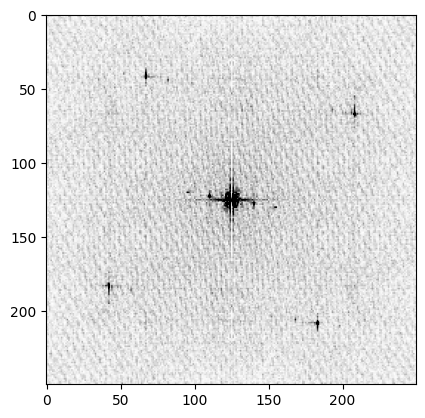

In [9]:
to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+4*s2])

# part 2
## (reconstruction then drift correction)

1.0000000061035157


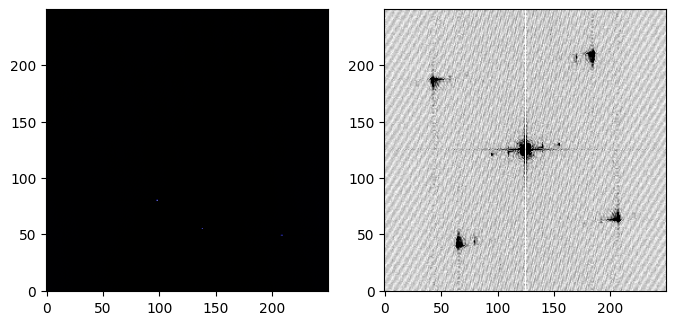

In [10]:
dfc.display(t.z)
t_z = t.z

getcontext().prec = 28  # Set the precision you need

decimal_arr = [Decimal(str(x)) for x in t.z.flatten()]
average = sum(decimal_arr) / Decimal(len(decimal_arr))
result = [x / average for x in decimal_arr]
result_arr = np.array(result, dtype=float).reshape(t.z.shape)
print(mean(result_arr))
nx, ny = shape(t.Z)
b = test.T.flat[ri] # using same ri defined above!

In [11]:
testsparse = zeros_like(t.Z)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

Iteration 1:
  fx = 311229968.284731, xnorm = 249.978404, gnorm = 35283.582679, step = 0.000028, k = 1, ls = 1

Iteration 2:
  fx = 159087950.836163, xnorm = 11217.919545, gnorm = 25208.081962, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 918879.582153, xnorm = 18802.797595, gnorm = 1652.611796, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 236206.758788, xnorm = 18720.304997, gnorm = 51.458838, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 235514.492585, xnorm = 18718.135633, gnorm = 10.528759, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 235454.256256, xnorm = 18717.049489, gnorm = 10.585978, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 233641.556969, xnorm = 18647.406652, gnorm = 94.570255, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 232175.629112, xnorm = 18630.531255, gnorm = 68.225899, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 231119.618373, xnorm = 18632.023950, gnorm = 45.381886, step = 0.125000, k = 9, ls = 4

Iteration 10:
  

Iteration 77:
  fx = 214967.236370, xnorm = 18423.149742, gnorm = 23.945300, step = 0.500000, k = 77, ls = 2

Iteration 78:
  fx = 214796.291566, xnorm = 18420.734597, gnorm = 26.569064, step = 0.500000, k = 78, ls = 2

Iteration 79:
  fx = 214565.471483, xnorm = 18419.931862, gnorm = 23.859977, step = 0.500000, k = 79, ls = 2

Iteration 80:
  fx = 214396.393619, xnorm = 18417.578169, gnorm = 26.573234, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 214165.053637, xnorm = 18416.862260, gnorm = 23.748921, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 213998.264441, xnorm = 18414.526456, gnorm = 26.587913, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 213766.612941, xnorm = 18413.883805, gnorm = 23.622229, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 213602.023032, xnorm = 18411.588714, gnorm = 26.549035, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 213371.185195, xnorm = 18411.026721, gnorm = 23.526840, step = 0.500000, k = 85, ls = 2

Iteration 

Iteration 157:
  fx = 200594.946505, xnorm = 18378.956886, gnorm = 17.799035, step = 0.500000, k = 157, ls = 2

Iteration 158:
  fx = 200526.207798, xnorm = 18377.887648, gnorm = 27.491757, step = 0.500000, k = 158, ls = 2

Iteration 159:
  fx = 200276.698899, xnorm = 18379.707683, gnorm = 17.752121, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 200209.030239, xnorm = 18378.692608, gnorm = 27.553894, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 199958.385498, xnorm = 18380.540853, gnorm = 17.707771, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 199893.265938, xnorm = 18379.568891, gnorm = 27.735763, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 199639.829911, xnorm = 18381.479686, gnorm = 17.594070, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 199575.759761, xnorm = 18380.539082, gnorm = 27.809268, step = 0.500000, k = 164, ls = 2

Iteration 165:
  fx = 199321.625736, xnorm = 18382.499309, gnorm = 17.444783, step = 0.500000, k = 165, 

Iteration 236:
  fx = 189150.449464, xnorm = 18461.184499, gnorm = 26.682357, step = 0.500000, k = 236, ls = 2

Iteration 237:
  fx = 188922.858799, xnorm = 18463.523772, gnorm = 14.670505, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 188892.646010, xnorm = 18464.514984, gnorm = 26.653830, step = 0.500000, k = 238, ls = 2

Iteration 239:
  fx = 188665.254793, xnorm = 18466.897357, gnorm = 14.552076, step = 0.500000, k = 239, ls = 2

Iteration 240:
  fx = 188636.101664, xnorm = 18467.918946, gnorm = 26.642330, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 188409.382406, xnorm = 18470.261846, gnorm = 14.447871, step = 0.500000, k = 241, ls = 2

Iteration 242:
  fx = 188379.512714, xnorm = 18471.363324, gnorm = 26.474066, step = 0.500000, k = 242, ls = 2

Iteration 243:
  fx = 188156.259178, xnorm = 18473.668198, gnorm = 14.401750, step = 0.500000, k = 243, ls = 2

Iteration 244:
  fx = 188126.120187, xnorm = 18474.859473, gnorm = 26.340271, step = 0.500000, k = 244, 

Iteration 314:
  fx = 180354.402100, xnorm = 18619.224912, gnorm = 22.985156, step = 0.500000, k = 314, ls = 2

Iteration 315:
  fx = 180184.373881, xnorm = 18621.613706, gnorm = 12.826540, step = 0.500000, k = 315, ls = 2

Iteration 316:
  fx = 180158.410003, xnorm = 18623.788550, gnorm = 22.817520, step = 0.500000, k = 316, ls = 2

Iteration 317:
  fx = 179991.323507, xnorm = 18626.233896, gnorm = 12.799842, step = 0.500000, k = 317, ls = 2

Iteration 318:
  fx = 179966.187711, xnorm = 18628.414147, gnorm = 22.806292, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 179799.333755, xnorm = 18630.853048, gnorm = 12.748372, step = 0.500000, k = 319, ls = 2

Iteration 320:
  fx = 179774.003318, xnorm = 18633.121739, gnorm = 22.698577, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 179608.626110, xnorm = 18635.473668, gnorm = 12.706802, step = 0.500000, k = 321, ls = 2

Iteration 322:
  fx = 179583.198537, xnorm = 18637.783277, gnorm = 22.592772, step = 0.500000, k = 322, 

Iteration 390:
  fx = 173780.980312, xnorm = 18805.726338, gnorm = 20.311651, step = 0.500000, k = 390, ls = 2

Iteration 391:
  fx = 173647.691978, xnorm = 18808.285790, gnorm = 11.336952, step = 0.500000, k = 391, ls = 2

Iteration 392:
  fx = 173628.244550, xnorm = 18810.892953, gnorm = 20.263926, step = 0.500000, k = 392, ls = 2

Iteration 393:
  fx = 173495.577038, xnorm = 18813.482805, gnorm = 11.313011, step = 0.500000, k = 393, ls = 2

Iteration 394:
  fx = 173476.657173, xnorm = 18816.078017, gnorm = 20.248226, step = 0.500000, k = 394, ls = 2

Iteration 395:
  fx = 173343.880218, xnorm = 18818.685949, gnorm = 11.236036, step = 0.500000, k = 395, ls = 2

Iteration 396:
  fx = 173325.894080, xnorm = 18821.252251, gnorm = 20.228685, step = 0.500000, k = 396, ls = 2

Iteration 397:
  fx = 173193.139153, xnorm = 18823.875957, gnorm = 11.068855, step = 0.500000, k = 397, ls = 2

Iteration 398:
  fx = 173174.759417, xnorm = 18826.376733, gnorm = 20.025455, step = 0.500000, k = 398, 

Iteration 466:
  fx = 168585.303328, xnorm = 19005.885234, gnorm = 17.822710, step = 0.500000, k = 466, ls = 2

Iteration 467:
  fx = 168481.945243, xnorm = 19008.641655, gnorm = 10.220178, step = 0.500000, k = 467, ls = 2

Iteration 468:
  fx = 168464.858217, xnorm = 19011.199465, gnorm = 17.852874, step = 0.500000, k = 468, ls = 2

Iteration 469:
  fx = 168360.884754, xnorm = 19013.960298, gnorm = 10.141897, step = 0.500000, k = 469, ls = 2

Iteration 470:
  fx = 168344.641905, xnorm = 19016.518579, gnorm = 17.873081, step = 0.500000, k = 470, ls = 2

Iteration 471:
  fx = 168240.297887, xnorm = 19019.286223, gnorm = 10.056904, step = 0.500000, k = 471, ls = 2

Iteration 472:
  fx = 168224.283687, xnorm = 19021.821920, gnorm = 17.808329, step = 0.500000, k = 472, ls = 2

Iteration 473:
  fx = 168120.683249, xnorm = 19024.611823, gnorm = 10.023576, step = 0.500000, k = 473, ls = 2

Iteration 474:
  fx = 168104.638920, xnorm = 19027.142155, gnorm = 17.747124, step = 0.500000, k = 474, 

Iteration 542:
  fx = 164417.422713, xnorm = 19209.061850, gnorm = 15.983983, step = 0.500000, k = 542, ls = 2

Iteration 543:
  fx = 164333.555457, xnorm = 19211.987185, gnorm = 9.069638, step = 0.500000, k = 543, ls = 2

Iteration 544:
  fx = 164320.138508, xnorm = 19214.399278, gnorm = 15.952957, step = 0.500000, k = 544, ls = 2

Iteration 545:
  fx = 164236.625599, xnorm = 19217.328611, gnorm = 9.097819, step = 0.500000, k = 545, ls = 2

Iteration 546:
  fx = 164223.165183, xnorm = 19219.768139, gnorm = 15.939036, step = 0.500000, k = 546, ls = 2

Iteration 547:
  fx = 164139.738023, xnorm = 19222.698031, gnorm = 9.086930, step = 0.500000, k = 547, ls = 2

Iteration 548:
  fx = 164126.539403, xnorm = 19225.145391, gnorm = 15.945356, step = 0.500000, k = 548, ls = 2

Iteration 549:
  fx = 164042.778561, xnorm = 19228.063663, gnorm = 9.002464, step = 0.500000, k = 549, ls = 2

Iteration 550:
  fx = 164029.707416, xnorm = 19230.543960, gnorm = 15.879429, step = 0.500000, k = 550, ls =

Iteration 618:
  fx = 161057.553849, xnorm = 19409.423156, gnorm = 14.285509, step = 0.500000, k = 618, ls = 2

Iteration 619:
  fx = 160990.648022, xnorm = 19412.314022, gnorm = 8.361547, step = 0.500000, k = 619, ls = 2

Iteration 620:
  fx = 160978.327522, xnorm = 19414.644956, gnorm = 14.298834, step = 0.500000, k = 620, ls = 2

Iteration 621:
  fx = 160911.127261, xnorm = 19417.496989, gnorm = 8.249354, step = 0.500000, k = 621, ls = 2

Iteration 622:
  fx = 160899.630181, xnorm = 19419.841778, gnorm = 14.239241, step = 0.500000, k = 622, ls = 2

Iteration 623:
  fx = 160832.706997, xnorm = 19422.650955, gnorm = 8.141157, step = 0.500000, k = 623, ls = 2

Iteration 624:
  fx = 160821.335329, xnorm = 19424.954517, gnorm = 14.142677, step = 0.500000, k = 624, ls = 2

Iteration 625:
  fx = 160755.307953, xnorm = 19427.780274, gnorm = 8.158135, step = 0.500000, k = 625, ls = 2

Iteration 626:
  fx = 160744.003356, xnorm = 19430.080161, gnorm = 14.136597, step = 0.500000, k = 626, ls =

Iteration 693:
  fx = 158327.588836, xnorm = 19600.230753, gnorm = 7.537779, step = 0.500000, k = 693, ls = 2

Iteration 694:
  fx = 158317.517059, xnorm = 19602.416130, gnorm = 12.879892, step = 0.500000, k = 694, ls = 2

Iteration 695:
  fx = 158262.644395, xnorm = 19605.182656, gnorm = 7.483778, step = 0.500000, k = 695, ls = 2

Iteration 696:
  fx = 158252.566776, xnorm = 19607.343825, gnorm = 12.822891, step = 0.500000, k = 696, ls = 2

Iteration 697:
  fx = 158198.283717, xnorm = 19610.114253, gnorm = 7.530139, step = 0.500000, k = 697, ls = 2

Iteration 698:
  fx = 158187.835101, xnorm = 19612.263142, gnorm = 12.764347, step = 0.500000, k = 698, ls = 2

Iteration 699:
  fx = 158134.027190, xnorm = 19615.036983, gnorm = 7.540249, step = 0.500000, k = 699, ls = 2

Iteration 700:
  fx = 158123.501530, xnorm = 19617.163234, gnorm = 12.734188, step = 0.500000, k = 700, ls = 2

Iteration 701:
  fx = 158069.952386, xnorm = 19619.962626, gnorm = 7.518977, step = 0.500000, k = 701, ls = 

Iteration 768:
  fx = 156137.454250, xnorm = 19779.026978, gnorm = 11.628154, step = 0.500000, k = 768, ls = 2

Iteration 769:
  fx = 156092.340455, xnorm = 19781.690720, gnorm = 6.881008, step = 0.500000, k = 769, ls = 2

Iteration 770:
  fx = 156083.660899, xnorm = 19783.655782, gnorm = 11.612665, step = 0.500000, k = 770, ls = 2

Iteration 771:
  fx = 156038.731946, xnorm = 19786.330891, gnorm = 6.874013, step = 0.500000, k = 771, ls = 2

Iteration 772:
  fx = 156029.727690, xnorm = 19788.280402, gnorm = 11.546396, step = 0.500000, k = 772, ls = 2

Iteration 773:
  fx = 155985.370502, xnorm = 19790.947992, gnorm = 6.892113, step = 0.500000, k = 773, ls = 2

Iteration 774:
  fx = 155976.307282, xnorm = 19792.909701, gnorm = 11.558183, step = 0.500000, k = 774, ls = 2

Iteration 775:
  fx = 155931.885927, xnorm = 19795.576220, gnorm = 6.865742, step = 0.500000, k = 775, ls = 2

Iteration 776:
  fx = 155923.050384, xnorm = 19797.539604, gnorm = 11.565010, step = 0.500000, k = 776, ls =

Iteration 843:
  fx = 154264.694474, xnorm = 19948.952816, gnorm = 6.312220, step = 0.500000, k = 843, ls = 2

Iteration 844:
  fx = 154257.314151, xnorm = 19950.797502, gnorm = 10.675992, step = 0.500000, k = 844, ls = 2

Iteration 845:
  fx = 154219.280346, xnorm = 19953.385121, gnorm = 6.305447, step = 0.500000, k = 845, ls = 2

Iteration 846:
  fx = 154211.691019, xnorm = 19955.210969, gnorm = 10.624588, step = 0.500000, k = 846, ls = 2

Iteration 847:
  fx = 154174.144457, xnorm = 19957.799482, gnorm = 6.333756, step = 0.500000, k = 847, ls = 2

Iteration 848:
  fx = 154166.554944, xnorm = 19959.613925, gnorm = 10.625570, step = 0.500000, k = 848, ls = 2

Iteration 849:
  fx = 154128.982177, xnorm = 19962.213190, gnorm = 6.302700, step = 0.500000, k = 849, ls = 2

Iteration 850:
  fx = 154121.473544, xnorm = 19964.031518, gnorm = 10.612898, step = 0.500000, k = 850, ls = 2

Iteration 851:
  fx = 154083.957767, xnorm = 19966.623327, gnorm = 6.284086, step = 0.500000, k = 851, ls = 

Iteration 918:
  fx = 152704.950844, xnorm = 20109.866840, gnorm = 9.755375, step = 0.500000, k = 918, ls = 2

Iteration 919:
  fx = 152673.036390, xnorm = 20112.348308, gnorm = 5.860478, step = 0.500000, k = 919, ls = 2

Iteration 920:
  fx = 152666.466942, xnorm = 20114.037504, gnorm = 9.745753, step = 0.500000, k = 920, ls = 2

Iteration 921:
  fx = 152634.610736, xnorm = 20116.506095, gnorm = 5.835746, step = 0.500000, k = 921, ls = 2

Iteration 922:
  fx = 152627.920747, xnorm = 20118.178214, gnorm = 9.680163, step = 0.500000, k = 922, ls = 2

Iteration 923:
  fx = 152596.604166, xnorm = 20120.661238, gnorm = 5.890198, step = 0.500000, k = 923, ls = 2

Iteration 924:
  fx = 152589.596657, xnorm = 20122.314179, gnorm = 9.612478, step = 0.500000, k = 924, ls = 2

Iteration 925:
  fx = 152558.681527, xnorm = 20124.795900, gnorm = 5.871425, step = 0.500000, k = 925, ls = 2

Iteration 926:
  fx = 152551.695882, xnorm = 20126.425057, gnorm = 9.581776, step = 0.500000, k = 926, ls = 2

I

Iteration 992:
  fx = 151387.102827, xnorm = 20258.871499, gnorm = 8.961255, step = 0.500000, k = 992, ls = 2

Iteration 993:
  fx = 151360.060103, xnorm = 20261.240540, gnorm = 5.452069, step = 0.500000, k = 993, ls = 2

Iteration 994:
  fx = 151353.964438, xnorm = 20262.782369, gnorm = 8.935725, step = 0.500000, k = 994, ls = 2

Iteration 995:
  fx = 151327.117276, xnorm = 20265.136748, gnorm = 5.425986, step = 0.500000, k = 995, ls = 2

Iteration 996:
  fx = 151321.053040, xnorm = 20266.679386, gnorm = 8.886978, step = 0.500000, k = 996, ls = 2

Iteration 997:
  fx = 151294.571575, xnorm = 20269.025315, gnorm = 5.426244, step = 0.500000, k = 997, ls = 2

Iteration 998:
  fx = 151288.376644, xnorm = 20270.561514, gnorm = 8.828381, step = 0.500000, k = 998, ls = 2

Iteration 999:
  fx = 151262.313045, xnorm = 20272.886116, gnorm = 5.454222, step = 0.500000, k = 999, ls = 2

Iteration 1000:
  fx = 151256.004104, xnorm = 20274.432344, gnorm = 8.802463, step = 0.500000, k = 1000, ls = 2


Iteration 1066:
  fx = 150251.824536, xnorm = 20399.858922, gnorm = 8.265627, step = 0.500000, k = 1066, ls = 2

Iteration 1067:
  fx = 150228.849122, xnorm = 20402.063646, gnorm = 5.066837, step = 0.500000, k = 1067, ls = 2

Iteration 1068:
  fx = 150223.621164, xnorm = 20403.541057, gnorm = 8.250551, step = 0.500000, k = 1068, ls = 2

Iteration 1069:
  fx = 150200.685387, xnorm = 20405.755056, gnorm = 5.047019, step = 0.500000, k = 1069, ls = 2

Iteration 1070:
  fx = 150195.565477, xnorm = 20407.227905, gnorm = 8.256037, step = 0.500000, k = 1070, ls = 2

Iteration 1071:
  fx = 150172.653135, xnorm = 20409.433802, gnorm = 5.053497, step = 0.500000, k = 1071, ls = 2

Iteration 1072:
  fx = 150167.505789, xnorm = 20410.917176, gnorm = 8.249384, step = 0.500000, k = 1072, ls = 2

Iteration 1073:
  fx = 150144.595248, xnorm = 20413.122717, gnorm = 5.049320, step = 0.500000, k = 1073, ls = 2

Iteration 1074:
  fx = 150139.340982, xnorm = 20414.605873, gnorm = 8.214210, step = 0.500000, k

Iteration 1139:
  fx = 149285.169907, xnorm = 20530.647145, gnorm = 4.758471, step = 0.500000, k = 1139, ls = 2

Iteration 1140:
  fx = 149280.344111, xnorm = 20531.966683, gnorm = 7.589452, step = 0.500000, k = 1140, ls = 2

Iteration 1141:
  fx = 149260.917828, xnorm = 20534.079628, gnorm = 4.722880, step = 0.500000, k = 1141, ls = 2

Iteration 1142:
  fx = 149256.179685, xnorm = 20535.397323, gnorm = 7.556295, step = 0.500000, k = 1142, ls = 2

Iteration 1143:
  fx = 149236.925783, xnorm = 20537.494602, gnorm = 4.710154, step = 0.500000, k = 1143, ls = 2

Iteration 1144:
  fx = 149232.068523, xnorm = 20538.804127, gnorm = 7.501886, step = 0.500000, k = 1144, ls = 2

Iteration 1145:
  fx = 149213.151837, xnorm = 20540.894205, gnorm = 4.756879, step = 0.500000, k = 1145, ls = 2

Iteration 1146:
  fx = 149208.158947, xnorm = 20542.211428, gnorm = 7.499212, step = 0.500000, k = 1146, ls = 2

Iteration 1147:
  fx = 149189.284748, xnorm = 20544.310052, gnorm = 4.778750, step = 0.500000, k

Iteration 1213:
  fx = 148448.264041, xnorm = 20653.742113, gnorm = 4.322687, step = 0.500000, k = 1213, ls = 2

Iteration 1214:
  fx = 148444.442503, xnorm = 20654.996179, gnorm = 7.132870, step = 0.500000, k = 1214, ls = 2

Iteration 1215:
  fx = 148427.236604, xnorm = 20656.956485, gnorm = 4.338117, step = 0.500000, k = 1215, ls = 2

Iteration 1216:
  fx = 148423.379606, xnorm = 20658.207939, gnorm = 7.135527, step = 0.500000, k = 1216, ls = 2

Iteration 1217:
  fx = 148406.201475, xnorm = 20660.175664, gnorm = 4.359176, step = 0.500000, k = 1217, ls = 2

Iteration 1218:
  fx = 148402.250174, xnorm = 20661.435484, gnorm = 7.109577, step = 0.500000, k = 1218, ls = 2

Iteration 1219:
  fx = 148385.203565, xnorm = 20663.399406, gnorm = 4.350384, step = 0.500000, k = 1219, ls = 2

Iteration 1220:
  fx = 148381.315776, xnorm = 20664.658123, gnorm = 7.127177, step = 0.500000, k = 1220, ls = 2

Iteration 1221:
  fx = 148364.197065, xnorm = 20666.629185, gnorm = 4.336025, step = 0.500000, k

Iteration 1286:
  fx = 147735.615741, xnorm = 20767.517703, gnorm = 6.586461, step = 0.500000, k = 1286, ls = 2

Iteration 1287:
  fx = 147720.968095, xnorm = 20769.376480, gnorm = 4.123853, step = 0.500000, k = 1287, ls = 2

Iteration 1288:
  fx = 147717.347029, xnorm = 20770.529210, gnorm = 6.586091, step = 0.500000, k = 1288, ls = 2

Iteration 1289:
  fx = 147702.714653, xnorm = 20772.384082, gnorm = 4.113931, step = 0.500000, k = 1289, ls = 2

Iteration 1290:
  fx = 147699.088022, xnorm = 20773.539175, gnorm = 6.569596, step = 0.500000, k = 1290, ls = 2

Iteration 1291:
  fx = 147684.529864, xnorm = 20775.387619, gnorm = 4.093141, step = 0.500000, k = 1291, ls = 2

Iteration 1292:
  fx = 147680.881340, xnorm = 20776.542012, gnorm = 6.544244, step = 0.500000, k = 1292, ls = 2

Iteration 1293:
  fx = 147666.435423, xnorm = 20778.391178, gnorm = 4.100964, step = 0.500000, k = 1293, ls = 2

Iteration 1294:
  fx = 147662.845302, xnorm = 20779.536809, gnorm = 6.546136, step = 0.500000, k

Iteration 1360:
  fx = 147094.713631, xnorm = 20876.023514, gnorm = 6.307023, step = 0.500000, k = 1360, ls = 2

Iteration 1361:
  fx = 147081.323965, xnorm = 20877.765904, gnorm = 3.816018, step = 0.500000, k = 1361, ls = 2

Iteration 1362:
  fx = 147078.288202, xnorm = 20878.870089, gnorm = 6.292572, step = 0.500000, k = 1362, ls = 2

Iteration 1363:
  fx = 147064.988757, xnorm = 20880.606354, gnorm = 3.806118, step = 0.500000, k = 1363, ls = 2

Iteration 1364:
  fx = 147061.869483, xnorm = 20881.719150, gnorm = 6.232572, step = 0.500000, k = 1364, ls = 2

Iteration 1365:
  fx = 147048.842590, xnorm = 20883.454335, gnorm = 3.820808, step = 0.500000, k = 1365, ls = 2

Iteration 1366:
  fx = 147045.743090, xnorm = 20884.555433, gnorm = 6.225007, step = 0.500000, k = 1366, ls = 2

Iteration 1367:
  fx = 147032.725260, xnorm = 20886.291354, gnorm = 3.827220, step = 0.500000, k = 1367, ls = 2

Iteration 1368:
  fx = 147029.609062, xnorm = 20887.388949, gnorm = 6.224149, step = 0.500000, k

Iteration 1434:
  fx = 146528.728661, xnorm = 20978.065243, gnorm = 5.802204, step = 0.500000, k = 1434, ls = 2

Iteration 1435:
  fx = 146517.359396, xnorm = 20979.730532, gnorm = 3.620745, step = 0.500000, k = 1435, ls = 2

Iteration 1436:
  fx = 146514.469280, xnorm = 20980.736100, gnorm = 5.805648, step = 0.500000, k = 1436, ls = 2

Iteration 1437:
  fx = 146503.107802, xnorm = 20982.401670, gnorm = 3.612021, step = 0.500000, k = 1437, ls = 2

Iteration 1438:
  fx = 146500.195083, xnorm = 20983.404670, gnorm = 5.783677, step = 0.500000, k = 1438, ls = 2

Iteration 1439:
  fx = 146488.939006, xnorm = 20985.066393, gnorm = 3.615171, step = 0.500000, k = 1439, ls = 2

Iteration 1440:
  fx = 146485.971735, xnorm = 20986.072467, gnorm = 5.762598, step = 0.500000, k = 1440, ls = 2

Iteration 1441:
  fx = 146474.804233, xnorm = 20987.729964, gnorm = 3.630028, step = 0.500000, k = 1441, ls = 2

Iteration 1442:
  fx = 146471.907194, xnorm = 20988.724781, gnorm = 5.774288, step = 0.500000, k

Iteration 1507:
  fx = 146036.565691, xnorm = 21072.645233, gnorm = 3.406075, step = 0.500000, k = 1507, ls = 2

Iteration 1508:
  fx = 146033.972249, xnorm = 21073.553175, gnorm = 5.426276, step = 0.500000, k = 1508, ls = 2

Iteration 1509:
  fx = 146024.033895, xnorm = 21075.150392, gnorm = 3.416373, step = 0.500000, k = 1509, ls = 2

Iteration 1510:
  fx = 146021.431172, xnorm = 21076.061357, gnorm = 5.418851, step = 0.500000, k = 1510, ls = 2

Iteration 1511:
  fx = 146011.528382, xnorm = 21077.662015, gnorm = 3.419729, step = 0.500000, k = 1511, ls = 2

Iteration 1512:
  fx = 146008.932503, xnorm = 21078.575763, gnorm = 5.409434, step = 0.500000, k = 1512, ls = 2

Iteration 1513:
  fx = 145999.044305, xnorm = 21080.157266, gnorm = 3.396143, step = 0.500000, k = 1513, ls = 2

Iteration 1514:
  fx = 145996.488449, xnorm = 21081.082334, gnorm = 5.404772, step = 0.500000, k = 1514, ls = 2

Iteration 1515:
  fx = 145986.614015, xnorm = 21082.655086, gnorm = 3.381621, step = 0.500000, k

Iteration 1580:
  fx = 145606.857975, xnorm = 21161.304101, gnorm = 5.179082, step = 0.500000, k = 1580, ls = 2

Iteration 1581:
  fx = 145597.800718, xnorm = 21162.792565, gnorm = 3.190720, step = 0.500000, k = 1581, ls = 2

Iteration 1582:
  fx = 145595.624138, xnorm = 21163.685052, gnorm = 5.163364, step = 0.500000, k = 1582, ls = 2

Iteration 1583:
  fx = 145586.617417, xnorm = 21165.169831, gnorm = 3.186758, step = 0.500000, k = 1583, ls = 2

Iteration 1584:
  fx = 145584.406130, xnorm = 21166.067906, gnorm = 5.143851, step = 0.500000, k = 1584, ls = 2

Iteration 1585:
  fx = 145575.485595, xnorm = 21167.552120, gnorm = 3.191018, step = 0.500000, k = 1585, ls = 2

Iteration 1586:
  fx = 145573.286847, xnorm = 21168.443458, gnorm = 5.140135, step = 0.500000, k = 1586, ls = 2

Iteration 1587:
  fx = 145564.369560, xnorm = 21169.922261, gnorm = 3.183333, step = 0.500000, k = 1587, ls = 2

Iteration 1588:
  fx = 145562.168868, xnorm = 21170.816311, gnorm = 5.127909, step = 0.500000, k

Iteration 1661:
  fx = 145177.064954, xnorm = 21255.065426, gnorm = 3.015148, step = 0.500000, k = 1661, ls = 2

Iteration 1662:
  fx = 145175.109880, xnorm = 21255.876080, gnorm = 4.825899, step = 0.500000, k = 1662, ls = 2

Iteration 1663:
  fx = 145167.224253, xnorm = 21257.283502, gnorm = 2.971473, step = 0.500000, k = 1663, ls = 2

Iteration 1664:
  fx = 145165.294509, xnorm = 21258.088593, gnorm = 4.805035, step = 0.500000, k = 1664, ls = 2

Iteration 1665:
  fx = 145157.499815, xnorm = 21259.483801, gnorm = 2.970604, step = 0.500000, k = 1665, ls = 2

Iteration 1666:
  fx = 145155.539046, xnorm = 21260.296865, gnorm = 4.786842, step = 0.500000, k = 1666, ls = 2

Iteration 1667:
  fx = 145147.809900, xnorm = 21261.692180, gnorm = 2.972832, step = 0.500000, k = 1667, ls = 2

Iteration 1668:
  fx = 145145.811291, xnorm = 21262.488217, gnorm = 4.763020, step = 0.500000, k = 1668, ls = 2

Iteration 1669:
  fx = 145138.167633, xnorm = 21263.890030, gnorm = 2.996040, step = 0.500000, k

Iteration 1734:
  fx = 144843.405894, xnorm = 21333.189025, gnorm = 4.504211, step = 0.500000, k = 1734, ls = 2

Iteration 1735:
  fx = 144836.508430, xnorm = 21334.502811, gnorm = 2.814813, step = 0.500000, k = 1735, ls = 2

Iteration 1736:
  fx = 144834.709759, xnorm = 21335.256552, gnorm = 4.469421, step = 0.500000, k = 1736, ls = 2

Iteration 1737:
  fx = 144827.931042, xnorm = 21336.563176, gnorm = 2.822003, step = 0.500000, k = 1737, ls = 2

Iteration 1738:
  fx = 144826.070817, xnorm = 21337.319413, gnorm = 4.450608, step = 0.500000, k = 1738, ls = 2

Iteration 1739:
  fx = 144819.374679, xnorm = 21338.637503, gnorm = 2.860994, step = 0.500000, k = 1739, ls = 2

Iteration 1740:
  fx = 144817.477430, xnorm = 21339.396035, gnorm = 4.461153, step = 0.500000, k = 1740, ls = 2

Iteration 1741:
  fx = 144810.750106, xnorm = 21340.714754, gnorm = 2.862278, step = 0.500000, k = 1741, ls = 2

Iteration 1742:
  fx = 144808.880986, xnorm = 21341.480574, gnorm = 4.474519, step = 0.500000, k

Iteration 1807:
  fx = 144541.744309, xnorm = 21407.112074, gnorm = 2.679019, step = 0.500000, k = 1807, ls = 2

Iteration 1808:
  fx = 144540.133786, xnorm = 21407.824656, gnorm = 4.250214, step = 0.500000, k = 1808, ls = 2

Iteration 1809:
  fx = 144533.988147, xnorm = 21409.053901, gnorm = 2.656792, step = 0.500000, k = 1809, ls = 2

Iteration 1810:
  fx = 144532.430554, xnorm = 21409.769345, gnorm = 4.246646, step = 0.500000, k = 1810, ls = 2

Iteration 1811:
  fx = 144526.280817, xnorm = 21410.996584, gnorm = 2.647612, step = 0.500000, k = 1811, ls = 2

Iteration 1812:
  fx = 144524.725694, xnorm = 21411.711807, gnorm = 4.234852, step = 0.500000, k = 1812, ls = 2

Iteration 1813:
  fx = 144518.624499, xnorm = 21412.934894, gnorm = 2.655397, step = 0.500000, k = 1813, ls = 2

Iteration 1814:
  fx = 144517.054785, xnorm = 21413.649336, gnorm = 4.225369, step = 0.500000, k = 1814, ls = 2

Iteration 1815:
  fx = 144510.977755, xnorm = 21414.873143, gnorm = 2.646459, step = 0.500000, k

Iteration 1880:
  fx = 144275.881464, xnorm = 21476.277336, gnorm = 4.052225, step = 0.500000, k = 1880, ls = 2

Iteration 1881:
  fx = 144270.333579, xnorm = 21477.450526, gnorm = 2.525857, step = 0.500000, k = 1881, ls = 2

Iteration 1882:
  fx = 144268.907202, xnorm = 21478.141590, gnorm = 4.050609, step = 0.500000, k = 1882, ls = 2

Iteration 1883:
  fx = 144263.350279, xnorm = 21479.303935, gnorm = 2.511770, step = 0.500000, k = 1883, ls = 2

Iteration 1884:
  fx = 144261.964351, xnorm = 21480.001241, gnorm = 4.061897, step = 0.500000, k = 1884, ls = 2

Iteration 1885:
  fx = 144256.368056, xnorm = 21481.156500, gnorm = 2.498392, step = 0.500000, k = 1885, ls = 2

Iteration 1886:
  fx = 144255.012225, xnorm = 21481.863342, gnorm = 4.065732, step = 0.500000, k = 1886, ls = 2

Iteration 1887:
  fx = 144249.410876, xnorm = 21483.015614, gnorm = 2.493689, step = 0.500000, k = 1887, ls = 2

Iteration 1888:
  fx = 144248.084311, xnorm = 21483.718020, gnorm = 4.070783, step = 0.500000, k

Iteration 1953:
  fx = 144032.385607, xnorm = 21542.324190, gnorm = 2.410865, step = 0.500000, k = 1953, ls = 2

Iteration 1954:
  fx = 144031.025610, xnorm = 21542.979319, gnorm = 3.773421, step = 0.500000, k = 1954, ls = 2

Iteration 1955:
  fx = 144026.206548, xnorm = 21544.046904, gnorm = 2.408741, step = 0.500000, k = 1955, ls = 2

Iteration 1956:
  fx = 144024.839795, xnorm = 21544.702184, gnorm = 3.765044, step = 0.500000, k = 1956, ls = 2

Iteration 1957:
  fx = 144020.051128, xnorm = 21545.772003, gnorm = 2.419823, step = 0.500000, k = 1957, ls = 2

Iteration 1958:
  fx = 144018.690063, xnorm = 21546.424150, gnorm = 3.766556, step = 0.500000, k = 1958, ls = 2

Iteration 1959:
  fx = 144013.886860, xnorm = 21547.493650, gnorm = 2.402465, step = 0.500000, k = 1959, ls = 2

Iteration 1960:
  fx = 144012.560114, xnorm = 21548.137268, gnorm = 3.768379, step = 0.500000, k = 1960, ls = 2

Iteration 1961:
  fx = 144007.737627, xnorm = 21549.207401, gnorm = 2.381541, step = 0.500000, k

Iteration 2052:
  fx = 143747.436400, xnorm = 21624.471374, gnorm = 3.547921, step = 0.500000, k = 2052, ls = 2

Iteration 2053:
  fx = 143743.163727, xnorm = 21625.467114, gnorm = 2.210313, step = 0.500000, k = 2053, ls = 2

Iteration 2054:
  fx = 143742.069659, xnorm = 21626.065775, gnorm = 3.546331, step = 0.500000, k = 2054, ls = 2

Iteration 2055:
  fx = 143737.817120, xnorm = 21627.058231, gnorm = 2.215503, step = 0.500000, k = 2055, ls = 2

Iteration 2056:
  fx = 143736.711646, xnorm = 21627.654205, gnorm = 3.541610, step = 0.500000, k = 2056, ls = 2

Iteration 2057:
  fx = 143732.473697, xnorm = 21628.649101, gnorm = 2.217928, step = 0.500000, k = 2057, ls = 2

Iteration 2058:
  fx = 143731.363712, xnorm = 21629.248479, gnorm = 3.537915, step = 0.500000, k = 2058, ls = 2

Iteration 2059:
  fx = 143727.130365, xnorm = 21630.240238, gnorm = 2.212199, step = 0.500000, k = 2059, ls = 2

Iteration 2060:
  fx = 143726.032393, xnorm = 21630.838372, gnorm = 3.530722, step = 0.500000, k

Iteration 2126:
  fx = 143557.143237, xnorm = 21682.325865, gnorm = 3.435095, step = 0.500000, k = 2126, ls = 2

Iteration 2127:
  fx = 143553.158046, xnorm = 21683.292682, gnorm = 2.092976, step = 0.500000, k = 2127, ls = 2

Iteration 2128:
  fx = 143552.228594, xnorm = 21683.858861, gnorm = 3.430044, step = 0.500000, k = 2128, ls = 2

Iteration 2129:
  fx = 143548.248684, xnorm = 21684.820203, gnorm = 2.078824, step = 0.500000, k = 2129, ls = 2

Iteration 2130:
  fx = 143547.310337, xnorm = 21685.382401, gnorm = 3.404648, step = 0.500000, k = 2130, ls = 2

Iteration 2131:
  fx = 143543.389813, xnorm = 21686.341883, gnorm = 2.082526, step = 0.500000, k = 2131, ls = 2

Iteration 2132:
  fx = 143542.433093, xnorm = 21686.897528, gnorm = 3.387365, step = 0.500000, k = 2132, ls = 2

Iteration 2133:
  fx = 143538.566299, xnorm = 21687.854353, gnorm = 2.089307, step = 0.500000, k = 2133, ls = 2

Iteration 2134:
  fx = 143537.599264, xnorm = 21688.405193, gnorm = 3.378055, step = 0.500000, k

Iteration 2199:
  fx = 143386.491761, xnorm = 21736.130420, gnorm = 2.024956, step = 0.500000, k = 2199, ls = 2

Iteration 2200:
  fx = 143385.563050, xnorm = 21736.656057, gnorm = 3.205613, step = 0.500000, k = 2200, ls = 2

Iteration 2201:
  fx = 143382.084987, xnorm = 21737.543995, gnorm = 2.021515, step = 0.500000, k = 2201, ls = 2

Iteration 2202:
  fx = 143381.142889, xnorm = 21738.069239, gnorm = 3.197793, step = 0.500000, k = 2202, ls = 2

Iteration 2203:
  fx = 143377.687687, xnorm = 21738.958701, gnorm = 2.026990, step = 0.500000, k = 2203, ls = 2

Iteration 2204:
  fx = 143376.749579, xnorm = 21739.488973, gnorm = 3.199273, step = 0.500000, k = 2204, ls = 2

Iteration 2205:
  fx = 143373.284696, xnorm = 21740.374952, gnorm = 2.011736, step = 0.500000, k = 2205, ls = 2

Iteration 2206:
  fx = 143372.368166, xnorm = 21740.900990, gnorm = 3.199001, step = 0.500000, k = 2206, ls = 2

Iteration 2207:
  fx = 143368.903804, xnorm = 21741.785940, gnorm = 2.000061, step = 0.500000, k

Iteration 2272:
  fx = 143234.501483, xnorm = 21786.598356, gnorm = 3.074841, step = 0.500000, k = 2272, ls = 2

Iteration 2273:
  fx = 143231.301352, xnorm = 21787.469320, gnorm = 1.886038, step = 0.500000, k = 2273, ls = 2

Iteration 2274:
  fx = 143230.506817, xnorm = 21787.954326, gnorm = 3.061720, step = 0.500000, k = 2274, ls = 2

Iteration 2275:
  fx = 143227.332857, xnorm = 21788.822195, gnorm = 1.893429, step = 0.500000, k = 2275, ls = 2

Iteration 2276:
  fx = 143226.520261, xnorm = 21789.304296, gnorm = 3.056622, step = 0.500000, k = 2276, ls = 2

Iteration 2277:
  fx = 143223.363916, xnorm = 21790.177970, gnorm = 1.906708, step = 0.500000, k = 2277, ls = 2

Iteration 2278:
  fx = 143222.535942, xnorm = 21790.656836, gnorm = 3.060741, step = 0.500000, k = 2278, ls = 2

Iteration 2279:
  fx = 143219.378242, xnorm = 21791.531974, gnorm = 1.912350, step = 0.500000, k = 2279, ls = 2

Iteration 2280:
  fx = 143218.554148, xnorm = 21792.016136, gnorm = 3.065410, step = 0.500000, k

Iteration 2345:
  fx = 143092.630115, xnorm = 21835.359514, gnorm = 1.814981, step = 0.500000, k = 2345, ls = 2

Iteration 2346:
  fx = 143091.902990, xnorm = 21835.829686, gnorm = 2.967418, step = 0.500000, k = 2346, ls = 2

Iteration 2347:
  fx = 143088.943889, xnorm = 21836.669329, gnorm = 1.828448, step = 0.500000, k = 2347, ls = 2

Iteration 2348:
  fx = 143088.216591, xnorm = 21837.139883, gnorm = 2.969953, step = 0.500000, k = 2348, ls = 2

Iteration 2349:
  fx = 143085.242833, xnorm = 21837.979031, gnorm = 1.824132, step = 0.500000, k = 2349, ls = 2

Iteration 2350:
  fx = 143084.526777, xnorm = 21838.450974, gnorm = 2.968407, step = 0.500000, k = 2350, ls = 2

Iteration 2351:
  fx = 143081.547956, xnorm = 21839.282340, gnorm = 1.810747, step = 0.500000, k = 2351, ls = 2

Iteration 2352:
  fx = 143080.838181, xnorm = 21839.755760, gnorm = 2.959433, step = 0.500000, k = 2352, ls = 2

Iteration 2353:
  fx = 143077.872702, xnorm = 21840.581057, gnorm = 1.803303, step = 0.500000, k

Iteration 2425:
  fx = 142949.925406, xnorm = 21886.683249, gnorm = 1.717289, step = 0.500000, k = 2425, ls = 2

Iteration 2426:
  fx = 142949.309757, xnorm = 21887.149587, gnorm = 2.883012, step = 0.500000, k = 2426, ls = 2

Iteration 2427:
  fx = 142946.517937, xnorm = 21887.941681, gnorm = 1.726995, step = 0.500000, k = 2427, ls = 2

Iteration 2428:
  fx = 142945.894135, xnorm = 21888.408641, gnorm = 2.878919, step = 0.500000, k = 2428, ls = 2

Iteration 2429:
  fx = 142943.100854, xnorm = 21889.201882, gnorm = 1.719803, step = 0.500000, k = 2429, ls = 2

Iteration 2430:
  fx = 142942.488551, xnorm = 21889.662500, gnorm = 2.877409, step = 0.500000, k = 2430, ls = 2

Iteration 2431:
  fx = 142939.696204, xnorm = 21890.455827, gnorm = 1.719010, step = 0.500000, k = 2431, ls = 2

Iteration 2432:
  fx = 142939.085694, xnorm = 21890.915477, gnorm = 2.870083, step = 0.500000, k = 2432, ls = 2

Iteration 2433:
  fx = 142936.305371, xnorm = 21891.707428, gnorm = 1.714557, step = 0.500000, k

Iteration 2498:
  fx = 142832.061800, xnorm = 21931.099356, gnorm = 2.745962, step = 0.500000, k = 2498, ls = 2

Iteration 2499:
  fx = 142829.497473, xnorm = 21931.858685, gnorm = 1.623397, step = 0.500000, k = 2499, ls = 2

Iteration 2500:
  fx = 142828.955628, xnorm = 21932.287029, gnorm = 2.739876, step = 0.500000, k = 2500, ls = 2

Iteration 2501:
  fx = 142826.408109, xnorm = 21933.043012, gnorm = 1.630749, step = 0.500000, k = 2501, ls = 2

Iteration 2502:
  fx = 142825.847333, xnorm = 21933.467314, gnorm = 2.733956, step = 0.500000, k = 2502, ls = 2

Iteration 2503:
  fx = 142823.321123, xnorm = 21934.224460, gnorm = 1.650697, step = 0.500000, k = 2503, ls = 2

Iteration 2504:
  fx = 142822.749528, xnorm = 21934.654721, gnorm = 2.739548, step = 0.500000, k = 2504, ls = 2

Iteration 2505:
  fx = 142820.216156, xnorm = 21935.407263, gnorm = 1.643296, step = 0.500000, k = 2505, ls = 2

Iteration 2506:
  fx = 142819.638090, xnorm = 21935.841992, gnorm = 2.735665, step = 0.500000, k

Iteration 2598:
  fx = 142684.816382, xnorm = 21988.469946, gnorm = 2.556391, step = 0.500000, k = 2598, ls = 2

Iteration 2599:
  fx = 142682.612670, xnorm = 21989.149434, gnorm = 1.573493, step = 0.500000, k = 2599, ls = 2

Iteration 2600:
  fx = 142682.059394, xnorm = 21989.575852, gnorm = 2.548736, step = 0.500000, k = 2600, ls = 2

Iteration 2601:
  fx = 142679.862221, xnorm = 21990.251087, gnorm = 1.567145, step = 0.500000, k = 2601, ls = 2

Iteration 2602:
  fx = 142679.310424, xnorm = 21990.676826, gnorm = 2.542714, step = 0.500000, k = 2602, ls = 2

Iteration 2603:
  fx = 142677.126999, xnorm = 21991.351624, gnorm = 1.569583, step = 0.500000, k = 2603, ls = 2

Iteration 2604:
  fx = 142676.573735, xnorm = 21991.776120, gnorm = 2.541027, step = 0.500000, k = 2604, ls = 2

Iteration 2605:
  fx = 142674.392209, xnorm = 21992.454242, gnorm = 1.570124, step = 0.500000, k = 2605, ls = 2

Iteration 2606:
  fx = 142673.851615, xnorm = 21992.869536, gnorm = 2.549456, step = 0.500000, k

Iteration 2679:
  fx = 142577.228149, xnorm = 22032.088020, gnorm = 1.432141, step = 0.500000, k = 2679, ls = 2

Iteration 2680:
  fx = 142576.823663, xnorm = 22032.496712, gnorm = 2.486312, step = 0.500000, k = 2680, ls = 2

Iteration 2681:
  fx = 142574.727358, xnorm = 22033.133806, gnorm = 1.441244, step = 0.500000, k = 2681, ls = 2

Iteration 2682:
  fx = 142574.297781, xnorm = 22033.536528, gnorm = 2.475031, step = 0.500000, k = 2682, ls = 2

Iteration 2683:
  fx = 142572.231576, xnorm = 22034.183616, gnorm = 1.467572, step = 0.500000, k = 2683, ls = 2

Iteration 2684:
  fx = 142571.766816, xnorm = 22034.585222, gnorm = 2.467859, step = 0.500000, k = 2684, ls = 2

Iteration 2685:
  fx = 142569.726141, xnorm = 22035.237630, gnorm = 1.497966, step = 0.500000, k = 2685, ls = 2

Iteration 2686:
  fx = 142569.241589, xnorm = 22035.643113, gnorm = 2.468765, step = 0.500000, k = 2686, ls = 2

Iteration 2687:
  fx = 142567.193483, xnorm = 22036.292910, gnorm = 1.484954, step = 0.500000, k

Iteration 2752:
  fx = 142489.326958, xnorm = 22069.586571, gnorm = 2.403148, step = 0.500000, k = 2752, ls = 2

Iteration 2753:
  fx = 142487.364943, xnorm = 22070.204132, gnorm = 1.399756, step = 0.500000, k = 2753, ls = 2

Iteration 2754:
  fx = 142486.975350, xnorm = 22070.600522, gnorm = 2.404139, step = 0.500000, k = 2754, ls = 2

Iteration 2755:
  fx = 142485.014260, xnorm = 22071.214475, gnorm = 1.392494, step = 0.500000, k = 2755, ls = 2

Iteration 2756:
  fx = 142484.634147, xnorm = 22071.609084, gnorm = 2.404563, step = 0.500000, k = 2756, ls = 2

Iteration 2757:
  fx = 142482.673379, xnorm = 22072.222869, gnorm = 1.386928, step = 0.500000, k = 2757, ls = 2

Iteration 2758:
  fx = 142482.293626, xnorm = 22072.616305, gnorm = 2.400396, step = 0.500000, k = 2758, ls = 2

Iteration 2759:
  fx = 142480.344290, xnorm = 22073.231368, gnorm = 1.394479, step = 0.500000, k = 2759, ls = 2

Iteration 2760:
  fx = 142479.957854, xnorm = 22073.619297, gnorm = 2.398526, step = 0.500000, k

Iteration 2851:
  fx = 142376.554852, xnorm = 22118.934471, gnorm = 1.348302, step = 0.500000, k = 2851, ls = 2

Iteration 2852:
  fx = 142376.181100, xnorm = 22119.302711, gnorm = 2.289511, step = 0.500000, k = 2852, ls = 2

Iteration 2853:
  fx = 142374.410972, xnorm = 22119.898252, gnorm = 1.357232, step = 0.500000, k = 2853, ls = 2

Iteration 2854:
  fx = 142374.036587, xnorm = 22120.276076, gnorm = 2.291769, step = 0.500000, k = 2854, ls = 2

Iteration 2855:
  fx = 142372.258147, xnorm = 22120.868862, gnorm = 1.353002, step = 0.500000, k = 2855, ls = 2

Iteration 2856:
  fx = 142371.887446, xnorm = 22121.246810, gnorm = 2.291651, step = 0.500000, k = 2856, ls = 2

Iteration 2857:
  fx = 142370.108077, xnorm = 22121.834291, gnorm = 1.343247, step = 0.500000, k = 2857, ls = 2

Iteration 2858:
  fx = 142369.748062, xnorm = 22122.212374, gnorm = 2.293605, step = 0.500000, k = 2858, ls = 2

Iteration 2859:
  fx = 142367.963419, xnorm = 22122.798352, gnorm = 1.335535, step = 0.500000, k

Iteration 2932:
  fx = 142293.891493, xnorm = 22157.034213, gnorm = 2.134241, step = 0.500000, k = 2932, ls = 2

Iteration 2933:
  fx = 142292.353813, xnorm = 22157.594545, gnorm = 1.320208, step = 0.500000, k = 2933, ls = 2

Iteration 2934:
  fx = 142291.962898, xnorm = 22157.938446, gnorm = 2.137848, step = 0.500000, k = 2934, ls = 2

Iteration 2935:
  fx = 142290.417326, xnorm = 22158.498493, gnorm = 1.309940, step = 0.500000, k = 2935, ls = 2

Iteration 2936:
  fx = 142290.030968, xnorm = 22158.843392, gnorm = 2.135810, step = 0.500000, k = 2936, ls = 2

Iteration 2937:
  fx = 142288.488518, xnorm = 22159.400100, gnorm = 1.304648, step = 0.500000, k = 2937, ls = 2

Iteration 2938:
  fx = 142288.113022, xnorm = 22159.746667, gnorm = 2.139130, step = 0.500000, k = 2938, ls = 2

Iteration 2939:
  fx = 142286.567064, xnorm = 22160.300924, gnorm = 1.304896, step = 0.500000, k = 2939, ls = 2

Iteration 2940:
  fx = 142286.194105, xnorm = 22160.654061, gnorm = 2.138370, step = 0.500000, k

Iteration 3005:
  fx = 142224.848325, xnorm = 22189.729096, gnorm = 1.262055, step = 0.500000, k = 3005, ls = 2

Iteration 3006:
  fx = 142224.494016, xnorm = 22190.051425, gnorm = 2.058515, step = 0.500000, k = 3006, ls = 2

Iteration 3007:
  fx = 142223.061147, xnorm = 22190.589188, gnorm = 1.260505, step = 0.500000, k = 3007, ls = 2

Iteration 3008:
  fx = 142222.715344, xnorm = 22190.914294, gnorm = 2.063886, step = 0.500000, k = 3008, ls = 2

Iteration 3009:
  fx = 142221.270409, xnorm = 22191.451676, gnorm = 1.248523, step = 0.500000, k = 3009, ls = 2

Iteration 3010:
  fx = 142220.936891, xnorm = 22191.776211, gnorm = 2.064583, step = 0.500000, k = 3010, ls = 2

Iteration 3011:
  fx = 142219.489736, xnorm = 22192.310307, gnorm = 1.233008, step = 0.500000, k = 3011, ls = 2

Iteration 3012:
  fx = 142219.160510, xnorm = 22192.629480, gnorm = 2.056974, step = 0.500000, k = 3012, ls = 2

Iteration 3013:
  fx = 142217.727642, xnorm = 22193.162803, gnorm = 1.236405, step = 0.500000, k

Iteration 3104:
  fx = 142140.927882, xnorm = 22231.187340, gnorm = 1.973278, step = 0.500000, k = 3104, ls = 2

Iteration 3105:
  fx = 142139.610895, xnorm = 22231.679453, gnorm = 1.166951, step = 0.500000, k = 3105, ls = 2

Iteration 3106:
  fx = 142139.320541, xnorm = 22231.995923, gnorm = 1.969432, step = 0.500000, k = 3106, ls = 2

Iteration 3107:
  fx = 142138.012195, xnorm = 22232.486839, gnorm = 1.178949, step = 0.500000, k = 3107, ls = 2

Iteration 3108:
  fx = 142137.719282, xnorm = 22232.803289, gnorm = 1.973834, step = 0.500000, k = 3108, ls = 2

Iteration 3109:
  fx = 142136.405662, xnorm = 22233.300236, gnorm = 1.178438, step = 0.500000, k = 3109, ls = 2

Iteration 3110:
  fx = 142136.107843, xnorm = 22233.612373, gnorm = 1.969045, step = 0.500000, k = 3110, ls = 2

Iteration 3111:
  fx = 142134.801537, xnorm = 22234.109598, gnorm = 1.182433, step = 0.500000, k = 3111, ls = 2

Iteration 3112:
  fx = 142134.496538, xnorm = 22234.421525, gnorm = 1.964641, step = 0.500000, k

Iteration 3185:
  fx = 142076.364102, xnorm = 22263.864582, gnorm = 1.128280, step = 0.500000, k = 3185, ls = 2

Iteration 3186:
  fx = 142076.106341, xnorm = 22264.179426, gnorm = 1.942578, step = 0.500000, k = 3186, ls = 2

Iteration 3187:
  fx = 142074.833632, xnorm = 22264.657810, gnorm = 1.127270, step = 0.500000, k = 3187, ls = 2

Iteration 3188:
  fx = 142074.577217, xnorm = 22264.968999, gnorm = 1.941382, step = 0.500000, k = 3188, ls = 2

Iteration 3189:
  fx = 142073.306882, xnorm = 22265.446954, gnorm = 1.129280, step = 0.500000, k = 3189, ls = 2

Iteration 3190:
  fx = 142073.049785, xnorm = 22265.762480, gnorm = 1.939707, step = 0.500000, k = 3190, ls = 2

Iteration 3191:
  fx = 142071.781225, xnorm = 22266.238681, gnorm = 1.126853, step = 0.500000, k = 3191, ls = 2

Iteration 3192:
  fx = 142071.529198, xnorm = 22266.551126, gnorm = 1.941575, step = 0.500000, k = 3192, ls = 2

Iteration 3193:
  fx = 142070.256525, xnorm = 22267.025475, gnorm = 1.119499, step = 0.500000, k

Iteration 3284:
  fx = 142004.742230, xnorm = 22301.871514, gnorm = 1.810130, step = 0.500000, k = 3284, ls = 2

Iteration 3285:
  fx = 142003.636309, xnorm = 22302.319980, gnorm = 1.094189, step = 0.500000, k = 3285, ls = 2

Iteration 3286:
  fx = 142003.374647, xnorm = 22302.610008, gnorm = 1.817029, step = 0.500000, k = 3286, ls = 2

Iteration 3287:
  fx = 142002.261551, xnorm = 22303.058768, gnorm = 1.089401, step = 0.500000, k = 3287, ls = 2

Iteration 3288:
  fx = 142002.002409, xnorm = 22303.345549, gnorm = 1.815959, step = 0.500000, k = 3288, ls = 2

Iteration 3289:
  fx = 142000.889228, xnorm = 22303.794433, gnorm = 1.085067, step = 0.500000, k = 3289, ls = 2

Iteration 3290:
  fx = 142000.636525, xnorm = 22304.082120, gnorm = 1.819068, step = 0.500000, k = 3290, ls = 2

Iteration 3291:
  fx = 141999.519935, xnorm = 22304.529087, gnorm = 1.079718, step = 0.500000, k = 3291, ls = 2

Iteration 3292:
  fx = 141999.271426, xnorm = 22304.816589, gnorm = 1.820781, step = 0.500000, k

Iteration 3365:
  fx = 141950.335699, xnorm = 22331.306520, gnorm = 1.031730, step = 0.500000, k = 3365, ls = 2

Iteration 3366:
  fx = 141950.119150, xnorm = 22331.577700, gnorm = 1.774173, step = 0.500000, k = 3366, ls = 2

Iteration 3367:
  fx = 141949.054769, xnorm = 22332.012563, gnorm = 1.033637, step = 0.500000, k = 3367, ls = 2

Iteration 3368:
  fx = 141948.836162, xnorm = 22332.282908, gnorm = 1.771736, step = 0.500000, k = 3368, ls = 2

Iteration 3369:
  fx = 141947.775909, xnorm = 22332.718556, gnorm = 1.042519, step = 0.500000, k = 3369, ls = 2

Iteration 3370:
  fx = 141947.552391, xnorm = 22332.990854, gnorm = 1.772831, step = 0.500000, k = 3370, ls = 2

Iteration 3371:
  fx = 141946.489858, xnorm = 22333.425662, gnorm = 1.037116, step = 0.500000, k = 3371, ls = 2

Iteration 3372:
  fx = 141946.280944, xnorm = 22333.697728, gnorm = 1.783355, step = 0.500000, k = 3372, ls = 2

Iteration 3373:
  fx = 141945.201479, xnorm = 22334.132775, gnorm = 1.018583, step = 0.500000, k

Iteration 3462:
  fx = 141890.596162, xnorm = 22365.086021, gnorm = 1.703290, step = 0.500000, k = 3462, ls = 2

Iteration 3463:
  fx = 141889.618738, xnorm = 22365.498088, gnorm = 0.995990, step = 0.500000, k = 3463, ls = 2

Iteration 3464:
  fx = 141889.420017, xnorm = 22365.763422, gnorm = 1.705604, step = 0.500000, k = 3464, ls = 2

Iteration 3465:
  fx = 141888.437977, xnorm = 22366.174813, gnorm = 0.987015, step = 0.500000, k = 3465, ls = 2

Iteration 3466:
  fx = 141888.242602, xnorm = 22366.438369, gnorm = 1.702884, step = 0.500000, k = 3466, ls = 2

Iteration 3467:
  fx = 141887.266778, xnorm = 22366.849803, gnorm = 0.989429, step = 0.500000, k = 3467, ls = 2

Iteration 3468:
  fx = 141887.061373, xnorm = 22367.111753, gnorm = 1.691514, step = 0.500000, k = 3468, ls = 2

Iteration 3469:
  fx = 141886.101793, xnorm = 22367.523003, gnorm = 0.998968, step = 0.500000, k = 3469, ls = 2

Iteration 3470:
  fx = 141885.891460, xnorm = 22367.786691, gnorm = 1.688911, step = 0.500000, k

Iteration 3544:
  fx = 141843.683049, xnorm = 22392.453864, gnorm = 1.649019, step = 0.500000, k = 3544, ls = 2

Iteration 3545:
  fx = 141842.766653, xnorm = 22392.851732, gnorm = 0.954075, step = 0.500000, k = 3545, ls = 2

Iteration 3546:
  fx = 141842.579562, xnorm = 22393.107312, gnorm = 1.647697, step = 0.500000, k = 3546, ls = 2

Iteration 3547:
  fx = 141841.665543, xnorm = 22393.506923, gnorm = 0.958553, step = 0.500000, k = 3547, ls = 2

Iteration 3548:
  fx = 141841.476113, xnorm = 22393.763819, gnorm = 1.649033, step = 0.500000, k = 3548, ls = 2

Iteration 3549:
  fx = 141840.561619, xnorm = 22394.161036, gnorm = 0.957726, step = 0.500000, k = 3549, ls = 2

Iteration 3550:
  fx = 141840.377266, xnorm = 22394.420133, gnorm = 1.652660, step = 0.500000, k = 3550, ls = 2

Iteration 3551:
  fx = 141839.457398, xnorm = 22394.817356, gnorm = 0.953732, step = 0.500000, k = 3551, ls = 2

Iteration 3552:
  fx = 141839.272646, xnorm = 22395.076805, gnorm = 1.650602, step = 0.500000, k

Iteration 3641:
  fx = 141791.726258, xnorm = 22423.642189, gnorm = 0.919092, step = 0.500000, k = 3641, ls = 2

Iteration 3642:
  fx = 141791.554711, xnorm = 22423.868222, gnorm = 1.569741, step = 0.500000, k = 3642, ls = 2

Iteration 3643:
  fx = 141790.719022, xnorm = 22424.261852, gnorm = 0.913929, step = 0.500000, k = 3643, ls = 2

Iteration 3644:
  fx = 141790.549006, xnorm = 22424.484951, gnorm = 1.567714, step = 0.500000, k = 3644, ls = 2

Iteration 3645:
  fx = 141789.717191, xnorm = 22424.878397, gnorm = 0.916734, step = 0.500000, k = 3645, ls = 2

Iteration 3646:
  fx = 141789.541688, xnorm = 22425.100874, gnorm = 1.562453, step = 0.500000, k = 3646, ls = 2

Iteration 3647:
  fx = 141788.716179, xnorm = 22425.494402, gnorm = 0.916015, step = 0.500000, k = 3647, ls = 2

Iteration 3648:
  fx = 141788.538672, xnorm = 22425.719635, gnorm = 1.560381, step = 0.500000, k = 3648, ls = 2

Iteration 3649:
  fx = 141787.718604, xnorm = 22426.112175, gnorm = 0.927377, step = 0.500000, k

Iteration 3723:
  fx = 141751.827413, xnorm = 22448.534979, gnorm = 0.894134, step = 0.500000, k = 3723, ls = 2

Iteration 3724:
  fx = 141751.655867, xnorm = 22448.752947, gnorm = 1.499823, step = 0.500000, k = 3724, ls = 2

Iteration 3725:
  fx = 141750.896487, xnorm = 22449.121670, gnorm = 0.889500, step = 0.500000, k = 3725, ls = 2

Iteration 3726:
  fx = 141750.727245, xnorm = 22449.342911, gnorm = 1.497604, step = 0.500000, k = 3726, ls = 2

Iteration 3727:
  fx = 141749.970117, xnorm = 22449.711469, gnorm = 0.890935, step = 0.500000, k = 3727, ls = 2

Iteration 3728:
  fx = 141749.805419, xnorm = 22449.930490, gnorm = 1.500738, step = 0.500000, k = 3728, ls = 2

Iteration 3729:
  fx = 141749.042185, xnorm = 22450.300436, gnorm = 0.881529, step = 0.500000, k = 3729, ls = 2

Iteration 3730:
  fx = 141748.883130, xnorm = 22450.516585, gnorm = 1.501798, step = 0.500000, k = 3730, ls = 2

Iteration 3731:
  fx = 141748.118697, xnorm = 22450.886448, gnorm = 0.879538, step = 0.500000, k

Iteration 3820:
  fx = 141708.954027, xnorm = 22476.259726, gnorm = 1.454314, step = 0.500000, k = 3820, ls = 2

Iteration 3821:
  fx = 141708.238180, xnorm = 22476.615118, gnorm = 0.834625, step = 0.500000, k = 3821, ls = 2

Iteration 3822:
  fx = 141708.101494, xnorm = 22476.817483, gnorm = 1.455150, step = 0.500000, k = 3822, ls = 2

Iteration 3823:
  fx = 141707.384217, xnorm = 22477.171560, gnorm = 0.830625, step = 0.500000, k = 3823, ls = 2

Iteration 3824:
  fx = 141707.250180, xnorm = 22477.375701, gnorm = 1.454138, step = 0.500000, k = 3824, ls = 2

Iteration 3825:
  fx = 141706.532805, xnorm = 22477.728887, gnorm = 0.829256, step = 0.500000, k = 3825, ls = 2

Iteration 3826:
  fx = 141706.400026, xnorm = 22477.935182, gnorm = 1.453337, step = 0.500000, k = 3826, ls = 2

Iteration 3827:
  fx = 141705.684536, xnorm = 22478.286571, gnorm = 0.832743, step = 0.500000, k = 3827, ls = 2

Iteration 3828:
  fx = 141705.548465, xnorm = 22478.490253, gnorm = 1.452347, step = 0.500000, k

Iteration 3901:
  fx = 141675.004313, xnorm = 22498.657642, gnorm = 0.821952, step = 0.500000, k = 3901, ls = 2

Iteration 3902:
  fx = 141674.863869, xnorm = 22498.855211, gnorm = 1.409463, step = 0.500000, k = 3902, ls = 2

Iteration 3903:
  fx = 141674.196482, xnorm = 22499.197884, gnorm = 0.820296, step = 0.500000, k = 3903, ls = 2

Iteration 3904:
  fx = 141674.059992, xnorm = 22499.396661, gnorm = 1.410642, step = 0.500000, k = 3904, ls = 2

Iteration 3905:
  fx = 141673.389036, xnorm = 22499.738507, gnorm = 0.810203, step = 0.500000, k = 3905, ls = 2

Iteration 3906:
  fx = 141673.256358, xnorm = 22499.934169, gnorm = 1.406567, step = 0.500000, k = 3906, ls = 2

Iteration 3907:
  fx = 141672.589137, xnorm = 22500.274475, gnorm = 0.808207, step = 0.500000, k = 3907, ls = 2

Iteration 3908:
  fx = 141672.454921, xnorm = 22500.470911, gnorm = 1.402125, step = 0.500000, k = 3908, ls = 2

Iteration 3909:
  fx = 141671.793991, xnorm = 22500.811546, gnorm = 0.811359, step = 0.500000, k

Iteration 4000:
  fx = 141636.956699, xnorm = 22524.707397, gnorm = 1.356023, step = 0.500000, k = 4000, ls = 2

Iteration 4001:
  fx = 141636.338115, xnorm = 22525.023991, gnorm = 0.788522, step = 0.500000, k = 4001, ls = 2

Iteration 4002:
  fx = 141636.207563, xnorm = 22525.222353, gnorm = 1.354245, step = 0.500000, k = 4002, ls = 2

Iteration 4003:
  fx = 141635.590826, xnorm = 22525.537925, gnorm = 0.790299, step = 0.500000, k = 4003, ls = 2

Iteration 4004:
  fx = 141635.460259, xnorm = 22525.737171, gnorm = 1.355570, step = 0.500000, k = 4004, ls = 2

Iteration 4005:
  fx = 141634.842766, xnorm = 22526.053545, gnorm = 0.788260, step = 0.500000, k = 4005, ls = 2

Iteration 4006:
  fx = 141634.714857, xnorm = 22526.251639, gnorm = 1.358165, step = 0.500000, k = 4006, ls = 2

Iteration 4007:
  fx = 141634.094583, xnorm = 22526.568361, gnorm = 0.783085, step = 0.500000, k = 4007, ls = 2

Iteration 4008:
  fx = 141633.971370, xnorm = 22526.766588, gnorm = 1.358983, step = 0.500000, k

Iteration 4080:
  fx = 141607.908524, xnorm = 22544.978570, gnorm = 1.312014, step = 0.500000, k = 4080, ls = 2

Iteration 4081:
  fx = 141607.329489, xnorm = 22545.287882, gnorm = 0.771265, step = 0.500000, k = 4081, ls = 2

Iteration 4082:
  fx = 141607.205600, xnorm = 22545.477407, gnorm = 1.310035, step = 0.500000, k = 4082, ls = 2

Iteration 4083:
  fx = 141606.628458, xnorm = 22545.786010, gnorm = 0.768165, step = 0.500000, k = 4083, ls = 2

Iteration 4084:
  fx = 141606.503645, xnorm = 22545.974816, gnorm = 1.306572, step = 0.500000, k = 4084, ls = 2

Iteration 4085:
  fx = 141605.929249, xnorm = 22546.282464, gnorm = 0.764878, step = 0.500000, k = 4085, ls = 2

Iteration 4086:
  fx = 141605.806539, xnorm = 22546.471040, gnorm = 1.304183, step = 0.500000, k = 4086, ls = 2

Iteration 4087:
  fx = 141605.233464, xnorm = 22546.778298, gnorm = 0.763012, step = 0.500000, k = 4087, ls = 2

Iteration 4088:
  fx = 141605.113608, xnorm = 22546.965602, gnorm = 1.303992, step = 0.500000, k

Iteration 4180:
  fx = 141574.362692, xnorm = 22569.016122, gnorm = 1.292657, step = 0.500000, k = 4180, ls = 2

Iteration 4181:
  fx = 141573.798211, xnorm = 22569.311373, gnorm = 0.714090, step = 0.500000, k = 4181, ls = 2

Iteration 4182:
  fx = 141573.708192, xnorm = 22569.491394, gnorm = 1.293430, step = 0.500000, k = 4182, ls = 2

Iteration 4183:
  fx = 141573.143114, xnorm = 22569.787750, gnorm = 0.713974, step = 0.500000, k = 4183, ls = 2

Iteration 4184:
  fx = 141573.050588, xnorm = 22569.968452, gnorm = 1.291330, step = 0.500000, k = 4184, ls = 2

Iteration 4185:
  fx = 141572.488243, xnorm = 22570.264290, gnorm = 0.714173, step = 0.500000, k = 4185, ls = 2

Iteration 4186:
  fx = 141572.395856, xnorm = 22570.445449, gnorm = 1.291029, step = 0.500000, k = 4186, ls = 2

Iteration 4187:
  fx = 141571.834233, xnorm = 22570.740480, gnorm = 0.715264, step = 0.500000, k = 4187, ls = 2

Iteration 4188:
  fx = 141571.742687, xnorm = 22570.922103, gnorm = 1.292140, step = 0.500000, k

Iteration 4259:
  fx = 141549.077423, xnorm = 22587.457762, gnorm = 0.700725, step = 0.500000, k = 4259, ls = 2

Iteration 4260:
  fx = 141548.983518, xnorm = 22587.640254, gnorm = 1.245777, step = 0.500000, k = 4260, ls = 2

Iteration 4261:
  fx = 141548.462133, xnorm = 22587.914666, gnorm = 0.701451, step = 0.500000, k = 4261, ls = 2

Iteration 4262:
  fx = 141548.367056, xnorm = 22588.096418, gnorm = 1.245779, step = 0.500000, k = 4262, ls = 2

Iteration 4263:
  fx = 141547.845717, xnorm = 22588.369089, gnorm = 0.699866, step = 0.500000, k = 4263, ls = 2

Iteration 4264:
  fx = 141547.754439, xnorm = 22588.552366, gnorm = 1.249195, step = 0.500000, k = 4264, ls = 2

Iteration 4265:
  fx = 141547.229124, xnorm = 22588.824682, gnorm = 0.694475, step = 0.500000, k = 4265, ls = 2

Iteration 4266:
  fx = 141547.140409, xnorm = 22589.007735, gnorm = 1.249959, step = 0.500000, k = 4266, ls = 2

Iteration 4267:
  fx = 141546.614924, xnorm = 22589.280798, gnorm = 0.695129, step = 0.500000, k

Iteration 4359:
  fx = 141519.533062, xnorm = 22609.709901, gnorm = 0.680205, step = 0.500000, k = 4359, ls = 2

Iteration 4360:
  fx = 141519.440840, xnorm = 22609.881290, gnorm = 1.187960, step = 0.500000, k = 4360, ls = 2

Iteration 4361:
  fx = 141518.966304, xnorm = 22610.142937, gnorm = 0.682298, step = 0.500000, k = 4361, ls = 2

Iteration 4362:
  fx = 141518.869510, xnorm = 22610.311614, gnorm = 1.182409, step = 0.500000, k = 4362, ls = 2

Iteration 4363:
  fx = 141518.400771, xnorm = 22610.573962, gnorm = 0.687837, step = 0.500000, k = 4363, ls = 2

Iteration 4364:
  fx = 141518.302939, xnorm = 22610.742695, gnorm = 1.181997, step = 0.500000, k = 4364, ls = 2

Iteration 4365:
  fx = 141517.833557, xnorm = 22611.003840, gnorm = 0.685076, step = 0.500000, k = 4365, ls = 2

Iteration 4366:
  fx = 141517.738296, xnorm = 22611.173033, gnorm = 1.183760, step = 0.500000, k = 4366, ls = 2

Iteration 4367:
  fx = 141517.266560, xnorm = 22611.434341, gnorm = 0.680669, step = 0.500000, k

Iteration 4439:
  fx = 141497.464789, xnorm = 22626.706634, gnorm = 0.655627, step = 0.500000, k = 4439, ls = 2

Iteration 4440:
  fx = 141497.382352, xnorm = 22626.871879, gnorm = 1.165112, step = 0.500000, k = 4440, ls = 2

Iteration 4441:
  fx = 141496.925666, xnorm = 22627.123028, gnorm = 0.653891, step = 0.500000, k = 4441, ls = 2

Iteration 4442:
  fx = 141496.846072, xnorm = 22627.290616, gnorm = 1.167028, step = 0.500000, k = 4442, ls = 2

Iteration 4443:
  fx = 141496.386757, xnorm = 22627.541763, gnorm = 0.650359, step = 0.500000, k = 4443, ls = 2

Iteration 4444:
  fx = 141496.307471, xnorm = 22627.707840, gnorm = 1.165432, step = 0.500000, k = 4444, ls = 2

Iteration 4445:
  fx = 141495.849928, xnorm = 22627.959640, gnorm = 0.648787, step = 0.500000, k = 4445, ls = 2

Iteration 4446:
  fx = 141495.771071, xnorm = 22628.126988, gnorm = 1.163844, step = 0.500000, k = 4446, ls = 2

Iteration 4447:
  fx = 141495.314822, xnorm = 22628.376906, gnorm = 0.648436, step = 0.500000, k

Iteration 4539:
  fx = 141471.796889, xnorm = 22646.944055, gnorm = 0.637196, step = 0.500000, k = 4539, ls = 2

Iteration 4540:
  fx = 141471.714913, xnorm = 22647.100065, gnorm = 1.105887, step = 0.500000, k = 4540, ls = 2

Iteration 4541:
  fx = 141471.304016, xnorm = 22647.337243, gnorm = 0.636168, step = 0.500000, k = 4541, ls = 2

Iteration 4542:
  fx = 141471.223572, xnorm = 22647.492666, gnorm = 1.105148, step = 0.500000, k = 4542, ls = 2

Iteration 4543:
  fx = 141470.812459, xnorm = 22647.729284, gnorm = 0.632901, step = 0.500000, k = 4543, ls = 2

Iteration 4544:
  fx = 141470.732458, xnorm = 22647.884491, gnorm = 1.101857, step = 0.500000, k = 4544, ls = 2

Iteration 4545:
  fx = 141470.324246, xnorm = 22648.119637, gnorm = 0.634698, step = 0.500000, k = 4545, ls = 2

Iteration 4546:
  fx = 141470.240150, xnorm = 22648.273774, gnorm = 1.095430, step = 0.500000, k = 4546, ls = 2

Iteration 4547:
  fx = 141469.837316, xnorm = 22648.511030, gnorm = 0.635833, step = 0.500000, k

Iteration 4618:
  fx = 141453.063592, xnorm = 22662.129027, gnorm = 1.069933, step = 0.500000, k = 4618, ls = 2

Iteration 4619:
  fx = 141452.679800, xnorm = 22662.355965, gnorm = 0.619516, step = 0.500000, k = 4619, ls = 2

Iteration 4620:
  fx = 141452.600147, xnorm = 22662.506757, gnorm = 1.066562, step = 0.500000, k = 4620, ls = 2

Iteration 4621:
  fx = 141452.219280, xnorm = 22662.733851, gnorm = 0.620041, step = 0.500000, k = 4621, ls = 2

Iteration 4622:
  fx = 141452.134313, xnorm = 22662.884046, gnorm = 1.056653, step = 0.500000, k = 4622, ls = 2

Iteration 4623:
  fx = 141451.762552, xnorm = 22663.110375, gnorm = 0.629178, step = 0.500000, k = 4623, ls = 2

Iteration 4624:
  fx = 141451.672827, xnorm = 22663.260457, gnorm = 1.051810, step = 0.500000, k = 4624, ls = 2

Iteration 4625:
  fx = 141451.305090, xnorm = 22663.486656, gnorm = 0.635297, step = 0.500000, k = 4625, ls = 2

Iteration 4626:
  fx = 141451.213162, xnorm = 22663.637109, gnorm = 1.050224, step = 0.500000, k

Iteration 4717:
  fx = 141430.832020, xnorm = 22680.498419, gnorm = 0.584917, step = 0.500000, k = 4717, ls = 2

Iteration 4718:
  fx = 141430.762176, xnorm = 22680.635094, gnorm = 1.036143, step = 0.500000, k = 4718, ls = 2

Iteration 4719:
  fx = 141430.403537, xnorm = 22680.862738, gnorm = 0.593650, step = 0.500000, k = 4719, ls = 2

Iteration 4720:
  fx = 141430.331311, xnorm = 22681.001437, gnorm = 1.034815, step = 0.500000, k = 4720, ls = 2

Iteration 4721:
  fx = 141429.973191, xnorm = 22681.228880, gnorm = 0.593906, step = 0.500000, k = 4721, ls = 2

Iteration 4722:
  fx = 141429.900637, xnorm = 22681.366854, gnorm = 1.034550, step = 0.500000, k = 4722, ls = 2

Iteration 4723:
  fx = 141429.543100, xnorm = 22681.594547, gnorm = 0.598577, step = 0.500000, k = 4723, ls = 2

Iteration 4724:
  fx = 141429.467458, xnorm = 22681.732500, gnorm = 1.030486, step = 0.500000, k = 4724, ls = 2

Iteration 4725:
  fx = 141429.111576, xnorm = 22681.958505, gnorm = 0.595010, step = 0.500000, k

Iteration 4797:
  fx = 141414.248940, xnorm = 22694.731442, gnorm = 0.569265, step = 0.500000, k = 4797, ls = 2

Iteration 4798:
  fx = 141414.184532, xnorm = 22694.863730, gnorm = 1.001181, step = 0.500000, k = 4798, ls = 2

Iteration 4799:
  fx = 141413.845895, xnorm = 22695.081067, gnorm = 0.569209, step = 0.500000, k = 4799, ls = 2

Iteration 4800:
  fx = 141413.782316, xnorm = 22695.215304, gnorm = 1.003720, step = 0.500000, k = 4800, ls = 2

Iteration 4801:
  fx = 141413.442087, xnorm = 22695.430853, gnorm = 0.567640, step = 0.500000, k = 4801, ls = 2

Iteration 4802:
  fx = 141413.381400, xnorm = 22695.565264, gnorm = 1.007810, step = 0.500000, k = 4802, ls = 2

Iteration 4803:
  fx = 141413.037438, xnorm = 22695.780638, gnorm = 0.562165, step = 0.500000, k = 4803, ls = 2

Iteration 4804:
  fx = 141412.977989, xnorm = 22695.916065, gnorm = 1.008745, step = 0.500000, k = 4804, ls = 2

Iteration 4805:
  fx = 141412.634268, xnorm = 22696.132342, gnorm = 0.562201, step = 0.500000, k

Iteration 4897:
  fx = 141394.537230, xnorm = 22712.030838, gnorm = 0.554295, step = 0.500000, k = 4897, ls = 2

Iteration 4898:
  fx = 141394.477588, xnorm = 22712.167198, gnorm = 0.982539, step = 0.500000, k = 4898, ls = 2

Iteration 4899:
  fx = 141394.153431, xnorm = 22712.373057, gnorm = 0.551112, step = 0.500000, k = 4899, ls = 2

Iteration 4900:
  fx = 141394.095318, xnorm = 22712.508309, gnorm = 0.981991, step = 0.500000, k = 4900, ls = 2

Iteration 4901:
  fx = 141393.771196, xnorm = 22712.714319, gnorm = 0.550329, step = 0.500000, k = 4901, ls = 2

Iteration 4902:
  fx = 141393.711762, xnorm = 22712.848715, gnorm = 0.979203, step = 0.500000, k = 4902, ls = 2

Iteration 4903:
  fx = 141393.390104, xnorm = 22713.054800, gnorm = 0.550669, step = 0.500000, k = 4903, ls = 2

Iteration 4904:
  fx = 141393.328683, xnorm = 22713.188537, gnorm = 0.976434, step = 0.500000, k = 4904, ls = 2

Iteration 4905:
  fx = 141393.009779, xnorm = 22713.395190, gnorm = 0.553489, step = 0.500000, k

Iteration 4977:
  fx = 141379.773975, xnorm = 22725.354924, gnorm = 0.533550, step = 0.500000, k = 4977, ls = 2

Iteration 4978:
  fx = 141379.719791, xnorm = 22725.481634, gnorm = 0.948468, step = 0.500000, k = 4978, ls = 2

Iteration 4979:
  fx = 141379.416009, xnorm = 22725.681840, gnorm = 0.533529, step = 0.500000, k = 4979, ls = 2

Iteration 4980:
  fx = 141379.361535, xnorm = 22725.809512, gnorm = 0.946796, step = 0.500000, k = 4980, ls = 2

Iteration 4981:
  fx = 141379.059186, xnorm = 22726.009059, gnorm = 0.536469, step = 0.500000, k = 4981, ls = 2

Iteration 4982:
  fx = 141379.003648, xnorm = 22726.137930, gnorm = 0.947258, step = 0.500000, k = 4982, ls = 2

Iteration 4983:
  fx = 141378.701353, xnorm = 22726.338806, gnorm = 0.536522, step = 0.500000, k = 4983, ls = 2

Iteration 4984:
  fx = 141378.645412, xnorm = 22726.467164, gnorm = 0.948740, step = 0.500000, k = 4984, ls = 2

Iteration 4985:
  fx = 141378.342800, xnorm = 22726.668161, gnorm = 0.534005, step = 0.500000, k

Iteration 5077:
  fx = 141362.415438, xnorm = 22741.464239, gnorm = 0.523384, step = 0.500000, k = 5077, ls = 2

Iteration 5078:
  fx = 141362.361968, xnorm = 22741.584917, gnorm = 0.923445, step = 0.500000, k = 5078, ls = 2

Iteration 5079:
  fx = 141362.076673, xnorm = 22741.781817, gnorm = 0.521448, step = 0.500000, k = 5079, ls = 2

Iteration 5080:
  fx = 141362.024260, xnorm = 22741.904156, gnorm = 0.924480, step = 0.500000, k = 5080, ls = 2

Iteration 5081:
  fx = 141361.738190, xnorm = 22742.100781, gnorm = 0.516658, step = 0.500000, k = 5081, ls = 2

Iteration 5082:
  fx = 141361.685816, xnorm = 22742.219591, gnorm = 0.919288, step = 0.500000, k = 5082, ls = 2

Iteration 5083:
  fx = 141361.403160, xnorm = 22742.416844, gnorm = 0.520505, step = 0.500000, k = 5083, ls = 2

Iteration 5084:
  fx = 141361.347189, xnorm = 22742.536700, gnorm = 0.912745, step = 0.500000, k = 5084, ls = 2

Iteration 5085:
  fx = 141361.068860, xnorm = 22742.733534, gnorm = 0.524130, step = 0.500000, k

Iteration 5150:
  fx = 141350.544700, xnorm = 22752.811669, gnorm = 0.897607, step = 0.500000, k = 5150, ls = 2

Iteration 5151:
  fx = 141350.274374, xnorm = 22752.998905, gnorm = 0.507045, step = 0.500000, k = 5151, ls = 2

Iteration 5152:
  fx = 141350.223006, xnorm = 22753.120071, gnorm = 0.894099, step = 0.500000, k = 5152, ls = 2

Iteration 5153:
  fx = 141349.955577, xnorm = 22753.306157, gnorm = 0.509024, step = 0.500000, k = 5153, ls = 2

Iteration 5154:
  fx = 141349.904023, xnorm = 22753.426535, gnorm = 0.894565, step = 0.500000, k = 5154, ls = 2

Iteration 5155:
  fx = 141349.635815, xnorm = 22753.613109, gnorm = 0.507541, step = 0.500000, k = 5155, ls = 2

Iteration 5156:
  fx = 141349.585454, xnorm = 22753.735367, gnorm = 0.896130, step = 0.500000, k = 5156, ls = 2

Iteration 5157:
  fx = 141349.315968, xnorm = 22753.920251, gnorm = 0.502917, step = 0.500000, k = 5157, ls = 2

Iteration 5158:
  fx = 141349.268622, xnorm = 22754.040603, gnorm = 0.898462, step = 0.500000, k

Iteration 5232:
  fx = 141337.834537, xnorm = 22765.194427, gnorm = 0.863325, step = 0.500000, k = 5232, ls = 2

Iteration 5233:
  fx = 141337.585128, xnorm = 22765.372408, gnorm = 0.497204, step = 0.500000, k = 5233, ls = 2

Iteration 5234:
  fx = 141337.534858, xnorm = 22765.487242, gnorm = 0.861766, step = 0.500000, k = 5234, ls = 2

Iteration 5235:
  fx = 141337.285672, xnorm = 22765.665801, gnorm = 0.493235, step = 0.500000, k = 5235, ls = 2

Iteration 5236:
  fx = 141337.233953, xnorm = 22765.781077, gnorm = 0.854343, step = 0.500000, k = 5236, ls = 2

Iteration 5237:
  fx = 141336.990544, xnorm = 22765.959641, gnorm = 0.500526, step = 0.500000, k = 5237, ls = 2

Iteration 5238:
  fx = 141336.935768, xnorm = 22766.073028, gnorm = 0.851417, step = 0.500000, k = 5238, ls = 2

Iteration 5239:
  fx = 141336.694565, xnorm = 22766.251670, gnorm = 0.504563, step = 0.500000, k = 5239, ls = 2

Iteration 5240:
  fx = 141336.637720, xnorm = 22766.365238, gnorm = 0.848697, step = 0.500000, k

Iteration 5330:
  fx = 141323.571740, xnorm = 22779.381590, gnorm = 0.838063, step = 0.500000, k = 5330, ls = 2

Iteration 5331:
  fx = 141323.338360, xnorm = 22779.553421, gnorm = 0.487760, step = 0.500000, k = 5331, ls = 2

Iteration 5332:
  fx = 141323.288569, xnorm = 22779.666231, gnorm = 0.837646, step = 0.500000, k = 5332, ls = 2

Iteration 5333:
  fx = 141323.054207, xnorm = 22779.837124, gnorm = 0.483470, step = 0.500000, k = 5333, ls = 2

Iteration 5334:
  fx = 141323.006697, xnorm = 22779.951102, gnorm = 0.838348, step = 0.500000, k = 5334, ls = 2

Iteration 5335:
  fx = 141322.771297, xnorm = 22780.120068, gnorm = 0.477709, step = 0.500000, k = 5335, ls = 2

Iteration 5336:
  fx = 141322.725269, xnorm = 22780.232291, gnorm = 0.837862, step = 0.500000, k = 5336, ls = 2

Iteration 5337:
  fx = 141322.490428, xnorm = 22780.402623, gnorm = 0.477820, step = 0.500000, k = 5337, ls = 2

Iteration 5338:
  fx = 141322.442809, xnorm = 22780.515205, gnorm = 0.834985, step = 0.500000, k

Iteration 5412:
  fx = 141312.204000, xnorm = 22790.898254, gnorm = 0.835340, step = 0.500000, k = 5412, ls = 2

Iteration 5413:
  fx = 141311.970186, xnorm = 22791.065431, gnorm = 0.459215, step = 0.500000, k = 5413, ls = 2

Iteration 5414:
  fx = 141311.930497, xnorm = 22791.175225, gnorm = 0.834147, step = 0.500000, k = 5414, ls = 2

Iteration 5415:
  fx = 141311.698151, xnorm = 22791.342416, gnorm = 0.462635, step = 0.500000, k = 5415, ls = 2

Iteration 5416:
  fx = 141311.658824, xnorm = 22791.454336, gnorm = 0.836400, step = 0.500000, k = 5416, ls = 2

Iteration 5417:
  fx = 141311.425030, xnorm = 22791.621942, gnorm = 0.461230, step = 0.500000, k = 5417, ls = 2

Iteration 5418:
  fx = 141311.386339, xnorm = 22791.730000, gnorm = 0.837272, step = 0.500000, k = 5418, ls = 2

Iteration 5419:
  fx = 141311.152147, xnorm = 22791.899151, gnorm = 0.459801, step = 0.500000, k = 5419, ls = 2

Iteration 5420:
  fx = 141311.112380, xnorm = 22792.009576, gnorm = 0.833700, step = 0.500000, k

Iteration 5509:
  fx = 141299.357532, xnorm = 22804.066449, gnorm = 0.452676, step = 0.500000, k = 5509, ls = 2

Iteration 5510:
  fx = 141299.315974, xnorm = 22804.176484, gnorm = 0.797831, step = 0.500000, k = 5510, ls = 2

Iteration 5511:
  fx = 141299.103577, xnorm = 22804.332307, gnorm = 0.456609, step = 0.500000, k = 5511, ls = 2

Iteration 5512:
  fx = 141299.061391, xnorm = 22804.443529, gnorm = 0.797974, step = 0.500000, k = 5512, ls = 2

Iteration 5513:
  fx = 141298.848469, xnorm = 22804.598554, gnorm = 0.454629, step = 0.500000, k = 5513, ls = 2

Iteration 5514:
  fx = 141298.807453, xnorm = 22804.709952, gnorm = 0.798933, step = 0.500000, k = 5514, ls = 2

Iteration 5515:
  fx = 141298.593366, xnorm = 22804.864870, gnorm = 0.450003, step = 0.500000, k = 5515, ls = 2

Iteration 5516:
  fx = 141298.555340, xnorm = 22804.976304, gnorm = 0.802958, step = 0.500000, k = 5516, ls = 2

Iteration 5517:
  fx = 141298.338439, xnorm = 22805.130338, gnorm = 0.442486, step = 0.500000, k

Iteration 5591:
  fx = 141289.049695, xnorm = 22814.874214, gnorm = 0.448608, step = 0.500000, k = 5591, ls = 2

Iteration 5592:
  fx = 141289.007528, xnorm = 22814.982660, gnorm = 0.783632, step = 0.500000, k = 5592, ls = 2

Iteration 5593:
  fx = 141288.803820, xnorm = 22815.134164, gnorm = 0.450220, step = 0.500000, k = 5593, ls = 2

Iteration 5594:
  fx = 141288.760395, xnorm = 22815.242389, gnorm = 0.781428, step = 0.500000, k = 5594, ls = 2

Iteration 5595:
  fx = 141288.558027, xnorm = 22815.393498, gnorm = 0.451334, step = 0.500000, k = 5595, ls = 2

Iteration 5596:
  fx = 141288.513676, xnorm = 22815.502630, gnorm = 0.779870, step = 0.500000, k = 5596, ls = 2

Iteration 5597:
  fx = 141288.312228, xnorm = 22815.652943, gnorm = 0.452703, step = 0.500000, k = 5597, ls = 2

Iteration 5598:
  fx = 141288.268544, xnorm = 22815.762557, gnorm = 0.780402, step = 0.500000, k = 5598, ls = 2

Iteration 5599:
  fx = 141288.066067, xnorm = 22815.913649, gnorm = 0.451148, step = 0.500000, k

Iteration 5689:
  fx = 141277.422371, xnorm = 22827.201404, gnorm = 0.432496, step = 0.500000, k = 5689, ls = 2

Iteration 5690:
  fx = 141277.383809, xnorm = 22827.298586, gnorm = 0.755715, step = 0.500000, k = 5690, ls = 2

Iteration 5691:
  fx = 141277.192979, xnorm = 22827.446762, gnorm = 0.432488, step = 0.500000, k = 5691, ls = 2

Iteration 5692:
  fx = 141277.154361, xnorm = 22827.540536, gnorm = 0.754563, step = 0.500000, k = 5692, ls = 2

Iteration 5693:
  fx = 141276.964336, xnorm = 22827.690115, gnorm = 0.433680, step = 0.500000, k = 5693, ls = 2

Iteration 5694:
  fx = 141276.925713, xnorm = 22827.785898, gnorm = 0.754442, step = 0.500000, k = 5694, ls = 2

Iteration 5695:
  fx = 141276.735488, xnorm = 22827.934967, gnorm = 0.432770, step = 0.500000, k = 5695, ls = 2

Iteration 5696:
  fx = 141276.697591, xnorm = 22828.030631, gnorm = 0.754617, step = 0.500000, k = 5696, ls = 2

Iteration 5697:
  fx = 141276.507316, xnorm = 22828.178915, gnorm = 0.430394, step = 0.500000, k

Iteration 5771:
  fx = 141268.311142, xnorm = 22837.049079, gnorm = 0.415161, step = 0.500000, k = 5771, ls = 2

Iteration 5772:
  fx = 141268.276955, xnorm = 22837.144034, gnorm = 0.734137, step = 0.500000, k = 5772, ls = 2

Iteration 5773:
  fx = 141268.096036, xnorm = 22837.285099, gnorm = 0.415508, step = 0.500000, k = 5773, ls = 2

Iteration 5774:
  fx = 141268.062401, xnorm = 22837.379255, gnorm = 0.735279, step = 0.500000, k = 5774, ls = 2

Iteration 5775:
  fx = 141267.880917, xnorm = 22837.521017, gnorm = 0.415102, step = 0.500000, k = 5775, ls = 2

Iteration 5776:
  fx = 141267.847336, xnorm = 22837.615179, gnorm = 0.735676, step = 0.500000, k = 5776, ls = 2

Iteration 5777:
  fx = 141267.665638, xnorm = 22837.757371, gnorm = 0.414042, step = 0.500000, k = 5777, ls = 2

Iteration 5778:
  fx = 141267.631008, xnorm = 22837.849212, gnorm = 0.732906, step = 0.500000, k = 5778, ls = 2

Iteration 5779:
  fx = 141267.451229, xnorm = 22837.992061, gnorm = 0.419459, step = 0.500000, k

Iteration 5869:
  fx = 141258.015617, xnorm = 22848.393457, gnorm = 0.402628, step = 0.500000, k = 5869, ls = 2

Iteration 5870:
  fx = 141257.983616, xnorm = 22848.481472, gnorm = 0.713665, step = 0.500000, k = 5870, ls = 2

Iteration 5871:
  fx = 141257.813187, xnorm = 22848.619344, gnorm = 0.404171, step = 0.500000, k = 5871, ls = 2

Iteration 5872:
  fx = 141257.780444, xnorm = 22848.707583, gnorm = 0.711611, step = 0.500000, k = 5872, ls = 2

Iteration 5873:
  fx = 141257.611094, xnorm = 22848.844902, gnorm = 0.405689, step = 0.500000, k = 5873, ls = 2

Iteration 5874:
  fx = 141257.576980, xnorm = 22848.933279, gnorm = 0.709722, step = 0.500000, k = 5874, ls = 2

Iteration 5875:
  fx = 141257.409133, xnorm = 22849.070061, gnorm = 0.407914, step = 0.500000, k = 5875, ls = 2

Iteration 5876:
  fx = 141257.375364, xnorm = 22849.156915, gnorm = 0.711957, step = 0.500000, k = 5876, ls = 2

Iteration 5877:
  fx = 141257.206061, xnorm = 22849.295474, gnorm = 0.404345, step = 0.500000, k

Iteration 5951:
  fx = 141249.890383, xnorm = 22857.523271, gnorm = 0.386730, step = 0.500000, k = 5951, ls = 2

Iteration 5952:
  fx = 141249.862381, xnorm = 22857.610565, gnorm = 0.704385, step = 0.500000, k = 5952, ls = 2

Iteration 5953:
  fx = 141249.696294, xnorm = 22857.742006, gnorm = 0.387678, step = 0.500000, k = 5953, ls = 2

Iteration 5954:
  fx = 141249.668242, xnorm = 22857.831393, gnorm = 0.704525, step = 0.500000, k = 5954, ls = 2

Iteration 5955:
  fx = 141249.502144, xnorm = 22857.962966, gnorm = 0.388541, step = 0.500000, k = 5955, ls = 2

Iteration 5956:
  fx = 141249.473355, xnorm = 22858.051432, gnorm = 0.704836, step = 0.500000, k = 5956, ls = 2

Iteration 5957:
  fx = 141249.307498, xnorm = 22858.182913, gnorm = 0.391005, step = 0.500000, k = 5957, ls = 2

Iteration 5958:
  fx = 141249.279398, xnorm = 22858.272666, gnorm = 0.707402, step = 0.500000, k = 5958, ls = 2

Iteration 5959:
  fx = 141249.111936, xnorm = 22858.403437, gnorm = 0.387323, step = 0.500000, k

Iteration 6049:
  fx = 141240.555091, xnorm = 22868.217344, gnorm = 0.383697, step = 0.500000, k = 6049, ls = 2

Iteration 6050:
  fx = 141240.525283, xnorm = 22868.301231, gnorm = 0.679007, step = 0.500000, k = 6050, ls = 2

Iteration 6051:
  fx = 141240.371229, xnorm = 22868.431761, gnorm = 0.386196, step = 0.500000, k = 6051, ls = 2

Iteration 6052:
  fx = 141240.340411, xnorm = 22868.515612, gnorm = 0.679196, step = 0.500000, k = 6052, ls = 2

Iteration 6053:
  fx = 141240.186967, xnorm = 22868.646440, gnorm = 0.387940, step = 0.500000, k = 6053, ls = 2

Iteration 6054:
  fx = 141240.154792, xnorm = 22868.729989, gnorm = 0.677976, step = 0.500000, k = 6054, ls = 2

Iteration 6055:
  fx = 141240.002045, xnorm = 22868.861937, gnorm = 0.389647, step = 0.500000, k = 6055, ls = 2

Iteration 6056:
  fx = 141239.970380, xnorm = 22868.945685, gnorm = 0.679458, step = 0.500000, k = 6056, ls = 2

Iteration 6057:
  fx = 141239.816751, xnorm = 22869.076445, gnorm = 0.389352, step = 0.500000, k

Iteration 6122:
  fx = 141233.945668, xnorm = 22875.987235, gnorm = 0.672659, step = 0.500000, k = 6122, ls = 2

Iteration 6123:
  fx = 141233.794227, xnorm = 22876.114717, gnorm = 0.377405, step = 0.500000, k = 6123, ls = 2

Iteration 6124:
  fx = 141233.766270, xnorm = 22876.199458, gnorm = 0.671938, step = 0.500000, k = 6124, ls = 2

Iteration 6125:
  fx = 141233.615357, xnorm = 22876.326512, gnorm = 0.378754, step = 0.500000, k = 6125, ls = 2

Iteration 6126:
  fx = 141233.586748, xnorm = 22876.410901, gnorm = 0.671552, step = 0.500000, k = 6126, ls = 2

Iteration 6127:
  fx = 141233.436254, xnorm = 22876.537493, gnorm = 0.378206, step = 0.500000, k = 6127, ls = 2

Iteration 6128:
  fx = 141233.407779, xnorm = 22876.622718, gnorm = 0.671288, step = 0.500000, k = 6128, ls = 2

Iteration 6129:
  fx = 141233.257256, xnorm = 22876.747519, gnorm = 0.376454, step = 0.500000, k = 6129, ls = 2

Iteration 6130:
  fx = 141233.229478, xnorm = 22876.832694, gnorm = 0.671531, step = 0.500000, k

Iteration 6203:
  fx = 141226.756446, xnorm = 22884.472061, gnorm = 0.368188, step = 0.500000, k = 6203, ls = 2

Iteration 6204:
  fx = 141226.730055, xnorm = 22884.556780, gnorm = 0.662406, step = 0.500000, k = 6204, ls = 2

Iteration 6205:
  fx = 141226.583803, xnorm = 22884.678372, gnorm = 0.370455, step = 0.500000, k = 6205, ls = 2

Iteration 6206:
  fx = 141226.556244, xnorm = 22884.763745, gnorm = 0.660633, step = 0.500000, k = 6206, ls = 2

Iteration 6207:
  fx = 141226.411266, xnorm = 22884.885386, gnorm = 0.374080, step = 0.500000, k = 6207, ls = 2

Iteration 6208:
  fx = 141226.383286, xnorm = 22884.971194, gnorm = 0.661124, step = 0.500000, k = 6208, ls = 2

Iteration 6209:
  fx = 141226.237887, xnorm = 22885.092092, gnorm = 0.372056, step = 0.500000, k = 6209, ls = 2

Iteration 6210:
  fx = 141226.210426, xnorm = 22885.178426, gnorm = 0.661564, step = 0.500000, k = 6210, ls = 2

Iteration 6211:
  fx = 141226.064454, xnorm = 22885.298584, gnorm = 0.369611, step = 0.500000, k

Iteration 6302:
  fx = 141218.541889, xnorm = 22894.426445, gnorm = 0.641900, step = 0.500000, k = 6302, ls = 2

Iteration 6303:
  fx = 141218.404228, xnorm = 22894.545340, gnorm = 0.359884, step = 0.500000, k = 6303, ls = 2

Iteration 6304:
  fx = 141218.378985, xnorm = 22894.623745, gnorm = 0.640472, step = 0.500000, k = 6304, ls = 2

Iteration 6305:
  fx = 141218.241885, xnorm = 22894.743205, gnorm = 0.359973, step = 0.500000, k = 6305, ls = 2

Iteration 6306:
  fx = 141218.215260, xnorm = 22894.821568, gnorm = 0.636948, step = 0.500000, k = 6306, ls = 2

Iteration 6307:
  fx = 141218.080008, xnorm = 22894.941001, gnorm = 0.363083, step = 0.500000, k = 6307, ls = 2

Iteration 6308:
  fx = 141218.052971, xnorm = 22895.019410, gnorm = 0.636767, step = 0.500000, k = 6308, ls = 2

Iteration 6309:
  fx = 141217.917556, xnorm = 22895.138664, gnorm = 0.361884, step = 0.500000, k = 6309, ls = 2

Iteration 6310:
  fx = 141217.890681, xnorm = 22895.218093, gnorm = 0.636552, step = 0.500000, k

Iteration 6375:
  fx = 141212.693473, xnorm = 22901.571995, gnorm = 0.355855, step = 0.500000, k = 6375, ls = 2

Iteration 6376:
  fx = 141212.667531, xnorm = 22901.650796, gnorm = 0.620451, step = 0.500000, k = 6376, ls = 2

Iteration 6377:
  fx = 141212.538649, xnorm = 22901.764622, gnorm = 0.355269, step = 0.500000, k = 6377, ls = 2

Iteration 6378:
  fx = 141212.512834, xnorm = 22901.843858, gnorm = 0.620517, step = 0.500000, k = 6378, ls = 2

Iteration 6379:
  fx = 141212.383620, xnorm = 22901.957159, gnorm = 0.351651, step = 0.500000, k = 6379, ls = 2

Iteration 6380:
  fx = 141212.358054, xnorm = 22902.035416, gnorm = 0.618611, step = 0.500000, k = 6380, ls = 2

Iteration 6381:
  fx = 141212.229770, xnorm = 22902.148669, gnorm = 0.352681, step = 0.500000, k = 6381, ls = 2

Iteration 6382:
  fx = 141212.203778, xnorm = 22902.226970, gnorm = 0.617591, step = 0.500000, k = 6382, ls = 2

Iteration 6383:
  fx = 141212.076189, xnorm = 22902.340540, gnorm = 0.354827, step = 0.500000, k

Iteration 6457:
  fx = 141206.470497, xnorm = 22909.279039, gnorm = 0.341421, step = 0.500000, k = 6457, ls = 2

Iteration 6458:
  fx = 141206.447464, xnorm = 22909.354536, gnorm = 0.610785, step = 0.500000, k = 6458, ls = 2

Iteration 6459:
  fx = 141206.322480, xnorm = 22909.464473, gnorm = 0.343843, step = 0.500000, k = 6459, ls = 2

Iteration 6460:
  fx = 141206.299105, xnorm = 22909.539722, gnorm = 0.611488, step = 0.500000, k = 6460, ls = 2

Iteration 6461:
  fx = 141206.173986, xnorm = 22909.649744, gnorm = 0.344089, step = 0.500000, k = 6461, ls = 2

Iteration 6462:
  fx = 141206.150946, xnorm = 22909.727112, gnorm = 0.612875, step = 0.500000, k = 6462, ls = 2

Iteration 6463:
  fx = 141206.025280, xnorm = 22909.836613, gnorm = 0.341603, step = 0.500000, k = 6463, ls = 2

Iteration 6464:
  fx = 141206.002522, xnorm = 22909.912565, gnorm = 0.612568, step = 0.500000, k = 6464, ls = 2

Iteration 6465:
  fx = 141205.876892, xnorm = 22910.022154, gnorm = 0.340180, step = 0.500000, k

Iteration 6530:
  fx = 141201.174749, xnorm = 22915.995743, gnorm = 0.595463, step = 0.500000, k = 6530, ls = 2

Iteration 6531:
  fx = 141201.056859, xnorm = 22916.101191, gnorm = 0.341142, step = 0.500000, k = 6531, ls = 2

Iteration 6532:
  fx = 141201.031475, xnorm = 22916.175916, gnorm = 0.592747, step = 0.500000, k = 6532, ls = 2

Iteration 6533:
  fx = 141200.914754, xnorm = 22916.281295, gnorm = 0.343696, step = 0.500000, k = 6533, ls = 2

Iteration 6534:
  fx = 141200.889397, xnorm = 22916.356564, gnorm = 0.593183, step = 0.500000, k = 6534, ls = 2

Iteration 6535:
  fx = 141200.772437, xnorm = 22916.462586, gnorm = 0.344455, step = 0.500000, k = 6535, ls = 2

Iteration 6536:
  fx = 141200.747089, xnorm = 22916.537217, gnorm = 0.593565, step = 0.500000, k = 6536, ls = 2

Iteration 6537:
  fx = 141200.629790, xnorm = 22916.643877, gnorm = 0.341934, step = 0.500000, k = 6537, ls = 2

Iteration 6538:
  fx = 141200.605613, xnorm = 22916.717102, gnorm = 0.594471, step = 0.500000, k

Iteration 6628:
  fx = 141194.404933, xnorm = 22924.698785, gnorm = 0.585180, step = 0.500000, k = 6628, ls = 2

Iteration 6629:
  fx = 141194.290463, xnorm = 22924.798231, gnorm = 0.324623, step = 0.500000, k = 6629, ls = 2

Iteration 6630:
  fx = 141194.269712, xnorm = 22924.874918, gnorm = 0.583795, step = 0.500000, k = 6630, ls = 2

Iteration 6631:
  fx = 141194.156137, xnorm = 22924.973943, gnorm = 0.328022, step = 0.500000, k = 6631, ls = 2

Iteration 6632:
  fx = 141194.134461, xnorm = 22925.049978, gnorm = 0.583204, step = 0.500000, k = 6632, ls = 2

Iteration 6633:
  fx = 141194.021208, xnorm = 22925.149633, gnorm = 0.329997, step = 0.500000, k = 6633, ls = 2

Iteration 6634:
  fx = 141193.999681, xnorm = 22925.226543, gnorm = 0.584025, step = 0.500000, k = 6634, ls = 2

Iteration 6635:
  fx = 141193.886048, xnorm = 22925.325323, gnorm = 0.329689, step = 0.500000, k = 6635, ls = 2

Iteration 6636:
  fx = 141193.864558, xnorm = 22925.402542, gnorm = 0.583970, step = 0.500000, k

Iteration 6709:
  fx = 141188.948479, xnorm = 22931.776426, gnorm = 0.322900, step = 0.500000, k = 6709, ls = 2

Iteration 6710:
  fx = 141188.927757, xnorm = 22931.852230, gnorm = 0.576668, step = 0.500000, k = 6710, ls = 2

Iteration 6711:
  fx = 141188.816786, xnorm = 22931.951070, gnorm = 0.323094, step = 0.500000, k = 6711, ls = 2

Iteration 6712:
  fx = 141188.796227, xnorm = 22932.026042, gnorm = 0.576327, step = 0.500000, k = 6712, ls = 2

Iteration 6713:
  fx = 141188.685114, xnorm = 22932.124472, gnorm = 0.321612, step = 0.500000, k = 6713, ls = 2

Iteration 6714:
  fx = 141188.664835, xnorm = 22932.200224, gnorm = 0.575834, step = 0.500000, k = 6714, ls = 2

Iteration 6715:
  fx = 141188.554165, xnorm = 22932.298094, gnorm = 0.322600, step = 0.500000, k = 6715, ls = 2

Iteration 6716:
  fx = 141188.533844, xnorm = 22932.373786, gnorm = 0.576253, step = 0.500000, k = 6716, ls = 2

Iteration 6717:
  fx = 141188.423172, xnorm = 22932.471134, gnorm = 0.322071, step = 0.500000, k

Iteration 6805:
  fx = 141182.854383, xnorm = 22939.865001, gnorm = 0.313872, step = 0.500000, k = 6805, ls = 2

Iteration 6806:
  fx = 141182.834718, xnorm = 22939.937828, gnorm = 0.557865, step = 0.500000, k = 6806, ls = 2

Iteration 6807:
  fx = 141182.730670, xnorm = 22940.031221, gnorm = 0.314708, step = 0.500000, k = 6807, ls = 2

Iteration 6808:
  fx = 141182.710585, xnorm = 22940.103858, gnorm = 0.556683, step = 0.500000, k = 6808, ls = 2

Iteration 6809:
  fx = 141182.607087, xnorm = 22940.197084, gnorm = 0.315902, step = 0.500000, k = 6809, ls = 2

Iteration 6810:
  fx = 141182.586575, xnorm = 22940.269937, gnorm = 0.556181, step = 0.500000, k = 6810, ls = 2

Iteration 6811:
  fx = 141182.483281, xnorm = 22940.362891, gnorm = 0.315359, step = 0.500000, k = 6811, ls = 2

Iteration 6812:
  fx = 141182.463159, xnorm = 22940.435785, gnorm = 0.557646, step = 0.500000, k = 6812, ls = 2

Iteration 6813:
  fx = 141182.359220, xnorm = 22940.528082, gnorm = 0.313481, step = 0.500000, k

Iteration 6888:
  fx = 141177.856744, xnorm = 22946.617941, gnorm = 0.542204, step = 0.500000, k = 6888, ls = 2

Iteration 6889:
  fx = 141177.758751, xnorm = 22946.711428, gnorm = 0.310546, step = 0.500000, k = 6889, ls = 2

Iteration 6890:
  fx = 141177.737983, xnorm = 22946.777439, gnorm = 0.540801, step = 0.500000, k = 6890, ls = 2

Iteration 6891:
  fx = 141177.640687, xnorm = 22946.871999, gnorm = 0.311890, step = 0.500000, k = 6891, ls = 2

Iteration 6892:
  fx = 141177.619826, xnorm = 22946.937230, gnorm = 0.540310, step = 0.500000, k = 6892, ls = 2

Iteration 6893:
  fx = 141177.522787, xnorm = 22947.031752, gnorm = 0.311834, step = 0.500000, k = 6893, ls = 2

Iteration 6894:
  fx = 141177.502093, xnorm = 22947.098188, gnorm = 0.540495, step = 0.500000, k = 6894, ls = 2

Iteration 6895:
  fx = 141177.404970, xnorm = 22947.191610, gnorm = 0.309859, step = 0.500000, k = 6895, ls = 2

Iteration 6896:
  fx = 141177.384504, xnorm = 22947.257834, gnorm = 0.540043, step = 0.500000, k

Iteration 6984:
  fx = 141172.305864, xnorm = 22954.221316, gnorm = 0.538770, step = 0.500000, k = 6984, ls = 2

Iteration 6985:
  fx = 141172.208716, xnorm = 22954.312267, gnorm = 0.294296, step = 0.500000, k = 6985, ls = 2

Iteration 6986:
  fx = 141172.192723, xnorm = 22954.377856, gnorm = 0.538885, step = 0.500000, k = 6986, ls = 2

Iteration 6987:
  fx = 141172.095544, xnorm = 22954.468244, gnorm = 0.294130, step = 0.500000, k = 6987, ls = 2

Iteration 6988:
  fx = 141172.079595, xnorm = 22954.533268, gnorm = 0.538566, step = 0.500000, k = 6988, ls = 2

Iteration 6989:
  fx = 141171.982511, xnorm = 22954.624415, gnorm = 0.294536, step = 0.500000, k = 6989, ls = 2

Iteration 6990:
  fx = 141171.966305, xnorm = 22954.689435, gnorm = 0.538006, step = 0.500000, k = 6990, ls = 2

Iteration 6991:
  fx = 141171.869613, xnorm = 22954.780044, gnorm = 0.296807, step = 0.500000, k = 6991, ls = 2

Iteration 6992:
  fx = 141171.852846, xnorm = 22954.846213, gnorm = 0.537787, step = 0.500000, k

Iteration 7068:
  fx = 141167.641754, xnorm = 22960.720211, gnorm = 0.527072, step = 0.500000, k = 7068, ls = 2

Iteration 7069:
  fx = 141167.549094, xnorm = 22960.810758, gnorm = 0.291701, step = 0.500000, k = 7069, ls = 2

Iteration 7070:
  fx = 141167.532737, xnorm = 22960.873713, gnorm = 0.527492, step = 0.500000, k = 7070, ls = 2

Iteration 7071:
  fx = 141167.440024, xnorm = 22960.964847, gnorm = 0.290828, step = 0.500000, k = 7071, ls = 2

Iteration 7072:
  fx = 141167.423893, xnorm = 22961.026860, gnorm = 0.527526, step = 0.500000, k = 7072, ls = 2

Iteration 7073:
  fx = 141167.330997, xnorm = 22961.118584, gnorm = 0.289140, step = 0.500000, k = 7073, ls = 2

Iteration 7074:
  fx = 141167.315623, xnorm = 22961.181564, gnorm = 0.529135, step = 0.500000, k = 7074, ls = 2

Iteration 7075:
  fx = 141167.222053, xnorm = 22961.272596, gnorm = 0.287635, step = 0.500000, k = 7075, ls = 2

Iteration 7076:
  fx = 141167.206585, xnorm = 22961.334781, gnorm = 0.528264, step = 0.500000, k

Iteration 7164:
  fx = 141162.484063, xnorm = 22968.029082, gnorm = 0.510083, step = 0.500000, k = 7164, ls = 2

Iteration 7165:
  fx = 141162.398063, xnorm = 22968.116240, gnorm = 0.292239, step = 0.500000, k = 7165, ls = 2

Iteration 7166:
  fx = 141162.379678, xnorm = 22968.179549, gnorm = 0.509443, step = 0.500000, k = 7166, ls = 2

Iteration 7167:
  fx = 141162.293900, xnorm = 22968.266573, gnorm = 0.292197, step = 0.500000, k = 7167, ls = 2

Iteration 7168:
  fx = 141162.275066, xnorm = 22968.330408, gnorm = 0.507119, step = 0.500000, k = 7168, ls = 2

Iteration 7169:
  fx = 141162.190113, xnorm = 22968.416075, gnorm = 0.293608, step = 0.500000, k = 7169, ls = 2

Iteration 7170:
  fx = 141162.170957, xnorm = 22968.480297, gnorm = 0.505432, step = 0.500000, k = 7170, ls = 2

Iteration 7171:
  fx = 141162.086454, xnorm = 22968.565548, gnorm = 0.292646, step = 0.500000, k = 7171, ls = 2

Iteration 7172:
  fx = 141162.067150, xnorm = 22968.629746, gnorm = 0.503172, step = 0.500000, k

Iteration 7248:
  fx = 141158.272255, xnorm = 22974.124977, gnorm = 0.492065, step = 0.500000, k = 7248, ls = 2

Iteration 7249:
  fx = 141158.191926, xnorm = 22974.207161, gnorm = 0.283862, step = 0.500000, k = 7249, ls = 2

Iteration 7250:
  fx = 141158.174482, xnorm = 22974.265713, gnorm = 0.490846, step = 0.500000, k = 7250, ls = 2

Iteration 7251:
  fx = 141158.094507, xnorm = 22974.347963, gnorm = 0.283524, step = 0.500000, k = 7251, ls = 2

Iteration 7252:
  fx = 141158.077111, xnorm = 22974.405871, gnorm = 0.489752, step = 0.500000, k = 7252, ls = 2

Iteration 7253:
  fx = 141157.997479, xnorm = 22974.488280, gnorm = 0.283953, step = 0.500000, k = 7253, ls = 2

Iteration 7254:
  fx = 141157.979701, xnorm = 22974.546275, gnorm = 0.488287, step = 0.500000, k = 7254, ls = 2

Iteration 7255:
  fx = 141157.900586, xnorm = 22974.627853, gnorm = 0.284726, step = 0.500000, k = 7255, ls = 2

Iteration 7256:
  fx = 141157.882660, xnorm = 22974.685947, gnorm = 0.487523, step = 0.500000, k

Iteration 7344:
  fx = 141153.743414, xnorm = 22980.755881, gnorm = 0.482767, step = 0.500000, k = 7344, ls = 2

Iteration 7345:
  fx = 141153.665615, xnorm = 22980.834862, gnorm = 0.269098, step = 0.500000, k = 7345, ls = 2

Iteration 7346:
  fx = 141153.650867, xnorm = 22980.893787, gnorm = 0.480183, step = 0.500000, k = 7346, ls = 2

Iteration 7347:
  fx = 141153.574085, xnorm = 22980.972556, gnorm = 0.270918, step = 0.500000, k = 7347, ls = 2

Iteration 7348:
  fx = 141153.558598, xnorm = 22981.030732, gnorm = 0.478369, step = 0.500000, k = 7348, ls = 2

Iteration 7349:
  fx = 141153.482611, xnorm = 22981.109420, gnorm = 0.273576, step = 0.500000, k = 7349, ls = 2

Iteration 7350:
  fx = 141153.466817, xnorm = 22981.168027, gnorm = 0.478090, step = 0.500000, k = 7350, ls = 2

Iteration 7351:
  fx = 141153.391064, xnorm = 22981.246782, gnorm = 0.274271, step = 0.500000, k = 7351, ls = 2

Iteration 7352:
  fx = 141153.375084, xnorm = 22981.304793, gnorm = 0.477724, step = 0.500000, k

Iteration 7428:
  fx = 141149.963566, xnorm = 22986.433955, gnorm = 0.471589, step = 0.500000, k = 7428, ls = 2

Iteration 7429:
  fx = 141149.889172, xnorm = 22986.511611, gnorm = 0.262011, step = 0.500000, k = 7429, ls = 2

Iteration 7430:
  fx = 141149.875391, xnorm = 22986.566658, gnorm = 0.469624, step = 0.500000, k = 7430, ls = 2

Iteration 7431:
  fx = 141149.801838, xnorm = 22986.644519, gnorm = 0.264625, step = 0.500000, k = 7431, ls = 2

Iteration 7432:
  fx = 141149.787286, xnorm = 22986.699033, gnorm = 0.467814, step = 0.500000, k = 7432, ls = 2

Iteration 7433:
  fx = 141149.714372, xnorm = 22986.777343, gnorm = 0.266565, step = 0.500000, k = 7433, ls = 2

Iteration 7434:
  fx = 141149.699378, xnorm = 22986.831887, gnorm = 0.467624, step = 0.500000, k = 7434, ls = 2

Iteration 7435:
  fx = 141149.626611, xnorm = 22986.910202, gnorm = 0.267913, step = 0.500000, k = 7435, ls = 2

Iteration 7436:
  fx = 141149.611475, xnorm = 22986.965643, gnorm = 0.467249, step = 0.500000, k

Iteration 7525:
  fx = 141145.785481, xnorm = 22992.809464, gnorm = 0.259380, step = 0.500000, k = 7525, ls = 2

Iteration 7526:
  fx = 141145.771842, xnorm = 22992.862415, gnorm = 0.459834, step = 0.500000, k = 7526, ls = 2

Iteration 7527:
  fx = 141145.701456, xnorm = 22992.939187, gnorm = 0.257933, step = 0.500000, k = 7527, ls = 2

Iteration 7528:
  fx = 141145.687851, xnorm = 22992.992479, gnorm = 0.458467, step = 0.500000, k = 7528, ls = 2

Iteration 7529:
  fx = 141145.617803, xnorm = 22993.069146, gnorm = 0.257978, step = 0.500000, k = 7529, ls = 2

Iteration 7530:
  fx = 141145.603790, xnorm = 22993.121515, gnorm = 0.456449, step = 0.500000, k = 7530, ls = 2

Iteration 7531:
  fx = 141145.534517, xnorm = 22993.198310, gnorm = 0.260192, step = 0.500000, k = 7531, ls = 2

Iteration 7532:
  fx = 141145.520184, xnorm = 22993.251423, gnorm = 0.455628, step = 0.500000, k = 7532, ls = 2

Iteration 7533:
  fx = 141145.451268, xnorm = 22993.327908, gnorm = 0.261992, step = 0.500000, k

Iteration 7608:
  fx = 141142.407230, xnorm = 22998.090044, gnorm = 0.453551, step = 0.500000, k = 7608, ls = 2

Iteration 7609:
  fx = 141142.338498, xnorm = 22998.162390, gnorm = 0.249837, step = 0.500000, k = 7609, ls = 2

Iteration 7610:
  fx = 141142.326539, xnorm = 22998.216831, gnorm = 0.453313, step = 0.500000, k = 7610, ls = 2

Iteration 7611:
  fx = 141142.258044, xnorm = 22998.289411, gnorm = 0.250591, step = 0.500000, k = 7611, ls = 2

Iteration 7612:
  fx = 141142.245907, xnorm = 22998.342941, gnorm = 0.452550, step = 0.500000, k = 7612, ls = 2

Iteration 7613:
  fx = 141142.177499, xnorm = 22998.415859, gnorm = 0.250529, step = 0.500000, k = 7613, ls = 2

Iteration 7614:
  fx = 141142.165710, xnorm = 22998.470623, gnorm = 0.453701, step = 0.500000, k = 7614, ls = 2

Iteration 7615:
  fx = 141142.096869, xnorm = 22998.542779, gnorm = 0.249863, step = 0.500000, k = 7615, ls = 2

Iteration 7616:
  fx = 141142.085373, xnorm = 22998.597109, gnorm = 0.454531, step = 0.500000, k

Iteration 7705:
  fx = 141138.537813, xnorm = 23004.157084, gnorm = 0.248113, step = 0.500000, k = 7705, ls = 2

Iteration 7706:
  fx = 141138.525237, xnorm = 23004.211549, gnorm = 0.441895, step = 0.500000, k = 7706, ls = 2

Iteration 7707:
  fx = 141138.460292, xnorm = 23004.280893, gnorm = 0.248754, step = 0.500000, k = 7707, ls = 2

Iteration 7708:
  fx = 141138.447912, xnorm = 23004.334148, gnorm = 0.441972, step = 0.500000, k = 7708, ls = 2

Iteration 7709:
  fx = 141138.382876, xnorm = 23004.403485, gnorm = 0.248392, step = 0.500000, k = 7709, ls = 2

Iteration 7710:
  fx = 141138.370625, xnorm = 23004.457528, gnorm = 0.441451, step = 0.500000, k = 7710, ls = 2

Iteration 7711:
  fx = 141138.305600, xnorm = 23004.526430, gnorm = 0.247618, step = 0.500000, k = 7711, ls = 2

Iteration 7712:
  fx = 141138.293309, xnorm = 23004.580339, gnorm = 0.440737, step = 0.500000, k = 7712, ls = 2

Iteration 7713:
  fx = 141138.228562, xnorm = 23004.648910, gnorm = 0.247277, step = 0.500000, k

Iteration 7788:
  fx = 141135.442192, xnorm = 23009.150082, gnorm = 0.433209, step = 0.500000, k = 7788, ls = 2

Iteration 7789:
  fx = 141135.379348, xnorm = 23009.217760, gnorm = 0.237725, step = 0.500000, k = 7789, ls = 2

Iteration 7790:
  fx = 141135.368752, xnorm = 23009.269336, gnorm = 0.433818, step = 0.500000, k = 7790, ls = 2

Iteration 7791:
  fx = 141135.305845, xnorm = 23009.337289, gnorm = 0.238312, step = 0.500000, k = 7791, ls = 2

Iteration 7792:
  fx = 141135.294839, xnorm = 23009.388910, gnorm = 0.432299, step = 0.500000, k = 7792, ls = 2

Iteration 7793:
  fx = 141135.232501, xnorm = 23009.456485, gnorm = 0.240369, step = 0.500000, k = 7793, ls = 2

Iteration 7794:
  fx = 141135.221016, xnorm = 23009.507532, gnorm = 0.432011, step = 0.500000, k = 7794, ls = 2

Iteration 7795:
  fx = 141135.158954, xnorm = 23009.575898, gnorm = 0.241714, step = 0.500000, k = 7795, ls = 2

Iteration 7796:
  fx = 141135.147398, xnorm = 23009.627430, gnorm = 0.432717, step = 0.500000, k

Iteration 7885:
  fx = 141131.922028, xnorm = 23014.864309, gnorm = 0.238561, step = 0.500000, k = 7885, ls = 2

Iteration 7886:
  fx = 141131.910459, xnorm = 23014.916708, gnorm = 0.420285, step = 0.500000, k = 7886, ls = 2

Iteration 7887:
  fx = 141131.851623, xnorm = 23014.980215, gnorm = 0.237515, step = 0.500000, k = 7887, ls = 2

Iteration 7888:
  fx = 141131.839970, xnorm = 23015.032356, gnorm = 0.419500, step = 0.500000, k = 7888, ls = 2

Iteration 7889:
  fx = 141131.781418, xnorm = 23015.096082, gnorm = 0.236776, step = 0.500000, k = 7889, ls = 2

Iteration 7890:
  fx = 141131.770092, xnorm = 23015.148502, gnorm = 0.419725, step = 0.500000, k = 7890, ls = 2

Iteration 7891:
  fx = 141131.711312, xnorm = 23015.212021, gnorm = 0.235832, step = 0.500000, k = 7891, ls = 2

Iteration 7892:
  fx = 141131.700111, xnorm = 23015.263903, gnorm = 0.419613, step = 0.500000, k = 7892, ls = 2

Iteration 7893:
  fx = 141131.641380, xnorm = 23015.328102, gnorm = 0.235505, step = 0.500000, k

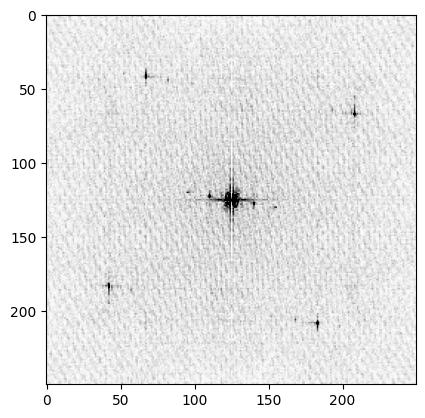

In [12]:
to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+5*s2])

The coordinates of the Bragg peaks are:
array([[208,  67],
       [ 42, 183],
       [ 67,  42],
       [183, 208]])

The coordinates of the Q vectors are:
array([[ 84, -57],
       [-82,  59],
       [-57, -82],
       [ 59,  84]])


array([[208,  67],
       [ 42, 183],
       [ 67,  42],
       [183, 208]])

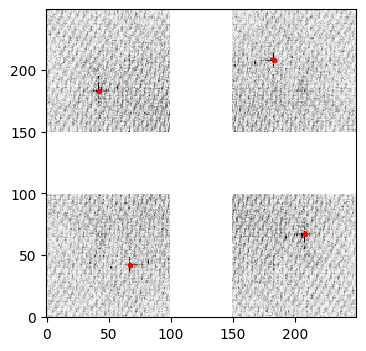

In [13]:
# Find parameters to find Bragg peaks
dfc.findBraggs(testsparse, w=0.1, show=True)

The coordinates of the Bragg peaks are:
array([[208,  67],
       [ 42, 183],
       [ 67,  42],
       [183, 208]])

The coordinates of the Q vectors are:
array([[ 84, -57],
       [-82,  59],
       [-57, -82],
       [ 59,  84]])


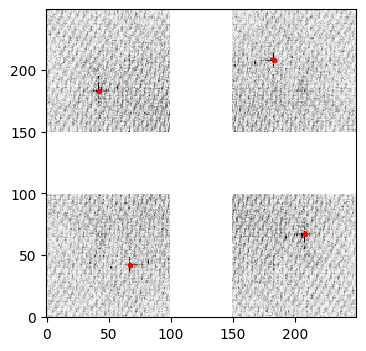

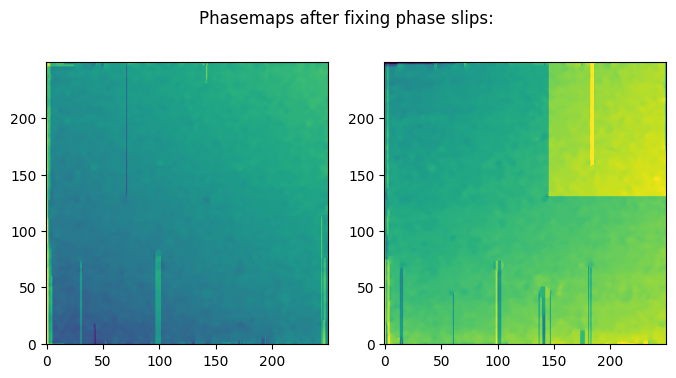

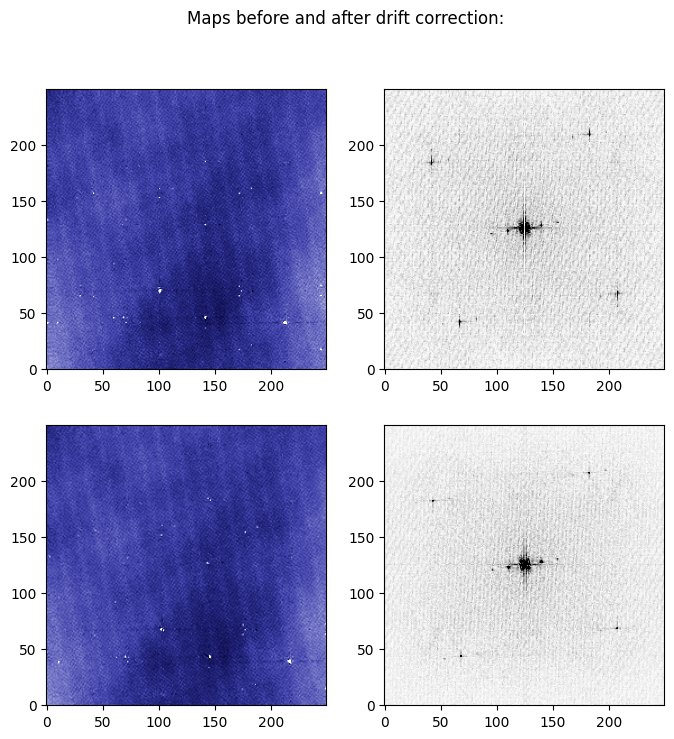

In [14]:
# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(testsparse, w=0.1, sigma=20, show=True, method='lockin')

## 65 nm

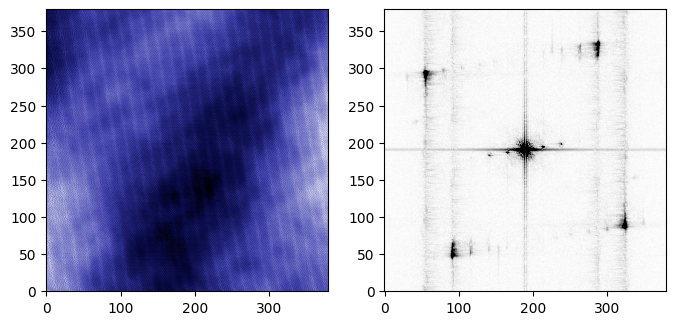

In [15]:
t = stmpy.load("2022-09-05_BSCCO_SparseSamplingTopo002.sxm", biasOffset=False)
t.z = stmpy.tools.lineSubtract(t.Z, 1)
dfc.display(t.z)

# part 1
## (drift correct then reconstruction)

The coordinates of the Bragg peaks are:
array([[325,  86],
       [ 55, 294],
       [ 92,  47],
       [288, 333]])

The coordinates of the Q vectors are:
array([[ 136, -103],
       [-134,  105],
       [ -97, -142],
       [  99,  144]])
The coordinates of the Bragg peaks are:
array([[325,  86],
       [ 55, 294],
       [ 92,  47],
       [288, 333]])

The coordinates of the Q vectors are:
array([[ 136, -103],
       [-134,  105],
       [ -97, -142],
       [  99,  144]])
Iteration 1:
  fx = 1007843882.967564, xnorm = 379.999558, gnorm = 63492.836841, step = 0.000016, k = 1, ls = 1

Iteration 2:
  fx = 249868583.877979, xnorm = 25837.113104, gnorm = 31587.432063, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 2451007.836332, xnorm = 33577.165609, gnorm = 2839.628809, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 437669.528308, xnorm = 33454.580783, gnorm = 96.481597, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 435260.251775, xnorm = 33455.119099, gnorm = 18.1225

Iteration 80:
  fx = 350695.717736, xnorm = 34163.743351, gnorm = 64.817933, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 349444.616230, xnorm = 34146.776945, gnorm = 36.403115, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 349164.228980, xnorm = 34184.396163, gnorm = 64.575599, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 347920.500559, xnorm = 34167.533129, gnorm = 36.171613, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 347645.788184, xnorm = 34205.189838, gnorm = 64.359317, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 346410.057032, xnorm = 34188.400285, gnorm = 36.139589, step = 0.500000, k = 85, ls = 2

Iteration 86:
  fx = 346139.650566, xnorm = 34226.254422, gnorm = 64.303232, step = 0.500000, k = 86, ls = 2

Iteration 87:
  fx = 344903.724183, xnorm = 34209.536457, gnorm = 35.928938, step = 0.500000, k = 87, ls = 2

Iteration 88:
  fx = 344636.101897, xnorm = 34247.438637, gnorm = 64.133414, step = 0.500000, k = 88, ls = 2

Iteration 

Iteration 159:
  fx = 296234.875818, xnorm = 35068.442766, gnorm = 32.663110, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 296018.328396, xnorm = 35108.239606, gnorm = 57.837070, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 295012.151569, xnorm = 35094.706657, gnorm = 32.021917, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 294803.602753, xnorm = 35134.222205, gnorm = 57.534513, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 293807.064772, xnorm = 35120.843487, gnorm = 31.779306, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 293594.320528, xnorm = 35160.119318, gnorm = 57.086695, step = 0.500000, k = 164, ls = 2

Iteration 165:
  fx = 292617.349096, xnorm = 35146.850772, gnorm = 32.017603, step = 0.500000, k = 165, ls = 2

Iteration 166:
  fx = 292400.554264, xnorm = 35186.302327, gnorm = 56.912279, step = 0.500000, k = 166, ls = 2

Iteration 167:
  fx = 291430.905236, xnorm = 35173.043718, gnorm = 32.109180, step = 0.500000, k = 167, 

Iteration 234:
  fx = 255399.388058, xnorm = 36117.625031, gnorm = 51.851167, step = 0.500000, k = 234, ls = 2

Iteration 235:
  fx = 254584.052586, xnorm = 36106.989559, gnorm = 28.904268, step = 0.500000, k = 235, ls = 2

Iteration 236:
  fx = 254413.539348, xnorm = 36145.792946, gnorm = 51.709112, step = 0.500000, k = 236, ls = 2

Iteration 237:
  fx = 253603.237152, xnorm = 36135.255543, gnorm = 28.838379, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 253429.487729, xnorm = 36174.022128, gnorm = 51.483843, step = 0.500000, k = 238, ls = 2

Iteration 239:
  fx = 252627.617764, xnorm = 36163.558246, gnorm = 28.884299, step = 0.500000, k = 239, ls = 2

Iteration 240:
  fx = 252453.829952, xnorm = 36202.379234, gnorm = 51.404792, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 251654.384615, xnorm = 36191.961469, gnorm = 28.853647, step = 0.500000, k = 241, ls = 2

Iteration 242:
  fx = 251481.595589, xnorm = 36230.783577, gnorm = 51.315666, step = 0.500000, k = 242, 

Iteration 314:
  fx = 219714.215651, xnorm = 37269.314546, gnorm = 46.423025, step = 0.500000, k = 314, ls = 2

Iteration 315:
  fx = 219057.084099, xnorm = 37261.260103, gnorm = 26.050790, step = 0.500000, k = 315, ls = 2

Iteration 316:
  fx = 218918.199148, xnorm = 37298.334159, gnorm = 46.317545, step = 0.500000, k = 316, ls = 2

Iteration 317:
  fx = 218262.645758, xnorm = 37290.344660, gnorm = 25.853227, step = 0.500000, k = 317, ls = 2

Iteration 318:
  fx = 218125.993919, xnorm = 37327.296072, gnorm = 46.201164, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 217473.510332, xnorm = 37319.377319, gnorm = 25.738662, step = 0.500000, k = 319, ls = 2

Iteration 320:
  fx = 217332.325430, xnorm = 37356.201440, gnorm = 45.886322, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 216692.836856, xnorm = 37348.319092, gnorm = 26.100784, step = 0.500000, k = 321, ls = 2

Iteration 322:
  fx = 216546.584058, xnorm = 37385.259808, gnorm = 45.750822, step = 0.500000, k = 322, 

Iteration 394:
  fx = 190916.004322, xnorm = 38421.016014, gnorm = 41.526099, step = 0.500000, k = 394, ls = 2

Iteration 395:
  fx = 190386.329784, xnorm = 38415.100807, gnorm = 23.459726, step = 0.500000, k = 395, ls = 2

Iteration 396:
  fx = 190270.571232, xnorm = 38449.337259, gnorm = 41.352571, step = 0.500000, k = 396, ls = 2

Iteration 397:
  fx = 189745.417730, xnorm = 38443.476822, gnorm = 23.407987, step = 0.500000, k = 397, ls = 2

Iteration 398:
  fx = 189629.303744, xnorm = 38477.634010, gnorm = 41.218140, step = 0.500000, k = 398, ls = 2

Iteration 399:
  fx = 189108.067698, xnorm = 38471.834410, gnorm = 23.368125, step = 0.500000, k = 399, ls = 2

Iteration 400:
  fx = 188993.194923, xnorm = 38505.983798, gnorm = 41.149631, step = 0.500000, k = 400, ls = 2

Iteration 401:
  fx = 188473.229220, xnorm = 38500.211550, gnorm = 23.285403, step = 0.500000, k = 401, ls = 2

Iteration 402:
  fx = 188360.485496, xnorm = 38534.281037, gnorm = 41.055955, step = 0.500000, k = 402, 

Iteration 474:
  fx = 167892.335262, xnorm = 39525.308488, gnorm = 36.464714, step = 0.500000, k = 474, ls = 2

Iteration 475:
  fx = 167481.040489, xnorm = 39521.188074, gnorm = 20.701919, step = 0.500000, k = 475, ls = 2

Iteration 476:
  fx = 167389.640589, xnorm = 39551.744890, gnorm = 36.291517, step = 0.500000, k = 476, ls = 2

Iteration 477:
  fx = 166982.873718, xnorm = 39547.653728, gnorm = 20.760771, step = 0.500000, k = 477, ls = 2

Iteration 478:
  fx = 166890.709811, xnorm = 39578.167029, gnorm = 36.198067, step = 0.500000, k = 478, ls = 2

Iteration 479:
  fx = 166486.697788, xnorm = 39574.115146, gnorm = 20.697044, step = 0.500000, k = 479, ls = 2

Iteration 480:
  fx = 166393.999885, xnorm = 39604.499429, gnorm = 36.036660, step = 0.500000, k = 480, ls = 2

Iteration 481:
  fx = 165993.815716, xnorm = 39600.495551, gnorm = 20.667946, step = 0.500000, k = 481, ls = 2

Iteration 482:
  fx = 165900.051409, xnorm = 39630.762851, gnorm = 35.862862, step = 0.500000, k = 482, 

Iteration 549:
  fx = 151053.436807, xnorm = 40456.830265, gnorm = 18.303316, step = 0.500000, k = 549, ls = 2

Iteration 550:
  fx = 150978.848650, xnorm = 40483.327116, gnorm = 31.615728, step = 0.500000, k = 550, ls = 2

Iteration 551:
  fx = 150669.587524, xnorm = 40480.583326, gnorm = 18.456753, step = 0.500000, k = 551, ls = 2

Iteration 552:
  fx = 150591.858475, xnorm = 40507.045162, gnorm = 31.425448, step = 0.500000, k = 552, ls = 2

Iteration 553:
  fx = 150286.787003, xnorm = 40504.314276, gnorm = 18.561021, step = 0.500000, k = 553, ls = 2

Iteration 554:
  fx = 150210.333385, xnorm = 40530.820117, gnorm = 31.429376, step = 0.500000, k = 554, ls = 2

Iteration 555:
  fx = 149903.832864, xnorm = 40528.110857, gnorm = 18.359270, step = 0.500000, k = 555, ls = 2

Iteration 556:
  fx = 149829.169450, xnorm = 40554.447839, gnorm = 31.306444, step = 0.500000, k = 556, ls = 2

Iteration 557:
  fx = 149524.673541, xnorm = 40551.776623, gnorm = 18.274295, step = 0.500000, k = 557, 

Iteration 624:
  fx = 138653.376142, xnorm = 41298.889200, gnorm = 26.571673, step = 0.500000, k = 624, ls = 2

Iteration 625:
  fx = 138432.664426, xnorm = 41297.085805, gnorm = 16.011820, step = 0.500000, k = 625, ls = 2

Iteration 626:
  fx = 138372.153488, xnorm = 41319.039554, gnorm = 26.399591, step = 0.500000, k = 626, ls = 2

Iteration 627:
  fx = 138154.428600, xnorm = 41317.263863, gnorm = 15.957421, step = 0.500000, k = 627, ls = 2

Iteration 628:
  fx = 138095.848068, xnorm = 41339.134207, gnorm = 26.365131, step = 0.500000, k = 628, ls = 2

Iteration 629:
  fx = 137877.830196, xnorm = 41337.370656, gnorm = 15.814167, step = 0.500000, k = 629, ls = 2

Iteration 630:
  fx = 137819.824270, xnorm = 41359.072640, gnorm = 26.205813, step = 0.500000, k = 630, ls = 2

Iteration 631:
  fx = 137604.741032, xnorm = 41357.337110, gnorm = 15.747962, step = 0.500000, k = 631, ls = 2

Iteration 632:
  fx = 137546.635915, xnorm = 41378.923118, gnorm = 26.060748, step = 0.500000, k = 632, 

Iteration 699:
  fx = 129646.307082, xnorm = 41979.738141, gnorm = 13.724543, step = 0.500000, k = 699, ls = 2

Iteration 700:
  fx = 129599.250466, xnorm = 41997.378410, gnorm = 21.756797, step = 0.500000, k = 700, ls = 2

Iteration 701:
  fx = 129450.404078, xnorm = 41996.281293, gnorm = 13.688489, step = 0.500000, k = 701, ls = 2

Iteration 702:
  fx = 129403.102561, xnorm = 42013.824570, gnorm = 21.639229, step = 0.500000, k = 702, ls = 2

Iteration 703:
  fx = 129256.254442, xnorm = 42012.744052, gnorm = 13.696610, step = 0.500000, k = 703, ls = 2

Iteration 704:
  fx = 129208.173941, xnorm = 42030.175222, gnorm = 21.463020, step = 0.500000, k = 704, ls = 2

Iteration 705:
  fx = 129063.923601, xnorm = 42029.103061, gnorm = 13.769847, step = 0.500000, k = 705, ls = 2

Iteration 706:
  fx = 129015.290564, xnorm = 42046.454427, gnorm = 21.332482, step = 0.500000, k = 706, ls = 2

Iteration 707:
  fx = 128873.123597, xnorm = 42045.393220, gnorm = 13.765061, step = 0.500000, k = 707, 

Iteration 774:
  fx = 123605.481756, xnorm = 42536.430117, gnorm = 17.227805, step = 0.500000, k = 774, ls = 2

Iteration 775:
  fx = 123510.946464, xnorm = 42535.771405, gnorm = 11.544220, step = 0.500000, k = 775, ls = 2

Iteration 776:
  fx = 123474.628974, xnorm = 42549.101813, gnorm = 17.068482, step = 0.500000, k = 776, ls = 2

Iteration 777:
  fx = 123382.042763, xnorm = 42548.452087, gnorm = 11.534108, step = 0.500000, k = 777, ls = 2

Iteration 778:
  fx = 123345.617566, xnorm = 42561.695198, gnorm = 16.943751, step = 0.500000, k = 778, ls = 2

Iteration 779:
  fx = 123254.796177, xnorm = 42561.044727, gnorm = 11.592249, step = 0.500000, k = 779, ls = 2

Iteration 780:
  fx = 123218.002187, xnorm = 42574.231960, gnorm = 16.832457, step = 0.500000, k = 780, ls = 2

Iteration 781:
  fx = 123128.431971, xnorm = 42573.587428, gnorm = 11.574236, step = 0.500000, k = 781, ls = 2

Iteration 782:
  fx = 123091.817815, xnorm = 42586.686735, gnorm = 16.715389, step = 0.500000, k = 782, 

Iteration 849:
  fx = 119575.576904, xnorm = 42949.795415, gnorm = 9.832535, step = 0.500000, k = 849, ls = 2

Iteration 850:
  fx = 119548.138506, xnorm = 42959.885639, gnorm = 13.438629, step = 0.500000, k = 850, ls = 2

Iteration 851:
  fx = 119490.267055, xnorm = 42959.523559, gnorm = 9.734437, step = 0.500000, k = 851, ls = 2

Iteration 852:
  fx = 119463.003063, xnorm = 42969.512970, gnorm = 13.318711, step = 0.500000, k = 852, ls = 2

Iteration 853:
  fx = 119406.080757, xnorm = 42969.149972, gnorm = 9.706129, step = 0.500000, k = 853, ls = 2

Iteration 854:
  fx = 119379.366719, xnorm = 42979.087773, gnorm = 13.295455, step = 0.500000, k = 854, ls = 2

Iteration 855:
  fx = 119322.659622, xnorm = 42978.726799, gnorm = 9.656659, step = 0.500000, k = 855, ls = 2

Iteration 856:
  fx = 119296.144555, xnorm = 42988.596208, gnorm = 13.219160, step = 0.500000, k = 856, ls = 2

Iteration 857:
  fx = 119240.018565, xnorm = 42988.240266, gnorm = 9.602586, step = 0.500000, k = 857, ls = 

Iteration 924:
  fx = 116977.053095, xnorm = 43271.569808, gnorm = 10.365161, step = 0.500000, k = 924, ls = 2

Iteration 925:
  fx = 116942.536451, xnorm = 43271.387946, gnorm = 8.166753, step = 0.500000, k = 925, ls = 2

Iteration 926:
  fx = 116922.271400, xnorm = 43278.772707, gnorm = 10.316640, step = 0.500000, k = 926, ls = 2

Iteration 927:
  fx = 116888.188788, xnorm = 43278.592943, gnorm = 8.161384, step = 0.500000, k = 927, ls = 2

Iteration 928:
  fx = 116868.099141, xnorm = 43285.944183, gnorm = 10.275430, step = 0.500000, k = 928, ls = 2

Iteration 929:
  fx = 116834.157954, xnorm = 43285.766221, gnorm = 8.083729, step = 0.500000, k = 929, ls = 2

Iteration 930:
  fx = 116814.351850, xnorm = 43293.047009, gnorm = 10.197915, step = 0.500000, k = 930, ls = 2

Iteration 931:
  fx = 116780.989240, xnorm = 43292.868814, gnorm = 8.039568, step = 0.500000, k = 931, ls = 2

Iteration 932:
  fx = 116761.264464, xnorm = 43300.088190, gnorm = 10.104064, step = 0.500000, k = 932, ls =

Iteration 999:
  fx = 115291.524962, xnorm = 43504.516683, gnorm = 6.770086, step = 0.500000, k = 999, ls = 2

Iteration 1000:
  fx = 115277.151182, xnorm = 43510.039206, gnorm = 8.115383, step = 0.500000, k = 1000, ls = 2

Iteration 1001:
  fx = 115255.935422, xnorm = 43509.947615, gnorm = 6.791881, step = 0.500000, k = 1001, ls = 2

Iteration 1002:
  fx = 115241.584870, xnorm = 43515.463872, gnorm = 8.102684, step = 0.500000, k = 1002, ls = 2

Iteration 1003:
  fx = 115220.524990, xnorm = 43515.373770, gnorm = 6.788843, step = 0.500000, k = 1003, ls = 2

Iteration 1004:
  fx = 115206.137376, xnorm = 43520.876294, gnorm = 8.074415, step = 0.500000, k = 1004, ls = 2

Iteration 1005:
  fx = 115185.173506, xnorm = 43520.786858, gnorm = 6.752675, step = 0.500000, k = 1005, ls = 2

Iteration 1006:
  fx = 115170.977544, xnorm = 43526.246775, gnorm = 8.035271, step = 0.500000, k = 1006, ls = 2

Iteration 1007:
  fx = 115150.137549, xnorm = 43526.163827, gnorm = 6.691673, step = 0.500000, k =

Iteration 1074:
  fx = 114189.209438, xnorm = 43686.072730, gnorm = 6.512695, step = 0.500000, k = 1074, ls = 2

Iteration 1075:
  fx = 114175.537573, xnorm = 43686.045886, gnorm = 5.634592, step = 0.500000, k = 1075, ls = 2

Iteration 1076:
  fx = 114165.326347, xnorm = 43690.209691, gnorm = 6.440250, step = 0.500000, k = 1076, ls = 2

Iteration 1077:
  fx = 114151.972106, xnorm = 43690.183291, gnorm = 5.615990, step = 0.500000, k = 1077, ls = 2

Iteration 1078:
  fx = 114141.948744, xnorm = 43694.331765, gnorm = 6.431191, step = 0.500000, k = 1078, ls = 2

Iteration 1079:
  fx = 114128.569538, xnorm = 43694.305855, gnorm = 5.567891, step = 0.500000, k = 1079, ls = 2

Iteration 1080:
  fx = 114118.751164, xnorm = 43698.424317, gnorm = 6.410881, step = 0.500000, k = 1080, ls = 2

Iteration 1081:
  fx = 114105.491060, xnorm = 43698.404395, gnorm = 5.560240, step = 0.500000, k = 1081, ls = 2

Iteration 1082:
  fx = 114095.774071, xnorm = 43702.506623, gnorm = 6.398909, step = 0.500000, k

Iteration 1147:
  fx = 113463.336120, xnorm = 43819.497556, gnorm = 4.712258, step = 0.500000, k = 1147, ls = 2

Iteration 1148:
  fx = 113456.175040, xnorm = 43822.750907, gnorm = 5.281561, step = 0.500000, k = 1148, ls = 2

Iteration 1149:
  fx = 113447.167053, xnorm = 43822.755582, gnorm = 4.696816, step = 0.500000, k = 1149, ls = 2

Iteration 1150:
  fx = 113440.064604, xnorm = 43825.989488, gnorm = 5.251829, step = 0.500000, k = 1150, ls = 2

Iteration 1151:
  fx = 113431.194201, xnorm = 43825.996866, gnorm = 4.681404, step = 0.500000, k = 1151, ls = 2

Iteration 1152:
  fx = 113424.171275, xnorm = 43829.213058, gnorm = 5.239067, step = 0.500000, k = 1152, ls = 2

Iteration 1153:
  fx = 113415.319279, xnorm = 43829.220870, gnorm = 4.660526, step = 0.500000, k = 1153, ls = 2

Iteration 1154:
  fx = 113408.386948, xnorm = 43832.420332, gnorm = 5.222301, step = 0.500000, k = 1154, ls = 2

Iteration 1155:
  fx = 113399.547149, xnorm = 43832.429718, gnorm = 4.632947, step = 0.500000, k

Iteration 1232:
  fx = 112901.597430, xnorm = 43942.134758, gnorm = 4.221998, step = 0.500000, k = 1232, ls = 2

Iteration 1233:
  fx = 112895.834374, xnorm = 43942.172187, gnorm = 3.838113, step = 0.500000, k = 1233, ls = 2

Iteration 1234:
  fx = 112891.079790, xnorm = 43944.595965, gnorm = 4.205846, step = 0.500000, k = 1234, ls = 2

Iteration 1235:
  fx = 112885.352654, xnorm = 43944.635953, gnorm = 3.817803, step = 0.500000, k = 1235, ls = 2

Iteration 1236:
  fx = 112880.656422, xnorm = 43947.049280, gnorm = 4.197424, step = 0.500000, k = 1236, ls = 2

Iteration 1237:
  fx = 112874.955157, xnorm = 43947.089192, gnorm = 3.811799, step = 0.500000, k = 1237, ls = 2

Iteration 1238:
  fx = 112870.272605, xnorm = 43949.496244, gnorm = 4.174682, step = 0.500000, k = 1238, ls = 2

Iteration 1239:
  fx = 112864.622018, xnorm = 43949.537398, gnorm = 3.782069, step = 0.500000, k = 1239, ls = 2

Iteration 1240:
  fx = 112859.986861, xnorm = 43951.919091, gnorm = 4.143120, step = 0.500000, k

Iteration 1307:
  fx = 112566.077180, xnorm = 44023.810730, gnorm = 3.217995, step = 0.500000, k = 1307, ls = 2

Iteration 1308:
  fx = 112562.704834, xnorm = 44025.733693, gnorm = 3.533211, step = 0.500000, k = 1308, ls = 2

Iteration 1309:
  fx = 112558.663147, xnorm = 44025.770886, gnorm = 3.222444, step = 0.500000, k = 1309, ls = 2

Iteration 1310:
  fx = 112555.313967, xnorm = 44027.689823, gnorm = 3.526590, step = 0.500000, k = 1310, ls = 2

Iteration 1311:
  fx = 112551.283794, xnorm = 44027.726711, gnorm = 3.199453, step = 0.500000, k = 1311, ls = 2

Iteration 1312:
  fx = 112547.967389, xnorm = 44029.633904, gnorm = 3.505326, step = 0.500000, k = 1312, ls = 2

Iteration 1313:
  fx = 112543.963538, xnorm = 44029.670189, gnorm = 3.178220, step = 0.500000, k = 1313, ls = 2

Iteration 1314:
  fx = 112540.685333, xnorm = 44031.569410, gnorm = 3.494217, step = 0.500000, k = 1314, ls = 2

Iteration 1315:
  fx = 112536.694123, xnorm = 44031.605392, gnorm = 3.173271, step = 0.500000, k

Iteration 1394:
  fx = 112292.872386, xnorm = 44101.804406, gnorm = 2.979549, step = 0.500000, k = 1394, ls = 2

Iteration 1395:
  fx = 112289.937101, xnorm = 44101.845755, gnorm = 2.663429, step = 0.500000, k = 1395, ls = 2

Iteration 1396:
  fx = 112287.652817, xnorm = 44103.385892, gnorm = 2.970234, step = 0.500000, k = 1396, ls = 2

Iteration 1397:
  fx = 112284.747008, xnorm = 44103.426447, gnorm = 2.655218, step = 0.500000, k = 1397, ls = 2

Iteration 1398:
  fx = 112282.474399, xnorm = 44104.962845, gnorm = 2.959734, step = 0.500000, k = 1398, ls = 2

Iteration 1399:
  fx = 112279.593678, xnorm = 44105.002361, gnorm = 2.644573, step = 0.500000, k = 1399, ls = 2

Iteration 1400:
  fx = 112277.338216, xnorm = 44106.530786, gnorm = 2.946890, step = 0.500000, k = 1400, ls = 2

Iteration 1401:
  fx = 112274.488093, xnorm = 44106.569769, gnorm = 2.638361, step = 0.500000, k = 1401, ls = 2

Iteration 1402:
  fx = 112272.245953, xnorm = 44108.091234, gnorm = 2.934262, step = 0.500000, k

Iteration 1469:
  fx = 112123.191993, xnorm = 44155.293054, gnorm = 2.283140, step = 0.500000, k = 1469, ls = 2

Iteration 1470:
  fx = 112121.521289, xnorm = 44156.567126, gnorm = 2.570920, step = 0.500000, k = 1470, ls = 2

Iteration 1471:
  fx = 112119.336078, xnorm = 44156.604558, gnorm = 2.280336, step = 0.500000, k = 1471, ls = 2

Iteration 1472:
  fx = 112117.665674, xnorm = 44157.873442, gnorm = 2.562394, step = 0.500000, k = 1472, ls = 2

Iteration 1473:
  fx = 112115.507168, xnorm = 44157.911835, gnorm = 2.286409, step = 0.500000, k = 1473, ls = 2

Iteration 1474:
  fx = 112113.828313, xnorm = 44159.181016, gnorm = 2.555946, step = 0.500000, k = 1474, ls = 2

Iteration 1475:
  fx = 112111.685166, xnorm = 44159.217244, gnorm = 2.284932, step = 0.500000, k = 1475, ls = 2

Iteration 1476:
  fx = 112110.019865, xnorm = 44160.483586, gnorm = 2.554331, step = 0.500000, k = 1476, ls = 2

Iteration 1477:
  fx = 112107.870362, xnorm = 44160.520220, gnorm = 2.266250, step = 0.500000, k

Iteration 1544:
  fx = 111995.904211, xnorm = 44201.124878, gnorm = 2.281030, step = 0.500000, k = 1544, ls = 2

Iteration 1545:
  fx = 111994.175058, xnorm = 44201.158217, gnorm = 1.974022, step = 0.500000, k = 1545, ls = 2

Iteration 1546:
  fx = 111992.944743, xnorm = 44202.224849, gnorm = 2.277013, step = 0.500000, k = 1546, ls = 2

Iteration 1547:
  fx = 111991.214708, xnorm = 44202.259114, gnorm = 1.962497, step = 0.500000, k = 1547, ls = 2

Iteration 1548:
  fx = 111989.995846, xnorm = 44203.321006, gnorm = 2.268057, step = 0.500000, k = 1548, ls = 2

Iteration 1549:
  fx = 111988.283509, xnorm = 44203.354354, gnorm = 1.957129, step = 0.500000, k = 1549, ls = 2

Iteration 1550:
  fx = 111987.072195, xnorm = 44204.412436, gnorm = 2.260395, step = 0.500000, k = 1550, ls = 2

Iteration 1551:
  fx = 111985.370473, xnorm = 44204.445243, gnorm = 1.947670, step = 0.500000, k = 1551, ls = 2

Iteration 1552:
  fx = 111984.166598, xnorm = 44205.498263, gnorm = 2.252053, step = 0.500000, k

Iteration 1617:
  fx = 111899.916248, xnorm = 44237.821978, gnorm = 1.717011, step = 0.500000, k = 1617, ls = 2

Iteration 1618:
  fx = 111898.982016, xnorm = 44238.726464, gnorm = 2.016775, step = 0.500000, k = 1618, ls = 2

Iteration 1619:
  fx = 111897.620761, xnorm = 44238.757148, gnorm = 1.721394, step = 0.500000, k = 1619, ls = 2

Iteration 1620:
  fx = 111896.680330, xnorm = 44239.661328, gnorm = 2.011581, step = 0.500000, k = 1620, ls = 2

Iteration 1621:
  fx = 111895.329059, xnorm = 44239.691525, gnorm = 1.719306, step = 0.500000, k = 1621, ls = 2

Iteration 1622:
  fx = 111894.397099, xnorm = 44240.590992, gnorm = 2.005398, step = 0.500000, k = 1622, ls = 2

Iteration 1623:
  fx = 111893.052353, xnorm = 44240.621445, gnorm = 1.711674, step = 0.500000, k = 1623, ls = 2

Iteration 1624:
  fx = 111892.124465, xnorm = 44241.517319, gnorm = 1.996909, step = 0.500000, k = 1624, ls = 2

Iteration 1625:
  fx = 111890.794236, xnorm = 44241.547295, gnorm = 1.710892, step = 0.500000, k

Iteration 1702:
  fx = 111813.962240, xnorm = 44274.566728, gnorm = 1.798664, step = 0.500000, k = 1702, ls = 2

Iteration 1703:
  fx = 111812.874907, xnorm = 44274.594142, gnorm = 1.472239, step = 0.500000, k = 1703, ls = 2

Iteration 1704:
  fx = 111812.202470, xnorm = 44275.340199, gnorm = 1.788752, step = 0.500000, k = 1704, ls = 2

Iteration 1705:
  fx = 111811.126737, xnorm = 44275.366210, gnorm = 1.466324, step = 0.500000, k = 1705, ls = 2

Iteration 1706:
  fx = 111810.457385, xnorm = 44276.110388, gnorm = 1.784648, step = 0.500000, k = 1706, ls = 2

Iteration 1707:
  fx = 111809.387666, xnorm = 44276.135547, gnorm = 1.469457, step = 0.500000, k = 1707, ls = 2

Iteration 1708:
  fx = 111808.719050, xnorm = 44276.879118, gnorm = 1.785441, step = 0.500000, k = 1708, ls = 2

Iteration 1709:
  fx = 111807.649137, xnorm = 44276.905444, gnorm = 1.468309, step = 0.500000, k = 1709, ls = 2

Iteration 1710:
  fx = 111806.984366, xnorm = 44277.647610, gnorm = 1.784340, step = 0.500000, k

Iteration 1775:
  fx = 111755.769191, xnorm = 44300.682277, gnorm = 1.303997, step = 0.500000, k = 1775, ls = 2

Iteration 1776:
  fx = 111755.251328, xnorm = 44301.329494, gnorm = 1.632544, step = 0.500000, k = 1776, ls = 2

Iteration 1777:
  fx = 111754.351825, xnorm = 44301.354093, gnorm = 1.299171, step = 0.500000, k = 1777, ls = 2

Iteration 1778:
  fx = 111753.837855, xnorm = 44301.999321, gnorm = 1.630287, step = 0.500000, k = 1778, ls = 2

Iteration 1779:
  fx = 111752.942396, xnorm = 44302.023833, gnorm = 1.295391, step = 0.500000, k = 1779, ls = 2

Iteration 1780:
  fx = 111752.432973, xnorm = 44302.666311, gnorm = 1.627938, step = 0.500000, k = 1780, ls = 2

Iteration 1781:
  fx = 111751.539774, xnorm = 44302.690960, gnorm = 1.288988, step = 0.500000, k = 1781, ls = 2

Iteration 1782:
  fx = 111751.034965, xnorm = 44303.329074, gnorm = 1.622082, step = 0.500000, k = 1782, ls = 2

Iteration 1783:
  fx = 111750.146674, xnorm = 44303.353429, gnorm = 1.281564, step = 0.500000, k

Iteration 1859:
  fx = 111702.548575, xnorm = 44326.788375, gnorm = 1.136058, step = 0.500000, k = 1859, ls = 2

Iteration 1860:
  fx = 111702.165554, xnorm = 44327.344329, gnorm = 1.481681, step = 0.500000, k = 1860, ls = 2

Iteration 1861:
  fx = 111701.424865, xnorm = 44327.365602, gnorm = 1.139470, step = 0.500000, k = 1861, ls = 2

Iteration 1862:
  fx = 111701.039005, xnorm = 44327.921246, gnorm = 1.476680, step = 0.500000, k = 1862, ls = 2

Iteration 1863:
  fx = 111700.302328, xnorm = 44327.942387, gnorm = 1.133829, step = 0.500000, k = 1863, ls = 2

Iteration 1864:
  fx = 111699.918360, xnorm = 44328.494833, gnorm = 1.470586, step = 0.500000, k = 1864, ls = 2

Iteration 1865:
  fx = 111699.188007, xnorm = 44328.515608, gnorm = 1.128300, step = 0.500000, k = 1865, ls = 2

Iteration 1866:
  fx = 111698.806047, xnorm = 44329.067250, gnorm = 1.464761, step = 0.500000, k = 1866, ls = 2

Iteration 1867:
  fx = 111698.083234, xnorm = 44329.087143, gnorm = 1.125177, step = 0.500000, k

Iteration 1933:
  fx = 111664.829177, xnorm = 44346.797490, gnorm = 1.004003, step = 0.500000, k = 1933, ls = 2

Iteration 1934:
  fx = 111664.537635, xnorm = 44347.284919, gnorm = 1.354085, step = 0.500000, k = 1934, ls = 2

Iteration 1935:
  fx = 111663.913116, xnorm = 44347.303355, gnorm = 1.003821, step = 0.500000, k = 1935, ls = 2

Iteration 1936:
  fx = 111663.620750, xnorm = 44347.790092, gnorm = 1.351728, step = 0.500000, k = 1936, ls = 2

Iteration 1937:
  fx = 111663.000282, xnorm = 44347.808360, gnorm = 1.004486, step = 0.500000, k = 1937, ls = 2

Iteration 1938:
  fx = 111662.709297, xnorm = 44348.294748, gnorm = 1.352528, step = 0.500000, k = 1938, ls = 2

Iteration 1939:
  fx = 111662.087870, xnorm = 44348.313457, gnorm = 1.001147, step = 0.500000, k = 1939, ls = 2

Iteration 1940:
  fx = 111661.798940, xnorm = 44348.797708, gnorm = 1.348726, step = 0.500000, k = 1940, ls = 2

Iteration 1941:
  fx = 111661.180368, xnorm = 44348.816553, gnorm = 0.995642, step = 0.500000, k

Iteration 2008:
  fx = 111633.767161, xnorm = 44364.737878, gnorm = 1.246594, step = 0.500000, k = 2008, ls = 2

Iteration 2009:
  fx = 111633.238181, xnorm = 44364.754475, gnorm = 0.901288, step = 0.500000, k = 2009, ls = 2

Iteration 2010:
  fx = 111633.008521, xnorm = 44365.181979, gnorm = 1.245926, step = 0.500000, k = 2010, ls = 2

Iteration 2011:
  fx = 111632.479045, xnorm = 44365.198407, gnorm = 0.895485, step = 0.500000, k = 2011, ls = 2

Iteration 2012:
  fx = 111632.252463, xnorm = 44365.625055, gnorm = 1.245010, step = 0.500000, k = 2012, ls = 2

Iteration 2013:
  fx = 111631.723946, xnorm = 44365.642154, gnorm = 0.891587, step = 0.500000, k = 2013, ls = 2

Iteration 2014:
  fx = 111631.499446, xnorm = 44366.067606, gnorm = 1.242766, step = 0.500000, k = 2014, ls = 2

Iteration 2015:
  fx = 111630.973717, xnorm = 44366.084061, gnorm = 0.889239, step = 0.500000, k = 2015, ls = 2

Iteration 2016:
  fx = 111630.750977, xnorm = 44366.507775, gnorm = 1.239366, step = 0.500000, k

Iteration 2094:
  fx = 111604.381277, xnorm = 44382.543292, gnorm = 1.130924, step = 0.500000, k = 2094, ls = 2

Iteration 2095:
  fx = 111603.948532, xnorm = 44382.560518, gnorm = 0.800443, step = 0.500000, k = 2095, ls = 2

Iteration 2096:
  fx = 111603.770727, xnorm = 44382.930198, gnorm = 1.129300, step = 0.500000, k = 2096, ls = 2

Iteration 2097:
  fx = 111603.337777, xnorm = 44382.946293, gnorm = 0.792995, step = 0.500000, k = 2097, ls = 2

Iteration 2098:
  fx = 111603.162630, xnorm = 44383.313375, gnorm = 1.124786, step = 0.500000, k = 2098, ls = 2

Iteration 2099:
  fx = 111602.732711, xnorm = 44383.329498, gnorm = 0.787649, step = 0.500000, k = 2099, ls = 2

Iteration 2100:
  fx = 111602.557738, xnorm = 44383.695046, gnorm = 1.117797, step = 0.500000, k = 2100, ls = 2

Iteration 2101:
  fx = 111602.134272, xnorm = 44383.710196, gnorm = 0.789136, step = 0.500000, k = 2101, ls = 2

Iteration 2102:
  fx = 111601.958727, xnorm = 44384.075319, gnorm = 1.114275, step = 0.500000, k

Iteration 2168:
  fx = 111583.815923, xnorm = 44395.845270, gnorm = 1.032293, step = 0.500000, k = 2168, ls = 2

Iteration 2169:
  fx = 111583.453935, xnorm = 44395.859379, gnorm = 0.722753, step = 0.500000, k = 2169, ls = 2

Iteration 2170:
  fx = 111583.310647, xnorm = 44396.178905, gnorm = 1.031801, step = 0.500000, k = 2170, ls = 2

Iteration 2171:
  fx = 111582.948340, xnorm = 44396.193996, gnorm = 0.720078, step = 0.500000, k = 2171, ls = 2

Iteration 2172:
  fx = 111582.806243, xnorm = 44396.512552, gnorm = 1.031436, step = 0.500000, k = 2172, ls = 2

Iteration 2173:
  fx = 111582.443721, xnorm = 44396.527581, gnorm = 0.714045, step = 0.500000, k = 2173, ls = 2

Iteration 2174:
  fx = 111582.304997, xnorm = 44396.844937, gnorm = 1.031441, step = 0.500000, k = 2174, ls = 2

Iteration 2175:
  fx = 111581.942938, xnorm = 44396.860227, gnorm = 0.712315, step = 0.500000, k = 2175, ls = 2

Iteration 2176:
  fx = 111581.805208, xnorm = 44397.176931, gnorm = 1.030476, step = 0.500000, k

Iteration 2254:
  fx = 111563.995042, xnorm = 44409.291046, gnorm = 0.929747, step = 0.500000, k = 2254, ls = 2

Iteration 2255:
  fx = 111563.701838, xnorm = 44409.304734, gnorm = 0.653014, step = 0.500000, k = 2255, ls = 2

Iteration 2256:
  fx = 111563.582418, xnorm = 44409.577706, gnorm = 0.927097, step = 0.500000, k = 2256, ls = 2

Iteration 2257:
  fx = 111563.291221, xnorm = 44409.591626, gnorm = 0.651779, step = 0.500000, k = 2257, ls = 2

Iteration 2258:
  fx = 111563.172297, xnorm = 44409.863570, gnorm = 0.926159, step = 0.500000, k = 2258, ls = 2

Iteration 2259:
  fx = 111562.881757, xnorm = 44409.877491, gnorm = 0.648411, step = 0.500000, k = 2259, ls = 2

Iteration 2260:
  fx = 111562.764398, xnorm = 44410.149019, gnorm = 0.925258, step = 0.500000, k = 2260, ls = 2

Iteration 2261:
  fx = 111562.474286, xnorm = 44410.162238, gnorm = 0.646304, step = 0.500000, k = 2261, ls = 2

Iteration 2262:
  fx = 111562.358172, xnorm = 44410.433611, gnorm = 0.923117, step = 0.500000, k

Iteration 2339:
  fx = 111547.855960, xnorm = 44420.693396, gnorm = 0.573956, step = 0.500000, k = 2339, ls = 2

Iteration 2340:
  fx = 111547.771057, xnorm = 44420.934752, gnorm = 0.872428, step = 0.500000, k = 2340, ls = 2

Iteration 2341:
  fx = 111547.511586, xnorm = 44420.947589, gnorm = 0.572578, step = 0.500000, k = 2341, ls = 2

Iteration 2342:
  fx = 111547.427291, xnorm = 44421.187808, gnorm = 0.871529, step = 0.500000, k = 2342, ls = 2

Iteration 2343:
  fx = 111547.168514, xnorm = 44421.200520, gnorm = 0.570641, step = 0.500000, k = 2343, ls = 2

Iteration 2344:
  fx = 111547.083988, xnorm = 44421.440317, gnorm = 0.869038, step = 0.500000, k = 2344, ls = 2

Iteration 2345:
  fx = 111546.827281, xnorm = 44421.453148, gnorm = 0.570720, step = 0.500000, k = 2345, ls = 2

Iteration 2346:
  fx = 111546.743274, xnorm = 44421.691902, gnorm = 0.867513, step = 0.500000, k = 2346, ls = 2

Iteration 2347:
  fx = 111546.487270, xnorm = 44421.704668, gnorm = 0.569694, step = 0.500000, k

Iteration 2414:
  fx = 111536.017552, xnorm = 44429.820552, gnorm = 0.795793, step = 0.500000, k = 2414, ls = 2

Iteration 2415:
  fx = 111535.802783, xnorm = 44429.831715, gnorm = 0.534392, step = 0.500000, k = 2415, ls = 2

Iteration 2416:
  fx = 111535.726137, xnorm = 44430.048104, gnorm = 0.794038, step = 0.500000, k = 2416, ls = 2

Iteration 2417:
  fx = 111535.512391, xnorm = 44430.059234, gnorm = 0.532250, step = 0.500000, k = 2417, ls = 2

Iteration 2418:
  fx = 111535.436934, xnorm = 44430.275967, gnorm = 0.792082, step = 0.500000, k = 2418, ls = 2

Iteration 2419:
  fx = 111535.224075, xnorm = 44430.286652, gnorm = 0.531059, step = 0.500000, k = 2419, ls = 2

Iteration 2420:
  fx = 111535.148927, xnorm = 44430.502521, gnorm = 0.789374, step = 0.500000, k = 2420, ls = 2

Iteration 2421:
  fx = 111534.937552, xnorm = 44430.513399, gnorm = 0.529712, step = 0.500000, k = 2421, ls = 2

Iteration 2422:
  fx = 111534.861908, xnorm = 44430.728050, gnorm = 0.785811, step = 0.500000, k

Iteration 2500:
  fx = 111524.560439, xnorm = 44439.094156, gnorm = 0.744529, step = 0.500000, k = 2500, ls = 2

Iteration 2501:
  fx = 111524.371906, xnorm = 44439.105229, gnorm = 0.476776, step = 0.500000, k = 2501, ls = 2

Iteration 2502:
  fx = 111524.314857, xnorm = 44439.299883, gnorm = 0.744234, step = 0.500000, k = 2502, ls = 2

Iteration 2503:
  fx = 111524.126790, xnorm = 44439.310921, gnorm = 0.475755, step = 0.500000, k = 2503, ls = 2

Iteration 2504:
  fx = 111524.069992, xnorm = 44439.505512, gnorm = 0.742711, step = 0.500000, k = 2504, ls = 2

Iteration 2505:
  fx = 111523.882761, xnorm = 44439.515852, gnorm = 0.474850, step = 0.500000, k = 2505, ls = 2

Iteration 2506:
  fx = 111523.826546, xnorm = 44439.710232, gnorm = 0.742710, step = 0.500000, k = 2506, ls = 2

Iteration 2507:
  fx = 111523.639025, xnorm = 44439.720607, gnorm = 0.472245, step = 0.500000, k = 2507, ls = 2

Iteration 2508:
  fx = 111523.583605, xnorm = 44439.914085, gnorm = 0.741735, step = 0.500000, k

Iteration 2574:
  fx = 111516.086632, xnorm = 44446.270637, gnorm = 0.689978, step = 0.500000, k = 2574, ls = 2

Iteration 2575:
  fx = 111515.926430, xnorm = 44446.280674, gnorm = 0.447765, step = 0.500000, k = 2575, ls = 2

Iteration 2576:
  fx = 111515.873920, xnorm = 44446.452656, gnorm = 0.687543, step = 0.500000, k = 2576, ls = 2

Iteration 2577:
  fx = 111515.714679, xnorm = 44446.462394, gnorm = 0.446861, step = 0.500000, k = 2577, ls = 2

Iteration 2578:
  fx = 111515.663030, xnorm = 44446.633594, gnorm = 0.686582, step = 0.500000, k = 2578, ls = 2

Iteration 2579:
  fx = 111515.503915, xnorm = 44446.643400, gnorm = 0.446022, step = 0.500000, k = 2579, ls = 2

Iteration 2580:
  fx = 111515.452696, xnorm = 44446.813963, gnorm = 0.685927, step = 0.500000, k = 2580, ls = 2

Iteration 2581:
  fx = 111515.293869, xnorm = 44446.824106, gnorm = 0.444525, step = 0.500000, k = 2581, ls = 2

Iteration 2582:
  fx = 111515.242799, xnorm = 44446.994416, gnorm = 0.684770, step = 0.500000, k

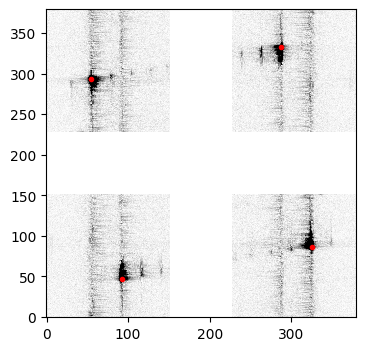

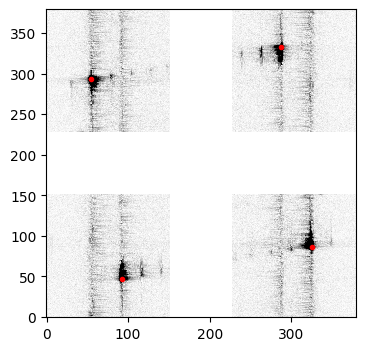

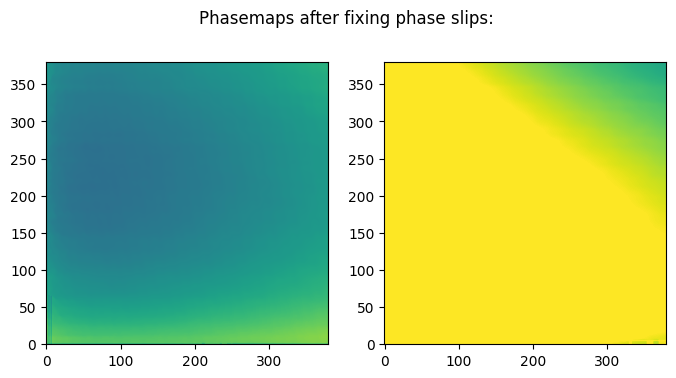

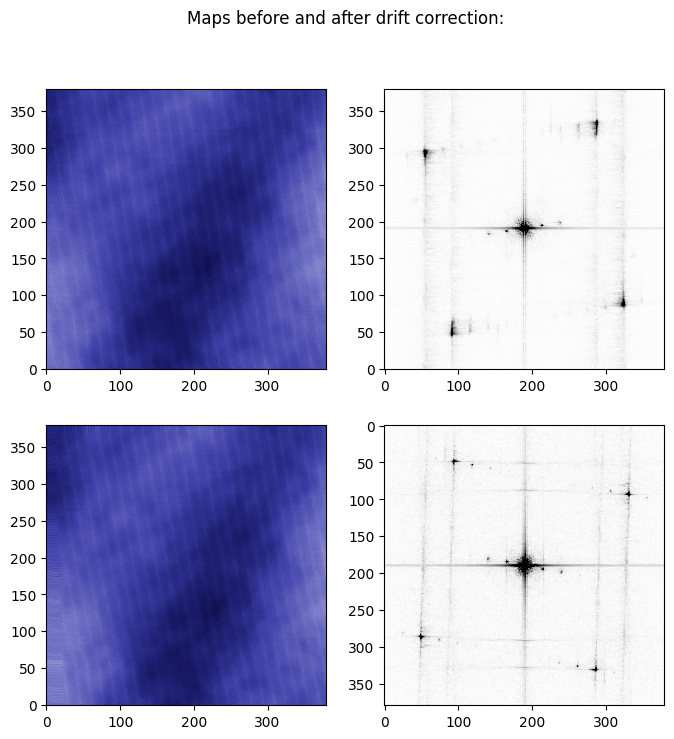

In [16]:
# Find parameters to find Bragg peaks
dfc.findBraggs(t.z, w=0.1, show=True)

# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(t.z, w=0.1, sigma=20, show=True, method='lockin')

original_mean = mean(t.z_c)
test = standardize(t.z_c)
#c2 = mean(t.z_c)
#s2 = std(t.z_c)
#imshow(t.z_c,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])
nx, ny = shape(t.z_c)

# extract small sample of signal
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri]

testsparse = zeros_like(t.z_c)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])

# part 2
## (reconstruction then drift correction)

1.0000000659382575
Iteration 1:
  fx = 1007843882.967564, xnorm = 379.999558, gnorm = 63492.836841, step = 0.000016, k = 1, ls = 1

Iteration 2:
  fx = 249868583.877979, xnorm = 25837.113104, gnorm = 31587.432063, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 2451007.836332, xnorm = 33577.165609, gnorm = 2839.628809, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 437669.528308, xnorm = 33454.580783, gnorm = 96.481597, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 435260.251775, xnorm = 33455.119099, gnorm = 18.122579, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 435085.240547, xnorm = 33455.631378, gnorm = 18.276179, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 428945.413913, xnorm = 33530.544967, gnorm = 225.059483, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 422738.237802, xnorm = 33611.544919, gnorm = 201.329456, step = 0.500000, k = 8, ls = 2

Iteration 9:
  fx = 415531.764750, xnorm = 33538.091565, gnorm = 145.697048, step = 0.250000, k = 9, 

Iteration 79:
  fx = 350978.832072, xnorm = 34126.159237, gnorm = 36.551229, step = 0.500000, k = 79, ls = 2

Iteration 80:
  fx = 350695.717736, xnorm = 34163.743351, gnorm = 64.817933, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 349444.616230, xnorm = 34146.776945, gnorm = 36.403115, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 349164.228980, xnorm = 34184.396163, gnorm = 64.575599, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 347920.500559, xnorm = 34167.533129, gnorm = 36.171613, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 347645.788184, xnorm = 34205.189838, gnorm = 64.359317, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 346410.057032, xnorm = 34188.400285, gnorm = 36.139589, step = 0.500000, k = 85, ls = 2

Iteration 86:
  fx = 346139.650566, xnorm = 34226.254422, gnorm = 64.303232, step = 0.500000, k = 86, ls = 2

Iteration 87:
  fx = 344903.724183, xnorm = 34209.536457, gnorm = 35.928938, step = 0.500000, k = 87, ls = 2

Iteration 

Iteration 159:
  fx = 296234.875818, xnorm = 35068.442766, gnorm = 32.663110, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 296018.328396, xnorm = 35108.239606, gnorm = 57.837070, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 295012.151569, xnorm = 35094.706657, gnorm = 32.021917, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 294803.602753, xnorm = 35134.222205, gnorm = 57.534513, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 293807.064772, xnorm = 35120.843487, gnorm = 31.779306, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 293594.320528, xnorm = 35160.119318, gnorm = 57.086695, step = 0.500000, k = 164, ls = 2

Iteration 165:
  fx = 292617.349096, xnorm = 35146.850772, gnorm = 32.017603, step = 0.500000, k = 165, ls = 2

Iteration 166:
  fx = 292400.554264, xnorm = 35186.302327, gnorm = 56.912279, step = 0.500000, k = 166, ls = 2

Iteration 167:
  fx = 291430.905236, xnorm = 35173.043718, gnorm = 32.109180, step = 0.500000, k = 167, 

Iteration 237:
  fx = 253603.237152, xnorm = 36135.255543, gnorm = 28.838379, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 253429.487729, xnorm = 36174.022128, gnorm = 51.483843, step = 0.500000, k = 238, ls = 2

Iteration 239:
  fx = 252627.617764, xnorm = 36163.558246, gnorm = 28.884299, step = 0.500000, k = 239, ls = 2

Iteration 240:
  fx = 252453.829952, xnorm = 36202.379234, gnorm = 51.404792, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 251654.384615, xnorm = 36191.961469, gnorm = 28.853647, step = 0.500000, k = 241, ls = 2

Iteration 242:
  fx = 251481.595589, xnorm = 36230.783577, gnorm = 51.315666, step = 0.500000, k = 242, ls = 2

Iteration 243:
  fx = 250684.265502, xnorm = 36220.461696, gnorm = 28.644686, step = 0.500000, k = 243, ls = 2

Iteration 244:
  fx = 250510.061056, xnorm = 36259.187803, gnorm = 51.040442, step = 0.500000, k = 244, ls = 2

Iteration 245:
  fx = 249723.276295, xnorm = 36248.936510, gnorm = 28.710235, step = 0.500000, k = 245, 

Iteration 315:
  fx = 219057.084099, xnorm = 37261.260103, gnorm = 26.050790, step = 0.500000, k = 315, ls = 2

Iteration 316:
  fx = 218918.199148, xnorm = 37298.334159, gnorm = 46.317545, step = 0.500000, k = 316, ls = 2

Iteration 317:
  fx = 218262.645758, xnorm = 37290.344660, gnorm = 25.853227, step = 0.500000, k = 317, ls = 2

Iteration 318:
  fx = 218125.993919, xnorm = 37327.296072, gnorm = 46.201164, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 217473.510332, xnorm = 37319.377319, gnorm = 25.738662, step = 0.500000, k = 319, ls = 2

Iteration 320:
  fx = 217332.325430, xnorm = 37356.201440, gnorm = 45.886322, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 216692.836856, xnorm = 37348.319092, gnorm = 26.100784, step = 0.500000, k = 321, ls = 2

Iteration 322:
  fx = 216546.584058, xnorm = 37385.259808, gnorm = 45.750822, step = 0.500000, k = 322, ls = 2

Iteration 323:
  fx = 215910.799119, xnorm = 37377.390051, gnorm = 26.157973, step = 0.500000, k = 323, 

Iteration 394:
  fx = 190916.004322, xnorm = 38421.016014, gnorm = 41.526099, step = 0.500000, k = 394, ls = 2

Iteration 395:
  fx = 190386.329784, xnorm = 38415.100807, gnorm = 23.459726, step = 0.500000, k = 395, ls = 2

Iteration 396:
  fx = 190270.571232, xnorm = 38449.337259, gnorm = 41.352571, step = 0.500000, k = 396, ls = 2

Iteration 397:
  fx = 189745.417730, xnorm = 38443.476822, gnorm = 23.407987, step = 0.500000, k = 397, ls = 2

Iteration 398:
  fx = 189629.303744, xnorm = 38477.634010, gnorm = 41.218140, step = 0.500000, k = 398, ls = 2

Iteration 399:
  fx = 189108.067698, xnorm = 38471.834410, gnorm = 23.368125, step = 0.500000, k = 399, ls = 2

Iteration 400:
  fx = 188993.194923, xnorm = 38505.983798, gnorm = 41.149631, step = 0.500000, k = 400, ls = 2

Iteration 401:
  fx = 188473.229220, xnorm = 38500.211550, gnorm = 23.285403, step = 0.500000, k = 401, ls = 2

Iteration 402:
  fx = 188360.485496, xnorm = 38534.281037, gnorm = 41.055955, step = 0.500000, k = 402, 

Iteration 469:
  fx = 169004.874957, xnorm = 39441.116308, gnorm = 21.217732, step = 0.500000, k = 469, ls = 2

Iteration 470:
  fx = 168908.461618, xnorm = 39472.088182, gnorm = 36.714239, step = 0.500000, k = 470, ls = 2

Iteration 471:
  fx = 168493.156771, xnorm = 39467.893218, gnorm = 21.052482, step = 0.500000, k = 471, ls = 2

Iteration 472:
  fx = 168398.018991, xnorm = 39498.774981, gnorm = 36.607949, step = 0.500000, k = 472, ls = 2

Iteration 473:
  fx = 167984.081240, xnorm = 39494.620376, gnorm = 20.801684, step = 0.500000, k = 473, ls = 2

Iteration 474:
  fx = 167892.335262, xnorm = 39525.308488, gnorm = 36.464714, step = 0.500000, k = 474, ls = 2

Iteration 475:
  fx = 167481.040489, xnorm = 39521.188074, gnorm = 20.701919, step = 0.500000, k = 475, ls = 2

Iteration 476:
  fx = 167389.640589, xnorm = 39551.744890, gnorm = 36.291517, step = 0.500000, k = 476, ls = 2

Iteration 477:
  fx = 166982.873718, xnorm = 39547.653728, gnorm = 20.760771, step = 0.500000, k = 477, 

Iteration 544:
  fx = 152155.256785, xnorm = 40411.693089, gnorm = 32.085607, step = 0.500000, k = 544, ls = 2

Iteration 545:
  fx = 151835.929671, xnorm = 40408.858256, gnorm = 18.590212, step = 0.500000, k = 545, ls = 2

Iteration 546:
  fx = 151761.673718, xnorm = 40435.725070, gnorm = 32.050103, step = 0.500000, k = 546, ls = 2

Iteration 547:
  fx = 151442.385447, xnorm = 40432.916486, gnorm = 18.372310, step = 0.500000, k = 547, ls = 2

Iteration 548:
  fx = 151369.099107, xnorm = 40459.605391, gnorm = 31.866479, step = 0.500000, k = 548, ls = 2

Iteration 549:
  fx = 151053.436807, xnorm = 40456.830265, gnorm = 18.303316, step = 0.500000, k = 549, ls = 2

Iteration 550:
  fx = 150978.848650, xnorm = 40483.327116, gnorm = 31.615728, step = 0.500000, k = 550, ls = 2

Iteration 551:
  fx = 150669.587524, xnorm = 40480.583326, gnorm = 18.456753, step = 0.500000, k = 551, ls = 2

Iteration 552:
  fx = 150591.858475, xnorm = 40507.045162, gnorm = 31.425448, step = 0.500000, k = 552, 

Iteration 619:
  fx = 139284.166369, xnorm = 41235.865174, gnorm = 16.119313, step = 0.500000, k = 619, ls = 2

Iteration 620:
  fx = 139223.467768, xnorm = 41258.189357, gnorm = 26.848909, step = 0.500000, k = 620, ls = 2

Iteration 621:
  fx = 138998.463701, xnorm = 41256.341048, gnorm = 16.148542, step = 0.500000, k = 621, ls = 2

Iteration 622:
  fx = 138937.485758, xnorm = 41278.588182, gnorm = 26.731767, step = 0.500000, k = 622, ls = 2

Iteration 623:
  fx = 138714.293306, xnorm = 41276.755976, gnorm = 16.128500, step = 0.500000, k = 623, ls = 2

Iteration 624:
  fx = 138653.376142, xnorm = 41298.889200, gnorm = 26.571673, step = 0.500000, k = 624, ls = 2

Iteration 625:
  fx = 138432.664426, xnorm = 41297.085805, gnorm = 16.011820, step = 0.500000, k = 625, ls = 2

Iteration 626:
  fx = 138372.153488, xnorm = 41319.039554, gnorm = 26.399591, step = 0.500000, k = 626, ls = 2

Iteration 627:
  fx = 138154.428600, xnorm = 41317.263863, gnorm = 15.957421, step = 0.500000, k = 627, 

Iteration 694:
  fx = 130198.761386, xnorm = 41947.554471, gnorm = 22.205388, step = 0.500000, k = 694, ls = 2

Iteration 695:
  fx = 130043.629335, xnorm = 41946.413124, gnorm = 13.760562, step = 0.500000, k = 695, ls = 2

Iteration 696:
  fx = 129996.806821, xnorm = 41964.242281, gnorm = 22.041450, step = 0.500000, k = 696, ls = 2

Iteration 697:
  fx = 129844.063451, xnorm = 41963.112040, gnorm = 13.760129, step = 0.500000, k = 697, ls = 2

Iteration 698:
  fx = 129797.491726, xnorm = 41980.859090, gnorm = 21.934127, step = 0.500000, k = 698, ls = 2

Iteration 699:
  fx = 129646.307082, xnorm = 41979.738141, gnorm = 13.724543, step = 0.500000, k = 699, ls = 2

Iteration 700:
  fx = 129599.250466, xnorm = 41997.378410, gnorm = 21.756797, step = 0.500000, k = 700, ls = 2

Iteration 701:
  fx = 129450.404078, xnorm = 41996.281293, gnorm = 13.688489, step = 0.500000, k = 701, ls = 2

Iteration 702:
  fx = 129403.102561, xnorm = 42013.824570, gnorm = 21.639229, step = 0.500000, k = 702, 

Iteration 769:
  fx = 123906.791825, xnorm = 42497.080536, gnorm = 11.781270, step = 0.500000, k = 769, ls = 2

Iteration 770:
  fx = 123868.779348, xnorm = 42510.687313, gnorm = 17.312830, step = 0.500000, k = 770, ls = 2

Iteration 771:
  fx = 123774.264937, xnorm = 42510.024945, gnorm = 11.843051, step = 0.500000, k = 771, ls = 2

Iteration 772:
  fx = 123736.655241, xnorm = 42523.605282, gnorm = 17.285106, step = 0.500000, k = 772, ls = 2

Iteration 773:
  fx = 123642.038503, xnorm = 42522.945880, gnorm = 11.713554, step = 0.500000, k = 773, ls = 2

Iteration 774:
  fx = 123605.481756, xnorm = 42536.430117, gnorm = 17.227805, step = 0.500000, k = 774, ls = 2

Iteration 775:
  fx = 123510.946464, xnorm = 42535.771405, gnorm = 11.544220, step = 0.500000, k = 775, ls = 2

Iteration 776:
  fx = 123474.628974, xnorm = 42549.101813, gnorm = 17.068482, step = 0.500000, k = 776, ls = 2

Iteration 777:
  fx = 123382.042763, xnorm = 42548.452087, gnorm = 11.534108, step = 0.500000, k = 777, 

Iteration 844:
  fx = 119807.769560, xnorm = 42930.489973, gnorm = 13.580440, step = 0.500000, k = 844, ls = 2

Iteration 845:
  fx = 119748.839620, xnorm = 42930.110778, gnorm = 9.921629, step = 0.500000, k = 845, ls = 2

Iteration 846:
  fx = 119720.438568, xnorm = 42940.340738, gnorm = 13.528810, step = 0.500000, k = 846, ls = 2

Iteration 847:
  fx = 119662.011325, xnorm = 42939.966465, gnorm = 9.922994, step = 0.500000, k = 847, ls = 2

Iteration 848:
  fx = 119633.948789, xnorm = 42950.166769, gnorm = 13.519438, step = 0.500000, k = 848, ls = 2

Iteration 849:
  fx = 119575.576904, xnorm = 42949.795415, gnorm = 9.832535, step = 0.500000, k = 849, ls = 2

Iteration 850:
  fx = 119548.138506, xnorm = 42959.885639, gnorm = 13.438629, step = 0.500000, k = 850, ls = 2

Iteration 851:
  fx = 119490.267055, xnorm = 42959.523559, gnorm = 9.734437, step = 0.500000, k = 851, ls = 2

Iteration 852:
  fx = 119463.003063, xnorm = 42969.512970, gnorm = 13.318711, step = 0.500000, k = 852, ls =

Iteration 918:
  fx = 117146.362550, xnorm = 43249.565576, gnorm = 10.571087, step = 0.500000, k = 918, ls = 2

Iteration 919:
  fx = 117110.613151, xnorm = 43249.363539, gnorm = 8.375185, step = 0.500000, k = 919, ls = 2

Iteration 920:
  fx = 117089.392727, xnorm = 43256.966445, gnorm = 10.518430, step = 0.500000, k = 920, ls = 2

Iteration 921:
  fx = 117053.876212, xnorm = 43256.769393, gnorm = 8.302501, step = 0.500000, k = 921, ls = 2

Iteration 922:
  fx = 117033.078027, xnorm = 43264.311884, gnorm = 10.483592, step = 0.500000, k = 922, ls = 2

Iteration 923:
  fx = 116997.698208, xnorm = 43264.120646, gnorm = 8.218653, step = 0.500000, k = 923, ls = 2

Iteration 924:
  fx = 116977.053095, xnorm = 43271.569808, gnorm = 10.365161, step = 0.500000, k = 924, ls = 2

Iteration 925:
  fx = 116942.536451, xnorm = 43271.387946, gnorm = 8.166753, step = 0.500000, k = 925, ls = 2

Iteration 926:
  fx = 116922.271400, xnorm = 43278.772707, gnorm = 10.316640, step = 0.500000, k = 926, ls =

Iteration 993:
  fx = 115401.523600, xnorm = 43487.916530, gnorm = 6.945725, step = 0.500000, k = 993, ls = 2

Iteration 994:
  fx = 115386.537865, xnorm = 43493.607585, gnorm = 8.307473, step = 0.500000, k = 994, ls = 2

Iteration 995:
  fx = 115364.281849, xnorm = 43493.504422, gnorm = 6.868284, step = 0.500000, k = 995, ls = 2

Iteration 996:
  fx = 115349.652433, xnorm = 43499.143879, gnorm = 8.260085, step = 0.500000, k = 996, ls = 2

Iteration 997:
  fx = 115327.567363, xnorm = 43499.045558, gnorm = 6.793533, step = 0.500000, k = 997, ls = 2

Iteration 998:
  fx = 115313.197425, xnorm = 43504.609874, gnorm = 8.184004, step = 0.500000, k = 998, ls = 2

Iteration 999:
  fx = 115291.524962, xnorm = 43504.516683, gnorm = 6.770086, step = 0.500000, k = 999, ls = 2

Iteration 1000:
  fx = 115277.151182, xnorm = 43510.039206, gnorm = 8.115383, step = 0.500000, k = 1000, ls = 2

Iteration 1001:
  fx = 115255.935422, xnorm = 43509.947615, gnorm = 6.791881, step = 0.500000, k = 1001, ls = 

Iteration 1068:
  fx = 114262.140737, xnorm = 43673.457939, gnorm = 6.614969, step = 0.500000, k = 1068, ls = 2

Iteration 1069:
  fx = 114248.013948, xnorm = 43673.429165, gnorm = 5.730570, step = 0.500000, k = 1069, ls = 2

Iteration 1070:
  fx = 114237.627690, xnorm = 43677.690069, gnorm = 6.591193, step = 0.500000, k = 1070, ls = 2

Iteration 1071:
  fx = 114223.625055, xnorm = 43677.661551, gnorm = 5.711278, step = 0.500000, k = 1071, ls = 2

Iteration 1072:
  fx = 114213.220671, xnorm = 43681.894469, gnorm = 6.541622, step = 0.500000, k = 1072, ls = 2

Iteration 1073:
  fx = 114199.489498, xnorm = 43681.865481, gnorm = 5.696400, step = 0.500000, k = 1073, ls = 2

Iteration 1074:
  fx = 114189.209438, xnorm = 43686.072730, gnorm = 6.512695, step = 0.500000, k = 1074, ls = 2

Iteration 1075:
  fx = 114175.537573, xnorm = 43686.045886, gnorm = 5.634592, step = 0.500000, k = 1075, ls = 2

Iteration 1076:
  fx = 114165.326347, xnorm = 43690.209691, gnorm = 6.440250, step = 0.500000, k

Iteration 1141:
  fx = 113513.190323, xnorm = 43809.539650, gnorm = 4.790428, step = 0.500000, k = 1141, ls = 2

Iteration 1142:
  fx = 113505.840217, xnorm = 43812.867624, gnorm = 5.392872, step = 0.500000, k = 1142, ls = 2

Iteration 1143:
  fx = 113496.463974, xnorm = 43812.875009, gnorm = 4.790739, step = 0.500000, k = 1143, ls = 2

Iteration 1144:
  fx = 113489.116638, xnorm = 43816.192586, gnorm = 5.375917, step = 0.500000, k = 1144, ls = 2

Iteration 1145:
  fx = 113479.798147, xnorm = 43816.197908, gnorm = 4.766159, step = 0.500000, k = 1145, ls = 2

Iteration 1146:
  fx = 113472.511660, xnorm = 43819.491425, gnorm = 5.330622, step = 0.500000, k = 1146, ls = 2

Iteration 1147:
  fx = 113463.336120, xnorm = 43819.497556, gnorm = 4.712258, step = 0.500000, k = 1147, ls = 2

Iteration 1148:
  fx = 113456.175040, xnorm = 43822.750907, gnorm = 5.281561, step = 0.500000, k = 1148, ls = 2

Iteration 1149:
  fx = 113447.167053, xnorm = 43822.755582, gnorm = 4.696816, step = 0.500000, k

Iteration 1226:
  fx = 112933.919292, xnorm = 43934.661692, gnorm = 4.309504, step = 0.500000, k = 1226, ls = 2

Iteration 1227:
  fx = 112927.897602, xnorm = 43934.696238, gnorm = 3.891353, step = 0.500000, k = 1227, ls = 2

Iteration 1228:
  fx = 112923.011312, xnorm = 43937.173508, gnorm = 4.286724, step = 0.500000, k = 1228, ls = 2

Iteration 1229:
  fx = 112917.061321, xnorm = 43937.209859, gnorm = 3.869001, step = 0.500000, k = 1229, ls = 2

Iteration 1230:
  fx = 112912.248889, xnorm = 43939.664437, gnorm = 4.253115, step = 0.500000, k = 1230, ls = 2

Iteration 1231:
  fx = 112906.368296, xnorm = 43939.701441, gnorm = 3.839369, step = 0.500000, k = 1231, ls = 2

Iteration 1232:
  fx = 112901.597430, xnorm = 43942.134758, gnorm = 4.221998, step = 0.500000, k = 1232, ls = 2

Iteration 1233:
  fx = 112895.834374, xnorm = 43942.172187, gnorm = 3.838113, step = 0.500000, k = 1233, ls = 2

Iteration 1234:
  fx = 112891.079790, xnorm = 43944.595965, gnorm = 4.205846, step = 0.500000, k

Iteration 1301:
  fx = 112588.788016, xnorm = 44017.863214, gnorm = 3.274041, step = 0.500000, k = 1301, ls = 2

Iteration 1302:
  fx = 112585.348851, xnorm = 44019.824548, gnorm = 3.595658, step = 0.500000, k = 1302, ls = 2

Iteration 1303:
  fx = 112581.131989, xnorm = 44019.862538, gnorm = 3.254781, step = 0.500000, k = 1303, ls = 2

Iteration 1304:
  fx = 112577.715307, xnorm = 44021.806212, gnorm = 3.566849, step = 0.500000, k = 1304, ls = 2

Iteration 1305:
  fx = 112573.542791, xnorm = 44021.843858, gnorm = 3.218375, step = 0.500000, k = 1305, ls = 2

Iteration 1306:
  fx = 112570.185953, xnorm = 44023.773674, gnorm = 3.549102, step = 0.500000, k = 1306, ls = 2

Iteration 1307:
  fx = 112566.077180, xnorm = 44023.810730, gnorm = 3.217995, step = 0.500000, k = 1307, ls = 2

Iteration 1308:
  fx = 112562.704834, xnorm = 44025.733693, gnorm = 3.533211, step = 0.500000, k = 1308, ls = 2

Iteration 1309:
  fx = 112558.663147, xnorm = 44025.770886, gnorm = 3.222444, step = 0.500000, k

Iteration 1374:
  fx = 112347.237459, xnorm = 44085.598610, gnorm = 3.113485, step = 0.500000, k = 1374, ls = 2

Iteration 1375:
  fx = 112344.041671, xnorm = 44085.633428, gnorm = 2.769673, step = 0.500000, k = 1375, ls = 2

Iteration 1376:
  fx = 112341.582465, xnorm = 44087.256083, gnorm = 3.094136, step = 0.500000, k = 1376, ls = 2

Iteration 1377:
  fx = 112338.435458, xnorm = 44087.292550, gnorm = 2.763791, step = 0.500000, k = 1377, ls = 2

Iteration 1378:
  fx = 112336.001068, xnorm = 44088.907251, gnorm = 3.085942, step = 0.500000, k = 1378, ls = 2

Iteration 1379:
  fx = 112332.858296, xnorm = 44088.943146, gnorm = 2.740750, step = 0.500000, k = 1379, ls = 2

Iteration 1380:
  fx = 112330.452138, xnorm = 44090.547994, gnorm = 3.065994, step = 0.500000, k = 1380, ls = 2

Iteration 1381:
  fx = 112327.357152, xnorm = 44090.583294, gnorm = 2.737278, step = 0.500000, k = 1381, ls = 2

Iteration 1382:
  fx = 112324.971558, xnorm = 44092.180066, gnorm = 3.055505, step = 0.500000, k

Iteration 1447:
  fx = 112167.788686, xnorm = 44140.392640, gnorm = 2.392297, step = 0.500000, k = 1447, ls = 2

Iteration 1448:
  fx = 112165.953406, xnorm = 44141.742006, gnorm = 2.685431, step = 0.500000, k = 1448, ls = 2

Iteration 1449:
  fx = 112163.569789, xnorm = 44141.778886, gnorm = 2.384662, step = 0.500000, k = 1449, ls = 2

Iteration 1450:
  fx = 112161.745304, xnorm = 44143.123492, gnorm = 2.680009, step = 0.500000, k = 1450, ls = 2

Iteration 1451:
  fx = 112159.387996, xnorm = 44143.160323, gnorm = 2.386877, step = 0.500000, k = 1451, ls = 2

Iteration 1452:
  fx = 112157.561124, xnorm = 44144.501030, gnorm = 2.672113, step = 0.500000, k = 1452, ls = 2

Iteration 1453:
  fx = 112155.221822, xnorm = 44144.539337, gnorm = 2.378273, step = 0.500000, k = 1453, ls = 2

Iteration 1454:
  fx = 112153.399747, xnorm = 44145.873166, gnorm = 2.653297, step = 0.500000, k = 1454, ls = 2

Iteration 1455:
  fx = 112151.080584, xnorm = 44145.912222, gnorm = 2.357878, step = 0.500000, k

Iteration 1533:
  fx = 112012.327079, xnorm = 44194.448730, gnorm = 2.011833, step = 0.500000, k = 1533, ls = 2

Iteration 1534:
  fx = 112011.035614, xnorm = 44195.544655, gnorm = 2.308977, step = 0.500000, k = 1534, ls = 2

Iteration 1535:
  fx = 112009.264311, xnorm = 44195.577486, gnorm = 2.012538, step = 0.500000, k = 1535, ls = 2

Iteration 1536:
  fx = 112007.981589, xnorm = 44196.669573, gnorm = 2.308843, step = 0.500000, k = 1536, ls = 2

Iteration 1537:
  fx = 112006.210402, xnorm = 44196.703613, gnorm = 2.007816, step = 0.500000, k = 1537, ls = 2

Iteration 1538:
  fx = 112004.934380, xnorm = 44197.792543, gnorm = 2.307948, step = 0.500000, k = 1538, ls = 2

Iteration 1539:
  fx = 112003.170347, xnorm = 44197.827318, gnorm = 2.001971, step = 0.500000, k = 1539, ls = 2

Iteration 1540:
  fx = 112001.902228, xnorm = 44198.910593, gnorm = 2.302388, step = 0.500000, k = 1540, ls = 2

Iteration 1541:
  fx = 112000.145582, xnorm = 44198.944552, gnorm = 1.990483, step = 0.500000, k

Iteration 1607:
  fx = 111911.698241, xnorm = 44233.073326, gnorm = 1.762275, step = 0.500000, k = 1607, ls = 2

Iteration 1608:
  fx = 111910.724819, xnorm = 44233.999655, gnorm = 2.058153, step = 0.500000, k = 1608, ls = 2

Iteration 1609:
  fx = 111909.305091, xnorm = 44234.032341, gnorm = 1.757048, step = 0.500000, k = 1609, ls = 2

Iteration 1610:
  fx = 111908.340999, xnorm = 44234.956774, gnorm = 2.056232, step = 0.500000, k = 1610, ls = 2

Iteration 1611:
  fx = 111906.921460, xnorm = 44234.988393, gnorm = 1.749345, step = 0.500000, k = 1611, ls = 2

Iteration 1612:
  fx = 111905.964529, xnorm = 44235.907807, gnorm = 2.044064, step = 0.500000, k = 1612, ls = 2

Iteration 1613:
  fx = 111904.558470, xnorm = 44235.940698, gnorm = 1.734063, step = 0.500000, k = 1613, ls = 2

Iteration 1614:
  fx = 111903.614200, xnorm = 44236.851955, gnorm = 2.030205, step = 0.500000, k = 1614, ls = 2

Iteration 1615:
  fx = 111902.229624, xnorm = 44236.884131, gnorm = 1.724488, step = 0.500000, k

Iteration 1682:
  fx = 111832.278114, xnorm = 44266.590609, gnorm = 1.863021, step = 0.500000, k = 1682, ls = 2

Iteration 1683:
  fx = 111831.110841, xnorm = 44266.617195, gnorm = 1.528895, step = 0.500000, k = 1683, ls = 2

Iteration 1684:
  fx = 111830.390718, xnorm = 44267.408027, gnorm = 1.859918, step = 0.500000, k = 1684, ls = 2

Iteration 1685:
  fx = 111829.226009, xnorm = 44267.435064, gnorm = 1.519255, step = 0.500000, k = 1685, ls = 2

Iteration 1686:
  fx = 111828.514023, xnorm = 44268.220150, gnorm = 1.851831, step = 0.500000, k = 1686, ls = 2

Iteration 1687:
  fx = 111827.359764, xnorm = 44268.246964, gnorm = 1.507073, step = 0.500000, k = 1687, ls = 2

Iteration 1688:
  fx = 111826.653954, xnorm = 44269.025371, gnorm = 1.839474, step = 0.500000, k = 1688, ls = 2

Iteration 1689:
  fx = 111825.516980, xnorm = 44269.051422, gnorm = 1.506372, step = 0.500000, k = 1689, ls = 2

Iteration 1690:
  fx = 111824.810290, xnorm = 44269.827244, gnorm = 1.831710, step = 0.500000, k

Iteration 1756:
  fx = 111769.868270, xnorm = 44294.468834, gnorm = 1.679830, step = 0.500000, k = 1756, ls = 2

Iteration 1757:
  fx = 111768.918277, xnorm = 44294.493819, gnorm = 1.345431, step = 0.500000, k = 1757, ls = 2

Iteration 1758:
  fx = 111768.370013, xnorm = 44295.167258, gnorm = 1.678647, step = 0.500000, k = 1758, ls = 2

Iteration 1759:
  fx = 111767.418379, xnorm = 44295.193501, gnorm = 1.338441, step = 0.500000, k = 1759, ls = 2

Iteration 1760:
  fx = 111766.873986, xnorm = 44295.862686, gnorm = 1.671364, step = 0.500000, k = 1760, ls = 2

Iteration 1761:
  fx = 111765.928153, xnorm = 44295.888005, gnorm = 1.329932, step = 0.500000, k = 1761, ls = 2

Iteration 1762:
  fx = 111765.387173, xnorm = 44296.554677, gnorm = 1.665973, step = 0.500000, k = 1762, ls = 2

Iteration 1763:
  fx = 111764.450089, xnorm = 44296.580831, gnorm = 1.328084, step = 0.500000, k = 1763, ls = 2

Iteration 1764:
  fx = 111763.910465, xnorm = 44297.245002, gnorm = 1.661200, step = 0.500000, k

Iteration 1831:
  fx = 111718.993305, xnorm = 44318.494874, gnorm = 1.179172, step = 0.500000, k = 1831, ls = 2

Iteration 1832:
  fx = 111718.579486, xnorm = 44319.077569, gnorm = 1.534033, step = 0.500000, k = 1832, ls = 2

Iteration 1833:
  fx = 111717.777789, xnorm = 44319.098938, gnorm = 1.178000, step = 0.500000, k = 1833, ls = 2

Iteration 1834:
  fx = 111717.364404, xnorm = 44319.679587, gnorm = 1.528867, step = 0.500000, k = 1834, ls = 2

Iteration 1835:
  fx = 111716.570384, xnorm = 44319.700827, gnorm = 1.175922, step = 0.500000, k = 1835, ls = 2

Iteration 1836:
  fx = 111716.157604, xnorm = 44320.280023, gnorm = 1.526450, step = 0.500000, k = 1836, ls = 2

Iteration 1837:
  fx = 111715.367792, xnorm = 44320.301301, gnorm = 1.173185, step = 0.500000, k = 1837, ls = 2

Iteration 1838:
  fx = 111714.956784, xnorm = 44320.879419, gnorm = 1.521021, step = 0.500000, k = 1838, ls = 2

Iteration 1839:
  fx = 111714.172651, xnorm = 44320.900307, gnorm = 1.168593, step = 0.500000, k

Iteration 1906:
  fx = 111677.892047, xnorm = 44340.046305, gnorm = 1.393313, step = 0.500000, k = 1906, ls = 2

Iteration 1907:
  fx = 111677.232022, xnorm = 44340.064643, gnorm = 1.054199, step = 0.500000, k = 1907, ls = 2

Iteration 1908:
  fx = 111676.905538, xnorm = 44340.572379, gnorm = 1.391399, step = 0.500000, k = 1908, ls = 2

Iteration 1909:
  fx = 111676.246669, xnorm = 44340.590977, gnorm = 1.049976, step = 0.500000, k = 1909, ls = 2

Iteration 1910:
  fx = 111675.925323, xnorm = 44341.097882, gnorm = 1.392692, step = 0.500000, k = 1910, ls = 2

Iteration 1911:
  fx = 111675.265084, xnorm = 44341.117049, gnorm = 1.045267, step = 0.500000, k = 1911, ls = 2

Iteration 1912:
  fx = 111674.949992, xnorm = 44341.622745, gnorm = 1.395129, step = 0.500000, k = 1912, ls = 2

Iteration 1913:
  fx = 111674.286650, xnorm = 44341.641449, gnorm = 1.037438, step = 0.500000, k = 1913, ls = 2

Iteration 1914:
  fx = 111673.974735, xnorm = 44342.144745, gnorm = 1.390219, step = 0.500000, k

Iteration 1981:
  fx = 111644.184331, xnorm = 44358.430140, gnorm = 0.950567, step = 0.500000, k = 1981, ls = 2

Iteration 1982:
  fx = 111643.919529, xnorm = 44358.875812, gnorm = 1.263812, step = 0.500000, k = 1982, ls = 2

Iteration 1983:
  fx = 111643.379102, xnorm = 44358.891635, gnorm = 0.946561, step = 0.500000, k = 1983, ls = 2

Iteration 1984:
  fx = 111643.116727, xnorm = 44359.335062, gnorm = 1.261235, step = 0.500000, k = 1984, ls = 2

Iteration 1985:
  fx = 111642.577940, xnorm = 44359.351744, gnorm = 0.945137, step = 0.500000, k = 1985, ls = 2

Iteration 1986:
  fx = 111642.315890, xnorm = 44359.794056, gnorm = 1.259361, step = 0.500000, k = 1986, ls = 2

Iteration 1987:
  fx = 111641.778802, xnorm = 44359.810482, gnorm = 0.941800, step = 0.500000, k = 1987, ls = 2

Iteration 1988:
  fx = 111641.521179, xnorm = 44360.251854, gnorm = 1.261786, step = 0.500000, k = 1988, ls = 2

Iteration 1989:
  fx = 111640.981959, xnorm = 44360.268320, gnorm = 0.938933, step = 0.500000, k

Iteration 2055:
  fx = 111616.826122, xnorm = 44374.586910, gnorm = 0.847103, step = 0.500000, k = 2055, ls = 2

Iteration 2056:
  fx = 111616.623290, xnorm = 44374.980748, gnorm = 1.178125, step = 0.500000, k = 2056, ls = 2

Iteration 2057:
  fx = 111616.152444, xnorm = 44374.996807, gnorm = 0.844307, step = 0.500000, k = 2057, ls = 2

Iteration 2058:
  fx = 111615.950660, xnorm = 44375.390520, gnorm = 1.175019, step = 0.500000, k = 2058, ls = 2

Iteration 2059:
  fx = 111615.482090, xnorm = 44375.406861, gnorm = 0.843461, step = 0.500000, k = 2059, ls = 2

Iteration 2060:
  fx = 111615.281382, xnorm = 44375.798655, gnorm = 1.173936, step = 0.500000, k = 2060, ls = 2

Iteration 2061:
  fx = 111614.814545, xnorm = 44375.815418, gnorm = 0.843265, step = 0.500000, k = 2061, ls = 2

Iteration 2062:
  fx = 111614.615075, xnorm = 44376.206418, gnorm = 1.172204, step = 0.500000, k = 2062, ls = 2

Iteration 2063:
  fx = 111614.148658, xnorm = 44376.222902, gnorm = 0.839355, step = 0.500000, k

Iteration 2129:
  fx = 111594.069614, xnorm = 44388.897134, gnorm = 0.768574, step = 0.500000, k = 2129, ls = 2

Iteration 2130:
  fx = 111593.903068, xnorm = 44389.243896, gnorm = 1.074022, step = 0.500000, k = 2130, ls = 2

Iteration 2131:
  fx = 111593.512049, xnorm = 44389.258899, gnorm = 0.762345, step = 0.500000, k = 2131, ls = 2

Iteration 2132:
  fx = 111593.347850, xnorm = 44389.604388, gnorm = 1.071318, step = 0.500000, k = 2132, ls = 2

Iteration 2133:
  fx = 111592.958430, xnorm = 44389.619547, gnorm = 0.757883, step = 0.500000, k = 2133, ls = 2

Iteration 2134:
  fx = 111592.795349, xnorm = 44389.962740, gnorm = 1.067731, step = 0.500000, k = 2134, ls = 2

Iteration 2135:
  fx = 111592.408685, xnorm = 44389.977405, gnorm = 0.758040, step = 0.500000, k = 2135, ls = 2

Iteration 2136:
  fx = 111592.245744, xnorm = 44390.320373, gnorm = 1.065751, step = 0.500000, k = 2136, ls = 2

Iteration 2137:
  fx = 111591.861523, xnorm = 44390.335111, gnorm = 0.760107, step = 0.500000, k

Iteration 2211:
  fx = 111573.277252, xnorm = 44402.701179, gnorm = 0.687556, step = 0.500000, k = 2211, ls = 2

Iteration 2212:
  fx = 111573.144477, xnorm = 44403.000676, gnorm = 0.986890, step = 0.500000, k = 2212, ls = 2

Iteration 2213:
  fx = 111572.817076, xnorm = 44403.015083, gnorm = 0.687298, step = 0.500000, k = 2213, ls = 2

Iteration 2214:
  fx = 111572.686220, xnorm = 44403.313946, gnorm = 0.987015, step = 0.500000, k = 2214, ls = 2

Iteration 2215:
  fx = 111572.358794, xnorm = 44403.328629, gnorm = 0.685439, step = 0.500000, k = 2215, ls = 2

Iteration 2216:
  fx = 111572.227843, xnorm = 44403.625566, gnorm = 0.982728, step = 0.500000, k = 2216, ls = 2

Iteration 2217:
  fx = 111571.902431, xnorm = 44403.640395, gnorm = 0.682060, step = 0.500000, k = 2217, ls = 2

Iteration 2218:
  fx = 111571.773023, xnorm = 44403.935460, gnorm = 0.978297, step = 0.500000, k = 2218, ls = 2

Iteration 2219:
  fx = 111571.450164, xnorm = 44403.950052, gnorm = 0.679682, step = 0.500000, k

Iteration 2297:
  fx = 111555.440310, xnorm = 44415.164776, gnorm = 0.603074, step = 0.500000, k = 2297, ls = 2

Iteration 2298:
  fx = 111555.345788, xnorm = 44415.422612, gnorm = 0.907979, step = 0.500000, k = 2298, ls = 2

Iteration 2299:
  fx = 111555.064513, xnorm = 44415.435546, gnorm = 0.602634, step = 0.500000, k = 2299, ls = 2

Iteration 2300:
  fx = 111554.970212, xnorm = 44415.692820, gnorm = 0.906852, step = 0.500000, k = 2300, ls = 2

Iteration 2301:
  fx = 111554.689692, xnorm = 44415.705530, gnorm = 0.601532, step = 0.500000, k = 2301, ls = 2

Iteration 2302:
  fx = 111554.596002, xnorm = 44415.962079, gnorm = 0.904718, step = 0.500000, k = 2302, ls = 2

Iteration 2303:
  fx = 111554.316730, xnorm = 44415.974913, gnorm = 0.600143, step = 0.500000, k = 2303, ls = 2

Iteration 2304:
  fx = 111554.224389, xnorm = 44416.230607, gnorm = 0.903424, step = 0.500000, k = 2304, ls = 2

Iteration 2305:
  fx = 111553.945150, xnorm = 44416.243653, gnorm = 0.596682, step = 0.500000, k

Iteration 2382:
  fx = 111540.852073, xnorm = 44426.094769, gnorm = 0.823621, step = 0.500000, k = 2382, ls = 2

Iteration 2383:
  fx = 111540.622540, xnorm = 44426.105280, gnorm = 0.555762, step = 0.500000, k = 2383, ls = 2

Iteration 2384:
  fx = 111540.539671, xnorm = 44426.332820, gnorm = 0.822094, step = 0.500000, k = 2384, ls = 2

Iteration 2385:
  fx = 111540.310430, xnorm = 44426.344041, gnorm = 0.551650, step = 0.500000, k = 2385, ls = 2

Iteration 2386:
  fx = 111540.229143, xnorm = 44426.570447, gnorm = 0.820730, step = 0.500000, k = 2386, ls = 2

Iteration 2387:
  fx = 111540.000433, xnorm = 44426.581529, gnorm = 0.548802, step = 0.500000, k = 2387, ls = 2

Iteration 2388:
  fx = 111539.920856, xnorm = 44426.806767, gnorm = 0.819699, step = 0.500000, k = 2388, ls = 2

Iteration 2389:
  fx = 111539.692553, xnorm = 44426.817708, gnorm = 0.544933, step = 0.500000, k = 2389, ls = 2

Iteration 2390:
  fx = 111539.613454, xnorm = 44427.042168, gnorm = 0.817056, step = 0.500000, k

Iteration 2464:
  fx = 111529.124343, xnorm = 44435.330677, gnorm = 0.762394, step = 0.500000, k = 2464, ls = 2

Iteration 2465:
  fx = 111528.926667, xnorm = 44435.342836, gnorm = 0.497318, step = 0.500000, k = 2465, ls = 2

Iteration 2466:
  fx = 111528.863453, xnorm = 44435.543456, gnorm = 0.761340, step = 0.500000, k = 2466, ls = 2

Iteration 2467:
  fx = 111528.666315, xnorm = 44435.555702, gnorm = 0.494543, step = 0.500000, k = 2467, ls = 2

Iteration 2468:
  fx = 111528.603933, xnorm = 44435.756188, gnorm = 0.760401, step = 0.500000, k = 2468, ls = 2

Iteration 2469:
  fx = 111528.407182, xnorm = 44435.767936, gnorm = 0.492629, step = 0.500000, k = 2469, ls = 2

Iteration 2470:
  fx = 111528.345128, xnorm = 44435.968165, gnorm = 0.759676, step = 0.500000, k = 2470, ls = 2

Iteration 2471:
  fx = 111528.148662, xnorm = 44435.979648, gnorm = 0.491120, step = 0.500000, k = 2471, ls = 2

Iteration 2472:
  fx = 111528.087099, xnorm = 44436.179269, gnorm = 0.759016, step = 0.500000, k

Iteration 2545:
  fx = 111519.201901, xnorm = 44443.478396, gnorm = 0.455847, step = 0.500000, k = 2545, ls = 2

Iteration 2546:
  fx = 111519.150534, xnorm = 44443.660227, gnorm = 0.715595, step = 0.500000, k = 2546, ls = 2

Iteration 2547:
  fx = 111518.976803, xnorm = 44443.670029, gnorm = 0.453432, step = 0.500000, k = 2547, ls = 2

Iteration 2548:
  fx = 111518.925872, xnorm = 44443.851824, gnorm = 0.714468, step = 0.500000, k = 2548, ls = 2

Iteration 2549:
  fx = 111518.752775, xnorm = 44443.860915, gnorm = 0.451623, step = 0.500000, k = 2549, ls = 2

Iteration 2550:
  fx = 111518.702055, xnorm = 44444.041626, gnorm = 0.712078, step = 0.500000, k = 2550, ls = 2

Iteration 2551:
  fx = 111518.529846, xnorm = 44444.050837, gnorm = 0.449934, step = 0.500000, k = 2551, ls = 2

Iteration 2552:
  fx = 111518.479216, xnorm = 44444.230812, gnorm = 0.709218, step = 0.500000, k = 2552, ls = 2

Iteration 2553:
  fx = 111518.308694, xnorm = 44444.239942, gnorm = 0.449370, step = 0.500000, k

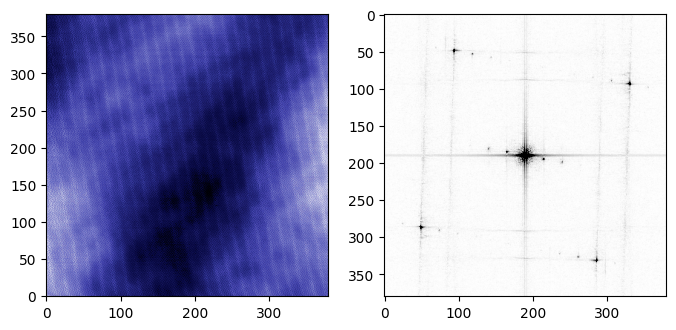

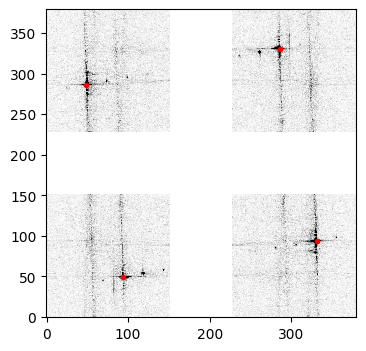

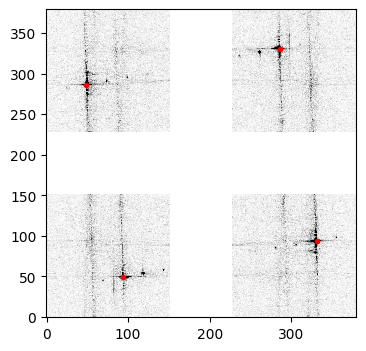

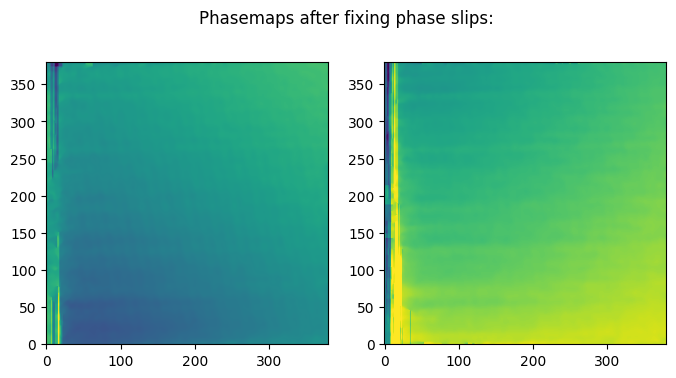

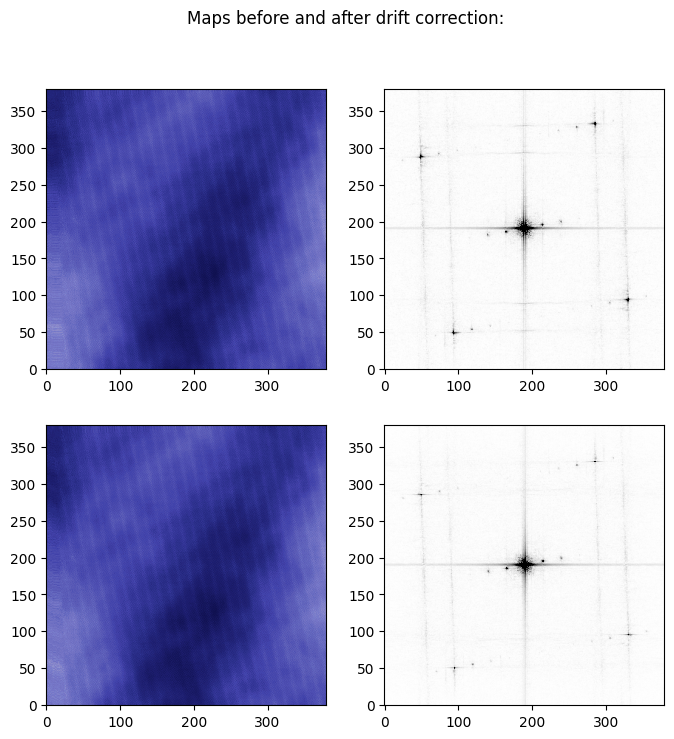

In [17]:
dfc.display(t.z)

getcontext().prec = 28  # Set the precision you need

decimal_arr = [Decimal(str(x)) for x in t.z.flatten()]
average = sum(decimal_arr) / Decimal(len(decimal_arr))
result = [x / average for x in decimal_arr]
result_arr = np.array(result, dtype=float).reshape(t.z.shape)
print(mean(result_arr))
nx, ny = shape(t.Z)
b = test.T.flat[ri] #using the same ri values defined above

testsparse = zeros_like(t.Z)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+5*s2])

# Find parameters to find Bragg peaks
dfc.findBraggs(testsparse, w=0.1, show=True)

# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(testsparse, w=0.1, sigma=20, show=True, method='lockin')

# Now using LIY

File import successful.
Corrected for a bias offset of -1.37 meV
The coordinates of the Bragg peaks are:
array([], shape=(0, 2), dtype=int64)

The coordinates of the Q vectors are:
array([], shape=(0, 2), dtype=int64)
The coordinates of the Bragg peaks are:
array([], shape=(0, 2), dtype=int64)

The coordinates of the Q vectors are:
array([], shape=(0, 2), dtype=int64)


ValueError: operands could not be broadcast together with shapes (0,) (2,) 

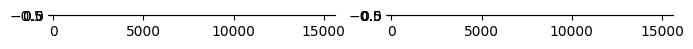

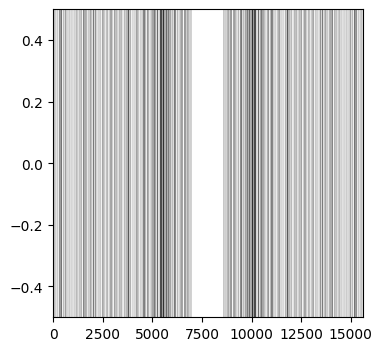

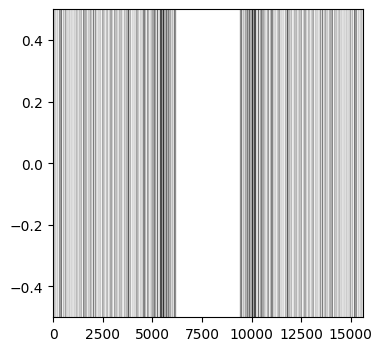

In [26]:
#### Load the dos map file
d = stmpy.load("2022-09-05-BSCCO-SparseSamplingDOS-001.3ds")

# take a look at the map
d.z = mean(d.LIY, axis=0)
dfc.display(d.z)

# find best parameters for findBraggs() function
bp1 = dfc.findBraggs(d.z, w=0.05, r=0.1, show=True)

# find the drifting field from averaged liy
d.z_c, p = dfc.find_drift_parameter(d.z, w=0.05, r=0.1, cut1=7, cut2=5, sigma=20, method='lockin', even_out=True, show=True)

# apply the drift field correction to the LIY 
#d.liy_c = dfc.apply_drift_parameter(d.LIY, p=p)